In [56]:
%reload_ext autoreload
# %load_ext autoreload
%autoreload 2
import pickle
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from matplotlib import cm

from mpl_toolkits.axes_grid1 import  AxesGrid

from numpy.linalg import norm

from scipy.spatial.distance import squareform,pdist
from scipy.io import loadmat


from sklearn.manifold import MDS
from sklearn import linear_model

from scipy.stats import zscore, kendalltau, kruskal, ttest_ind, mannwhitneyu, wilcoxon


from utils import *
from utils import gen_modelrdms, stats_fit_rdms, scatter_mds_2, scatter_mds_3, rotate, rotate_axes, spiceUp_figure, wrapper_fit_param_model, param_rdm_model
from plotting import * 
from plotting import plot_rsa_fits, plot_MDS_embeddings_2D

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

## File Paths 
let's set the absolute paths to data and code dirs

In [57]:
dir_results_humanbehav = '../../Results/Humans/Behaviour/'
dir_results_humanfmri  = '../../Results/Humans/RSA/'
dir_results_simus = '../../Results/Simulations/'
dir_results_monkeys = '../../Results/Monkeys/'

# Figure 1

## 1C: Human Accuracy

In [58]:
from plotting import plot_bars_humandata

plt.style.use('default')


# load accuracy 
acc_scan = loadmat(dir_results_humanbehav + '/acc_all_scan_granada.mat')['acc_all'][0][0][0]
acc_base = loadmat(dir_results_humanbehav + '/acc_all_training_granada.mat')['acc_all'][0][0][0][0][0][1] # 0 train 1 test 2 long train
badsubs = np.asarray([19,28])-1
acc_scan = np.delete(acc_scan,badsubs).T[np.newaxis,:]

# acc 
cm = 1/2.54
mm = cm/10
plt.figure(figsize=(40*mm,50*mm),dpi=300)
plot_bars_humandata(acc_base,acc_scan)
_ = plt.yticks(np.arange(0,1.2,.2),labels=(np.arange(0,1.2,.2)*100).astype('int'),fontsize=6)
plt.ylim((.3,1.01))
_= plt.ylabel('Accuracy (%)',fontsize=6)
plt.plot([0,3],[.5,.5],'k--')
plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: '../../Results/Humans/Behaviour//acc_all_scan_granada.mat'

## 1D: Human Choice Patterns

/tmp/ipykernel_25516/2314837865.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = cbar.ax.set_yticklabels([0,.2,.4,.6,.8,1],fontsize=6)


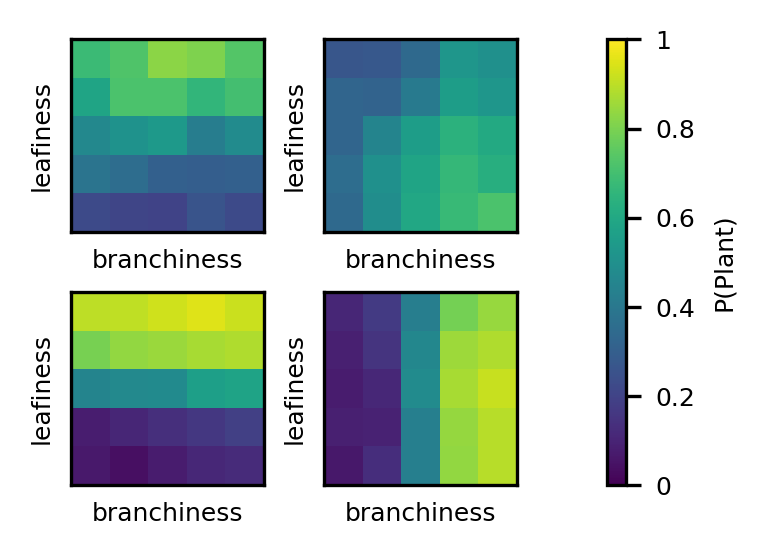

In [ ]:
from plotting import set_choicemat_axlabels 

data_train = loadmat(dir_results_humanbehav + 'cmats_train.mat')
data_scan = loadmat(dir_results_humanbehav + 'cmats_scan.mat')
cm = 1/2.54
mm = cm/10
fig = plt.figure(figsize=(65*mm,50*mm),dpi=300)
grid = AxesGrid(fig, 111, nrows_ncols=(2,2),axes_pad=0.2, cbar_mode='single',cbar_location='right',cbar_pad=0.3,label_mode='all')


im = grid[0].imshow(np.flipud(data_train['cmat_north'].mean(axis=0)))
im.set_clim(0,1)
set_choicemat_axlabels(grid[0])
im = grid[1].imshow(np.flipud(data_train['cmat_south'].mean(axis=0)))
im.set_clim(0,1)
set_choicemat_axlabels(grid[1])
im = grid[2].imshow(np.flipud(data_scan['cmat_north'].mean(axis=0)))
im.set_clim(0,1)
set_choicemat_axlabels(grid[2])
im = grid[3].imshow(np.flipud(data_scan['cmat_south'].mean(axis=0)))
im.set_clim(0,1)
set_choicemat_axlabels(grid[3])


cbar = grid.cbar_axes[0].colorbar(im)
_ = cbar.ax.set_yticklabels([0,.2,.4,.6,.8,1],fontsize=6)
_ = cbar.ax.set_ylabel('P(Plant)',fontsize=6)

# plt.tight_layout()


## 1E: Human Psychophysical Model

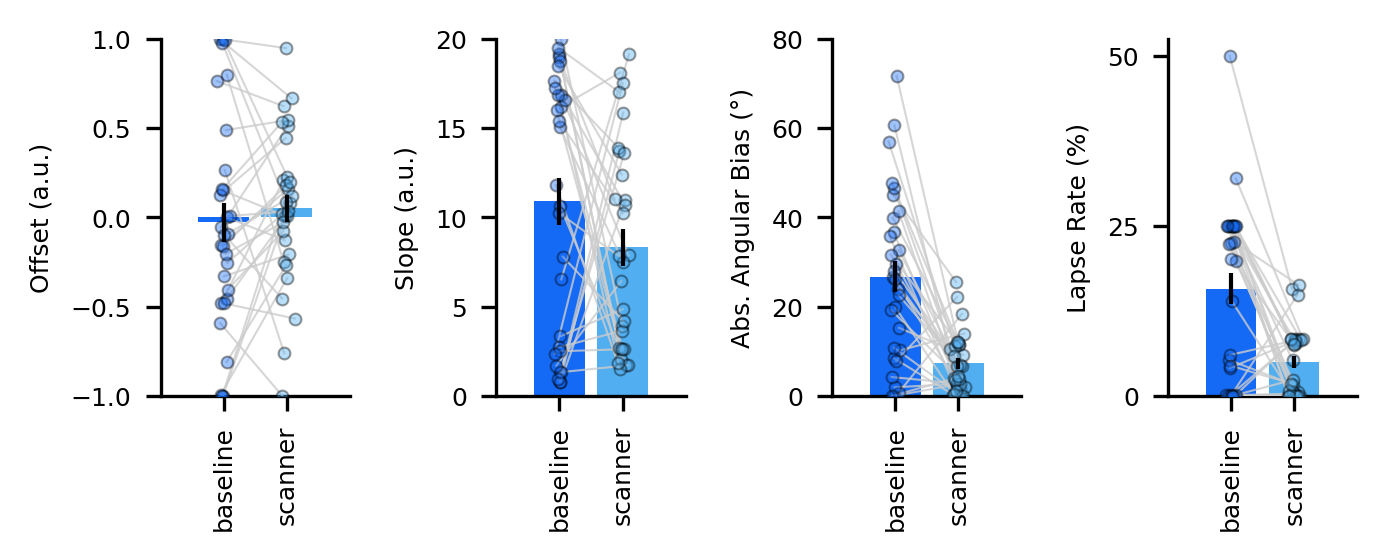

In [ ]:
data_base = loadmat(dir_results_humanbehav + 'choicemodel_train.mat')
data_scan = loadmat(dir_results_humanbehav + 'choicemodel_scan.mat')
keys = ['lapse','bias','offset','slope']
badsubs = np.asarray([19,28])-1
for k in keys:
    data_scan[k] = np.delete(data_scan[k],badsubs)[:,np.newaxis].T

cm = 1/2.54
mm = cm/10
fig = plt.figure(figsize=(120*mm,50*mm),dpi=300)
# offset
plt.subplot(1,4,1)
plot_bars_humandata(data_base['offset'].T,data_scan['offset'])
_ = plt.yticks(np.arange(-1,1.1,.5),fontsize=6)
_= plt.ylabel('Offset (a.u.)',fontsize=6)
plt.ylim((-1,1))

# slope 
plt.subplot(1,4,2)
plot_bars_humandata(data_base['slope'].T,data_scan['slope'])
_ = plt.yticks(np.arange(0,21,5),fontsize=6)
_= plt.ylabel('Slope (a.u.)',fontsize=6)
plt.ylim((0,20))

# angular bias 
plt.subplot(1,4,3)
plot_bars_humandata(np.abs(data_base['bias'].T),np.abs(data_scan['bias']))
plt.yticks(np.arange(0,81,20),fontsize=6)
_= plt.ylabel('Abs. Angular Bias (°)',fontsize=6)

# lapse rate
plt.subplot(1,4,4)
plot_bars_humandata(data_base['lapse'].T,data_scan['lapse'])
_= plt.ylabel('Lapse Rate (%)',fontsize=6)
_ = plt.yticks(np.arange(0,0.6,.25),labels=(np.arange(0,0.6,.25)*100).astype('int'),fontsize=6)

plt.tight_layout()

## 1F: Model RSA: Behaviouur

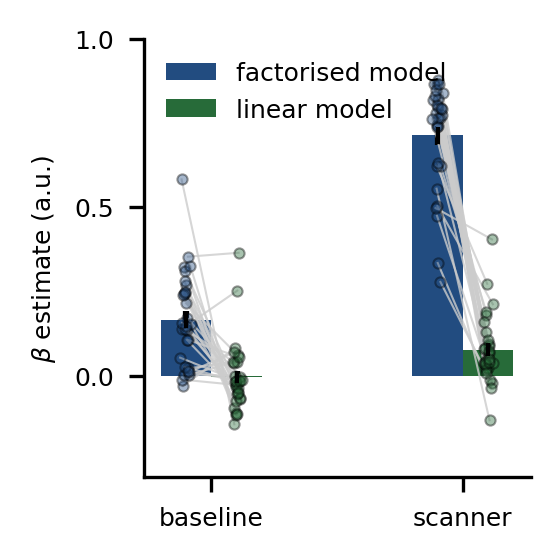

In [ ]:
betas_train = loadmat(dir_results_humanbehav + 'betas_3Dvs2D_training_granada.mat')['betas_day1'][0][0][0][0][0][0]
betas_scan = loadmat(dir_results_humanbehav + 'betas_3Dvs2D_scan_granada.mat')['betas_scan'][0][0][0][0][0][0]
plt.close()
N_SUBS = betas_train.shape[0]
badsubs = np.asarray([19,28])-1
betas_scan = np.delete(betas_scan,badsubs,axis=0)

mm = 1/25.4
plt.figure(figsize=(50*mm,50*mm),dpi=300)
width=0.2
idx1a = np.ones((1,N_SUBS))+np.random.randn(1,N_SUBS)*1e-2-width/2
idx1b = np.ones((1,N_SUBS))+np.random.randn(1,N_SUBS)*1e-2+width/2

idx2a = 2*np.ones((1,N_SUBS))+np.random.randn(1,N_SUBS)*1e-2-width/2
idx2b = 2*np.ones((1,N_SUBS))+np.random.randn(1,N_SUBS)*1e-2+width/2

b1=  plt.bar(1-width/2,betas_train[:,0].mean(0),width=width,yerr=betas_train[:,0].std(0)/(N_SUBS**.5),color=(34/255, 76/255, 128/255))
plt.scatter(idx1a,betas_train[:,0],s=6,alpha=0.4,edgecolors='k',color=(34/255, 76/255, 128/255),zorder=4,linewidth=.5)
plt.errorbar(1-width/2,betas_train[:,0].mean(0),linewidth=1,linestyle='None',yerr=betas_train[:,0].std(0)/(N_SUBS**.5),color='k',zorder=6)

b2 = plt.bar(1+width/2,betas_train[:,1].mean(0),width=width,yerr=betas_train[:,1].std(0)/(N_SUBS**.5),color=(39/255, 107/255, 57/255))
plt.scatter(idx1b,betas_train[:,1],s=6,alpha=0.4,edgecolors='k',color=(39/255, 107/255, 57/255),zorder=4,linewidth=.5)
plt.errorbar(1+width/2,betas_train[:,1].mean(0),linewidth=1,linestyle='None',yerr=betas_train[:,1].std(0)/(N_SUBS**.5),color='k',zorder=6)
plt.plot(np.concatenate((idx1a,idx1b),axis=0),betas_train.T,color=(.8, .8, .8),alpha=.8,linewidth=.5)


plt.bar(2-width/2,betas_scan[:,0].mean(0),width=width,yerr=betas_scan[:,0].std(0)/(betas_scan.shape[0]**.5),color=(34/255, 76/255, 128/255))
plt.scatter(idx2a,betas_scan[:,0],s=6,alpha=0.4,edgecolors='k',color=(34/255, 76/255, 128/255),zorder=4,linewidth=.5)
plt.errorbar(2-width/2,betas_scan[:,0].mean(0),linewidth=1,linestyle='None',yerr=betas_train[:,0].std(0)/(N_SUBS**.5),color='k',zorder=6)

plt.bar(2+width/2,betas_scan[:,1].mean(0),width=width,yerr=betas_scan[:,1].std(0)/(betas_scan.shape[0]**.5),color=(39/255, 107/255, 57/255))
plt.scatter(idx2b,betas_scan[:,1],s=6,alpha=0.4,edgecolors='k',color=(39/255, 107/255, 57/255),zorder=4,linewidth=.5)
plt.errorbar(2+width/2,betas_scan[:,1].mean(0),linewidth=1,linestyle='None',yerr=betas_scan[:,1].std(0)/(N_SUBS**.5),color='k',zorder=6)
plt.plot(np.concatenate((idx2a,idx2b),axis=0),betas_scan.T,color=(.8, .8, .8),alpha=.8,linewidth=.5)

plt.xticks(fontsize=6,ticks=[1,2],labels=['baseline','scanner'],rotation=0)
plt.yticks(fontsize=6)
# sns.despine()
plt.legend([b1,b2],['factorised model','linear model'],loc=2,frameon=False,fontsize=6)
plt.ylim((-0.3,1))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel(r'$\beta$ estimate (a.u.)',fontsize=6)
plt.tight_layout()

# Figure 2

## 2B: Weight Norms & Relative Change: Input Weights

input weights:
endpoint weight  KruskalResult(statistic=235.19551867219923, pvalue=3.9049465134499905e-47)
relative weight change  KruskalResult(statistic=94.54903181189468, pvalue=1.4355187919152584e-17)


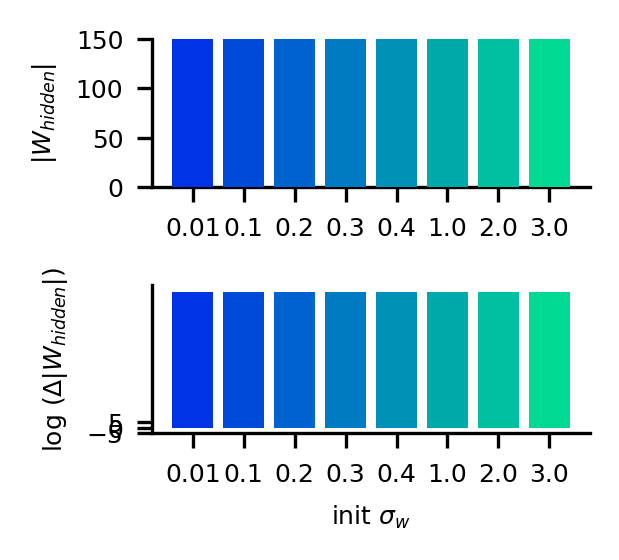

In [115]:
from plotting import plot_norms

%matplotlib inline
SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])
N_FACTORS = len(SCALE_WHXS)
scale_labels = [str(ii) for ii in SCALE_WHXS]


# open results (was 'results_nnet_main_withacc_withmlp_stepscaled.pickle)
with open(dir_results_simus + 'results_mlp_sigmoid_main.pkl','rb') as f:
        results = pickle.load(f)

ws = (results['w_relchange_hxs'][:,:,-1]+results['w_relchange_hxc'][:,:,-1])/2

N_RUNS = ws.shape[1]



mm = 1/25.4
fig = plt.figure(figsize=(55*mm,50*mm),dpi=300)

plt.subplot(2,1,1)

norms = np.empty((8,N_RUNS))
cols = cm.winter(np.linspace(.2,.85,8))
for ii in range(8):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(np.concatenate((results['all_w_hxs'][ii,jj,:,:].flatten(),results['all_w_hxc'][ii,jj,:,:].flatten()),axis=0))

plot_norms(norms,'Endpoint Norms, input weights',SCALE_WHXS,zorder=3,colors=cols)

plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels,fontsize=6)
plt.yticks(ticks=np.arange(0,161,50),fontsize=6)
plt.ylim(0,150)
plt.ylabel(r'$\| W_{hidden}\|$',fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
lims = plt.xlim()
plt.xlim(lims)
plt.tight_layout()


plt.subplot(2,1,2)
for ii in range(ws.shape[0]):
    plt.bar(ii,np.mean(np.log(np.abs(ws[ii,:])),0),yerr=np.std(np.log(np.abs(ws[ii,:])),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])
plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels,fontsize=6)
plt.yticks(ticks=np.arange(-5,5.1,5),fontsize=6)
plt.ylabel(r'log $\left(\Delta\|W_{hidden}\|\right)$',fontsize=6)
plt.xlabel(r'init $\sigma_{w}$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

print('input weights:')
print(f'endpoint weight  {kruskal(*norms)}')
print(f'relative weight change  {kruskal(*ws)}')


## 2C: Weight Norms & Relative Change: Output Weights

In [116]:
# ditto for output weights 

ws = results['w_relchange_yh'][:,:,-1]
N_RUNS = ws.shape[1]


mm = 1/25.4
fig = plt.figure(figsize=(55*mm,50*mm),dpi=300)

plt.subplot(2,1,1)

norms = np.empty((8,N_RUNS))
cols = cm.winter(np.linspace(.2,.85,8))
for ii in range(8):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(results['all_w_yh'][ii,jj,:,:].flatten())

plot_norms(norms,'Endpoint Norms, all weights',SCALE_WHXS,zorder=3,colors=cols)
# plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=[],fontsize=6)
plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels,fontsize=6)
plt.yticks(ticks=np.arange(0,11,5),fontsize=6)
plt.ylabel(r'$\| W_{out}\|$',fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
lims = plt.xlim()
plt.xlim(lims)
plt.tight_layout()


plt.subplot(2,1,2)
for ii in range(ws.shape[0]):
    plt.bar(ii,np.mean(np.log(np.abs(ws[ii,:])),0),yerr=np.std(np.log(np.abs(ws[ii,:])),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])
plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels,fontsize=6)
plt.yticks(fontsize=6)
plt.yticks(ticks=np.arange(0,6,5))
plt.ylabel(r'log $\left(\Delta\|W_{out}\|\right)$',fontsize=6)
plt.xlabel(r'init $\sigma_{w}$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()


print('output weights:')
print(f'endpoint weight  {kruskal(*norms)}')
print(f'relative weight change  {kruskal(*ws)}')


output weights:
endpoint weight  KruskalResult(statistic=235.20781466113397, pvalue=3.881515507796818e-47)
relative weight change  KruskalResult(statistic=234.6307192254494, pvalue=5.148392147659603e-47)


## 2E: PCA,Explained Variance

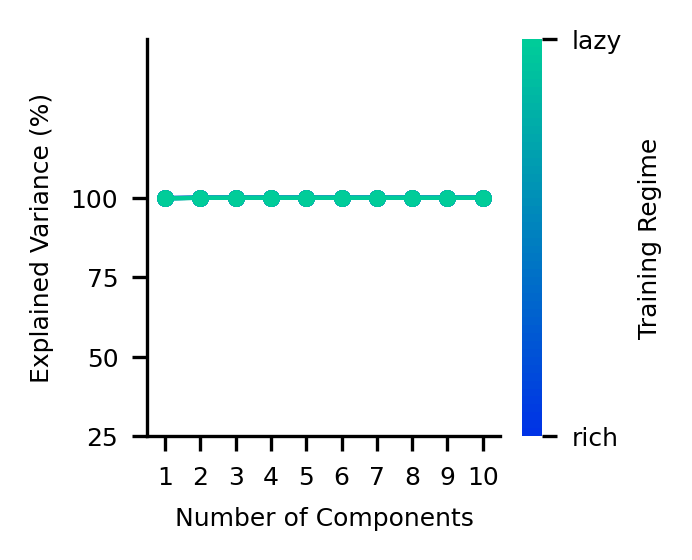

In [117]:
nmax=10 # how many pcs to show

# calculate endpoint norms
norms = np.empty((8,N_RUNS))
for ii in range(8):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(np.concatenate((results['all_w_hxs'][ii,jj,:,:].flatten(),results['all_w_hxc'][ii,jj,:,:].flatten(),results['all_w_yh'][ii,jj,:,:].flatten()),axis=0))

norms_flt = np.round(np.mean(norms,1),0).astype('int')
norms = ['norm='+str(np.round(ii).astype('int')) for ii in norms_flt]


# Cumulative Explained Variance
cols = cm.winter(np.linspace(.2,.8,8))
cmap_new = mpl.colors.ListedColormap(cm.winter(np.linspace(.2,.8,50)))

mm = 1/25.4
fig = plt.figure(figsize=(60*mm,50*mm),dpi=300)
for ii in range(cols.shape[0]):
    plt.errorbar(np.arange(1,nmax+1),np.mean(np.cumsum(results['svd_scree'][ii,:,:nmax],1),0),color=cols[ii,:],marker='.',yerr=np.std(np.cumsum(results['svd_scree'][ii,:,:nmax],1),0)/np.sqrt(results['svd_scree'].shape[1]),linewidth=1)

plt.xlabel('Number of Components',fontsize=6)
plt.ylabel('Explained Variance (%)',fontsize=6) 

# axis labels
plt.yticks(ticks=np.arange(.0,1.25,.25))
plt.yticks(ticks=np.arange(.0,1.25,.25), labels=(plt.yticks()[0]*100).astype('int'),fontsize=6)

plt.xlim((0.5,nmax+0.5))
plt.xticks(ticks=np.arange(1,nmax+1),fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# add colorbar
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_new,norm=norm)
cb = plt.colorbar(sm,ticks=[0,1])
cb.ax.set_yticklabels([norms_flt[0],norms_flt[-1]])
cb.ax.set_yticklabels(['rich','lazy'],fontsize=6)
cb.ax.set_ylabel('Training Regime',fontsize=6)
cb.outline.set_visible(False)

_ = plt.ylim((.25,1.5))

plt.tight_layout()

## 2F: PCA, Accuracy

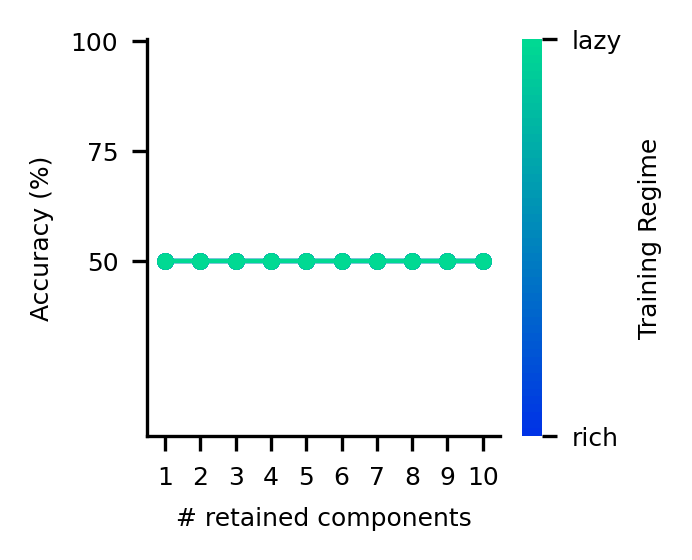

In [118]:
nmax=10

# Accuracy

mm = 1/25.4
fig = plt.figure(figsize=(60*mm,50*mm),dpi=300)

cols = cm.winter(np.linspace(.2,.85,8))

for ii in range(cols.shape[0]):
    plt.errorbar(np.arange(1,nmax+1),np.mean(results['svd_acc'][ii,:,:nmax],0),color=cols[ii,:],marker='.',yerr=np.std(results['svd_acc'][ii,:,:nmax],0)/np.sqrt(results['svd_acc'].shape[1]),linewidth=1)
plt.xlabel('# retained components',fontsize=6)
plt.ylabel('Accuracy (%)',fontsize=6) 
plt.xticks(ticks=np.arange(1,nmax+1,1),fontsize=6)



cols = cm.winter(np.linspace(.2,.85,8))
cmap_new = mpl.colors.ListedColormap(cm.winter(np.linspace(.2,.85,50)))
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_new,norm=norm)


cb = plt.colorbar(sm,ticks=[0,1])
cb.ax.set_yticklabels(['rich','lazy'],fontsize=6)
cb.ax.set_ylabel('Training Regime',fontsize=6)

cb.outline.set_visible(False)

plt.yticks(ticks=np.arange(0.5,1.25,.25),labels=np.arange(50,125,25).astype('int'),fontsize=6)
plt.ylim((0.1,1.005))
plt.xlim((.5,nmax+.5))


ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

## 2G: Convergence Speed

In [119]:

cols = cm.winter(np.linspace(.2,.85,8))
is_ceil = []
mm = 1/25.4
fig = plt.figure(figsize=(60*mm,50*mm),dpi=300)
for ii in range(N_FACTORS):
    this_conv = np.where(np.mean(results['all_accuracies'][ii,:,:],0)==1)[0][0]
    is_ceil.append(this_conv)
    # plt.barh(ii,this_conv,color=cols[ii,:])    
    plt.bar(ii,this_conv,color=cols[ii,:])    


plt.xlabel('init $\sigma_w$',fontsize=6)
plt.ylabel('Episodes until convergence',fontsize=6)
plt.xticks(ticks=np.arange(0,8),labels=SCALE_WHXS,fontsize=6)
ticks = plt.yticks()[0]
plt.yticks(ticks=ticks,fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()
plt.tight_layout()

is_ceil = []
for ii in range(N_FACTORS):
    this_conv = np.empty(30)
    for r in range(30):
        this_conv[r] = np.where(results['all_accuracies'][ii,r,:]==1)[0][0]    
    is_ceil.append(this_conv)
print(f'convergence rates rich vs lazy: {ttest_ind(is_ceil[0],is_ceil[-1])}')

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 708.661x590.551 with 0 Axes>

## 2H: Added Noise

ValueError: operands could not be broadcast together with shapes (11,1) (2,11) 

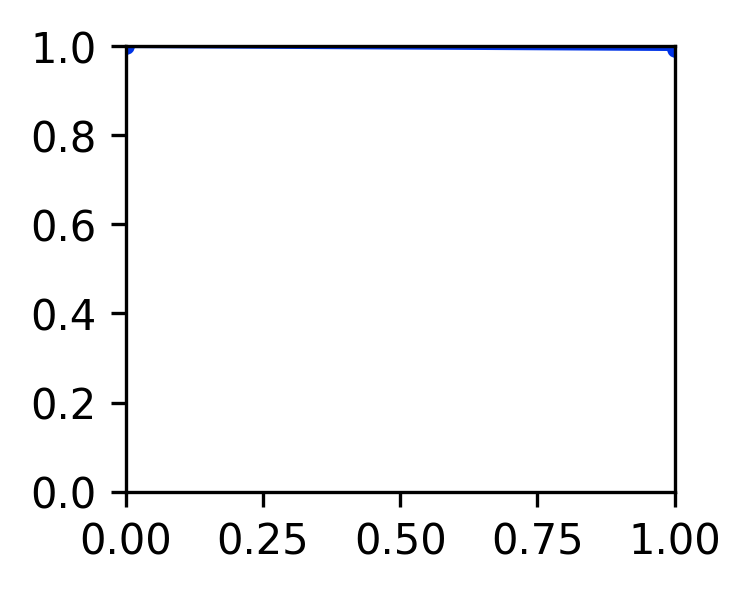

In [90]:

with open(dir_results_simus + 'results_mlp_noise.pkl','rb') as f:
    results = pickle.load(f)


norms = np.empty((8,30))
for ii in range(8):
    for jj in range(30):
        norms[ii,jj] = np.linalg.norm(np.concatenate((results['all_w_hxs'][ii,jj,:,:].flatten(),results['all_w_hxc'][ii,jj,:,:].flatten(),results['all_w_yh'][ii,jj,:,:].flatten()),axis=0))
norms_flt = np.round(np.mean(norms,1),0).astype('int')
norms = ['norm='+str(np.round(ii).astype('int')) for ii in norms_flt]


mm = 1/25.4
fig = plt.figure(figsize=(60*mm,50*mm),dpi=300)

cols = cm.winter(np.linspace(.2,.85,8))
cmap_new = mpl.colors.ListedColormap(cm.winter(np.linspace(.2,.85,50)))

for ii in range(cols.shape[0]):
    plt.errorbar(np.arange(len(results['xlabel_noise'])),np.mean(results['acc_noise'][ii,:,:],0),color=cols[ii,:],marker='.',yerr=(np.std(results['acc_noise'][ii,:,:],0)/np.sqrt(results['acc_noise'].shape[1])).ravel(),linewidth=1)

plt.xlabel('Input Noise Level',fontsize=6)
plt.ylabel('Accuracy (%)',fontsize=6) 
plt.title('Sensitivity to Gaussian Input Noise',fontsize=6)


norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_new,norm=norm)
cb = plt.colorbar(sm,ticks=[0,1])
cb.ax.set_yticklabels(['rich','lazy'],fontsize=6)
cb.ax.set_ylabel('Training Regime',fontsize=6)

cb.outline.set_visible(False)

plt.ylim((0.5,1.01))


plt.yticks(ticks=np.arange(0.5,1.25,.25),labels=np.arange(50,125,25).astype('int'),fontsize=6)
plt.ylim((0.5,1.005))
plt.xticks(ticks=np.arange(0,len(results['xlabel_noise']),2),labels=results['xlabel_noise'][0::2],fontsize=6)


ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlim([0,len(results['xlabel_noise'])])

plt.tight_layout()

# Figure 3

## 3A,B: Nnet MDS

In [120]:
y = results['all_y_hidden']
print(y.shape)
rdms = np.empty((2,N_RUNS,50,50))
for ii in range(N_RUNS):
    rdms[0,ii,:,:] = squareform(pdist(y[0,ii,:,:].T,metric='euclidean'))
for ii in range(N_RUNS):
    rdms[1,ii,:,:] = squareform(pdist(y[-1,ii,:,:].T,metric='euclidean'))

labels = ['feature learning regime', 'lazy learning regime']
fig=plt.figure(1,figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(2):
    plt.subplot(1,2,ii+1)
    plt.imshow(np.mean(rdms[ii,:,:,:],0))
    plt.title(labels[ii])


embedding = MDS(n_components=3,n_init=10,max_iter=10000,metric=True)

xyz_rich = embedding.fit_transform(np.mean(rdms[0,:,:,:],0))
xyz_lazy = embedding.fit_transform(np.mean(rdms[1,:,:,:],0))
embeddings = {'rich':xyz_rich, 'lazy':xyz_lazy}


(8, 30, 100, 50)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:506: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:506: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


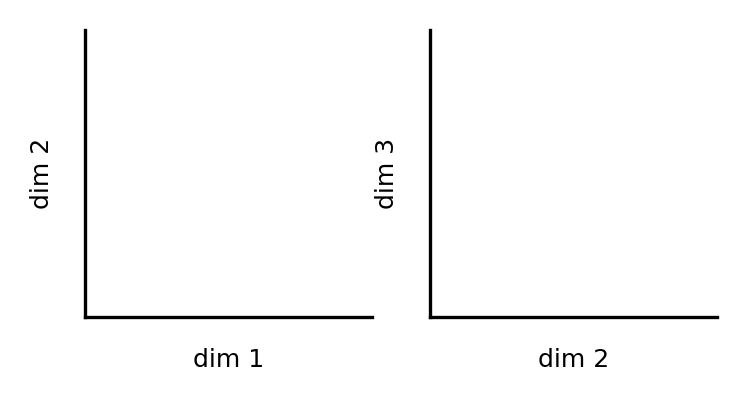

In [123]:
%matplotlib inline
# plot rich regime
# with open('mds_embeddings.pickle','rb') as f:
#         embeddings = pickle.load(f)
theta_x = 0
theta_y = 0
theta_z = 0

xyz_rot = rotate(embeddings['rich'],theta_x,axis='x')
xyz_rot = rotate(xyz_rot,theta_y,axis='y')
xyz_rot = rotate(xyz_rot,theta_z,axis='z')

plt.close()
mm = 1/25.4
fig = plt.figure(2,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=2.5)


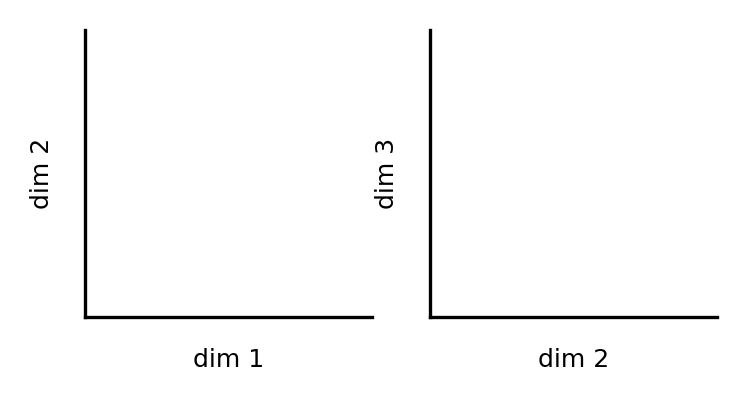

In [113]:
# plot lazy regime
# with open('mds_embeddings.pickle','rb') as f:
#         embeddings = pickle.load(f)
theta_x = 0
theta_y = 0
theta_z = 0

xyz_rot = rotate(embeddings['lazy'],theta_x,axis='x')
xyz_rot = rotate(xyz_rot,theta_y,axis='y')
xyz_rot = rotate(xyz_rot,theta_z,axis='z')

plt.close()
mm = 1/25.4
fig = plt.figure(3,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=3,axlims=4)


## 3C: Nnet RSA

ttest orth: rich > lazy: Ttest_indResult(statistic=0.16336941479783715, pvalue=0.8707955090791863), ttest grid: rich < lazy: Ttest_indResult(statistic=-0.16240345931611533, pvalue=0.8715526312218973)
ttest grid> par main: Ttest_indResult(statistic=57307.17161127196, pvalue=1.5193060803033246e-226), ttest orth > par main: Ttest_indResult(statistic=-297654.37110786926, pvalue=4.8134299433046785e-268)


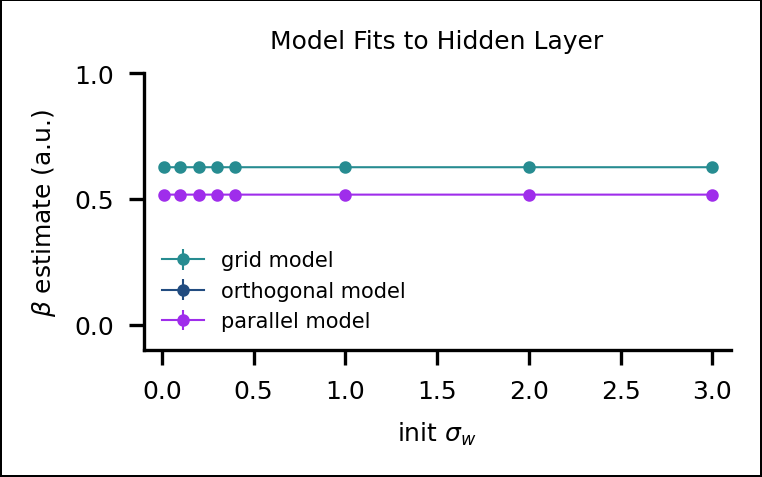

In [114]:

with open(dir_results_simus + 'results_mlp_sigmoid_main.pkl','rb') as f:
        results = pickle.load(f)

ws = results['w_relchange_hxs'][:,:,-1]
N_RUNS = ws.shape[1]
_, dmat,xyz = gen_modelrdms(monitor=0)

coeffs,c_mu,c_err = stats_fit_rdms(dmat,results['all_y_hidden'])

fig=plt.figure(figsize=(67*(1/25.4), 43*(1/25.4)), dpi=300, facecolor='w', edgecolor='k',linewidth=.5)

  

plot_rsa_fits(c_mu,c_err,runvalue=SCALE_WHXS,runlabel=r'init $\sigma_{w}$',titlestr='Model Fits to Hidden Layer')
plt.ylim((-.1,1))

plt.tight_layout()
c_grid = coeffs[:,:,0]
c_orth = coeffs[:,:,1]
c_par = coeffs[:,:,2]

print(f'ttest orth: rich > lazy: {ttest_ind(c_orth[0],c_orth[-1])}, ttest grid: rich < lazy: {ttest_ind(c_grid[0],c_grid[-1])}')
print(f'ttest grid> par main: {ttest_ind(c_grid.mean(0),c_par.mean(0))}, ttest orth > par main: {ttest_ind(c_orth.mean(0),c_par.mean(0))}')


## 3D,E,F: Nnet Parameterised Model

In [74]:
# fit parametrised model to hidden layer patterns 
thetas = np.empty((8,N_RUNS,6))
rdms = np.empty((8,N_RUNS,50,50))
for s in range(8):
    for r in range(N_RUNS):
        rdm = squareform(pdist(results['all_y_hidden'][s,r,:,:].T))
        t = wrapper_fit_param_model(rdm,n_iters=100,para_iters=True)
        thetas[s,r,:] = t 
        rdms[s,r,:,:] = squareform(param_rdm_model(t))
parammod_results = {'thetas':thetas,'rdms':rdms}
with open('parammod_results.pkl','wb') as f:
    pickle.dump(parammod_results,f)

from scipy.stats import norm

with open(dir_results_simus + 'parammod_results.pkl','rb') as f:
    data = pickle.load(f)

compression_rates = []
phis = []
offsets = []
for ii in range(len(SCALE_WHXS)):

    data_layer = np.array(data['thetas'])[ii,:,:]
    # north & south task task
    comp_north = np.log(data_layer[:,0]/data_layer[:,2])
    comp_south = np.log(data_layer[:,1]/data_layer[:,3])
    compression_rates.append(np.array(comp_north+comp_south)/2)
    phis.append(data_layer[:,4])
    offsets.append(data_layer[:,5])

z,p = kruskal(*compression_rates)
z = norm.isf(p/2)
print(f'are compression rates different? kruskal wallis: z={z:.4f}, p={p:.4f}')

t,p = ttest_ind(compression_rates[0],compression_rates[-1])
# z = norm.isf(p/2)
print(f'is compression larger in rich than lazy: t={t:.4f}, p={p:.4f}')

z,p = wilcoxon(compression_rates[0])
z = norm.isf(p/2)
print(f'is compression significant in rich: z={z:.4f}, p={p:.4f}')

z,p = wilcoxon(compression_rates[-1])
z = norm.isf(p/2)
print(f'is compression significant in lazy: z={z:.4f}, p={p:.4f}')


z,p = kruskal(*phis)
z = norm.isf(p/2)
print(f'are angles different? kruskal wallis: z={z:.4f}, p={p:.4f}')

z,p = mannwhitneyu(phis[0],phis[-1])
z = norm.isf(p/2)
print(f'is angles larger in rich than lazy: z={z:.4f}, p={p:.4f}')

z,p = wilcoxon(90-phis[0])
z = norm.isf(p/2)
print(f'is rotation significantly different from 90 in rich: z={z:.4f}, p={p:.4f}')

z,p = wilcoxon(90-phis[-1])
z = norm.isf(p/2)
print(f'is rotation significantly different from 90 in lazy: z={z:.4f}, p={p:.4f}')


z,p = kruskal(*offsets)
z = norm.isf(p/2)
print(f'are offsets different? kruskal wallis: z={z:.4f}, p={p:.4f}')

z,p = mannwhitneyu(offsets[0],offsets[-1])
z = norm.isf(p/2)
print(f'is offset larger in rich than lazy: z={z:.4f}, p={p:.4f}')

z,p = wilcoxon(offsets[0])
z = norm.isf(p/2)
print(f'is offset significant in rich: z={z:.4f}, p={p:.4f}')

z,p = wilcoxon(offsets[-1])
z = norm.isf(p/2)
print(f'is offset significant in lazy: z={z:.4f}, p={p:.4f}')


mm = 1/25.4
f1 = plt.figure(1,figsize=(60*mm,50*mm), dpi=300)
f2 = plt.figure(2,figsize=(55*mm,50*mm), dpi=300)
f3 = plt.figure(3,figsize=(55*mm,50*mm), dpi=300)
f4 = plt.figure(4,figsize=(55*mm,50*mm), dpi=300)

cols = cm.winter(np.linspace(.2,.85,8))
for ii in range(len(SCALE_WHXS)):

    data_layer = np.array(data['thetas'])[ii,:,:]

    # plot relative compression
    plt.figure(f1.number)
    # north & south task task
    comp_north = np.log(data_layer[:,0]/data_layer[:,2])
    comp_south = np.log(data_layer[:,1]/data_layer[:,3])
    bn = plt.bar(ii-0.1,np.mean(comp_north),yerr=np.std(comp_north)/(len(comp_north)**.5),width=0.3,linewidth=2,color=(0,0,.5),zorder=1)
    bs = plt.bar(ii+0.2,np.mean(comp_south),yerr=np.std(comp_south)/(len(comp_south)**.5),width=0.3,linewidth=2,color=(255/255,102/255,0),zorder=1)
    plt.scatter(np.repeat((ii-0.1),len(comp_north))+np.random.randn(len(comp_north))*0.01,comp_north,s=4,color=(0,0,.5),alpha=.4,zorder=3,edgecolors='k',linewidth=0.2)
    plt.scatter(np.repeat((ii+0.2),len(comp_south))+np.random.randn(len(comp_north))*0.01,comp_south,s=4,color=(255/255,102/255,0),alpha=.4,zorder=3,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f1,SCALE_WHXS)
    plt.ylabel(r'$\mathrm{log(\frac{compression_{relevant}}{compression_{irrelevant}})}$',fontsize=7)
    # plt.title('Estimated Compression \n Relevant vs Irrelevant Dimension',fontsize=6)
    plt.legend([bs,bn],['Task A','Task B'],frameon=False,loc=1,fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.xlabel(r'initial $\sigma_w$',fontsize=6)

    
    # plot estimated angle (abs)
    plt.figure(f2.number)
    phi_est = np.abs(data_layer[:,4])
    bph = plt.bar(ii,np.mean(phi_est),yerr=np.std(phi_est)/(len(phi_est)**.5),width=0.3,color=cols[ii],zorder=1)
    plt.scatter(np.repeat(ii,len(phi_est))+np.random.randn(len(comp_north))*0.01,phi_est,color=cols[ii],alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f2,SCALE_WHXS)
    plt.ylabel('abs(rotation) (°)',fontsize=6)
    # plt.title('Estimated Rotation \n from Stimulus to Response Space',fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(ticks=[0,30,60,90],fontsize=6)
    plt.ylim([0,90])
    plt.xlabel(r'initial $\sigma_w$',fontsize=6)

    # estimated ctx offset 
    plt.figure(f3.number)
    ctx_est = data_layer[:,5]
    bctx = plt.bar(ii,np.mean(ctx_est),yerr=np.std(ctx_est)/(len(ctx_est)**.5),width=0.6,color=cols[ii])
    plt.scatter(np.repeat(ii,len(ctx_est))+np.random.randn(len(comp_north))*0.01,ctx_est,color=cols[ii],alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f3,SCALE_WHXS)
    plt.ylabel('ctx offset (a.u.)',fontsize=6)
    # plt.title('Estimated Context Offset Parameter',fontsize=6)
    plt.ylim([0,2])
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.xlabel(r'initial $\sigma_w$',fontsize=6)

    # plot estimated angle 
    plt.figure(f4.number)
    phi_est = data_layer[:,4]
    bph = plt.bar(ii,np.mean(phi_est),yerr=np.std(phi_est)/(len(phi_est)**.5),width=0.6,color=cols[ii],zorder=1)
    plt.scatter(np.repeat(ii,len(phi_est))+np.random.randn(len(comp_north))*0.01,phi_est,color=cols[ii],alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f4,SCALE_WHXS)
    plt.ylabel('rotation (°)',fontsize=6)
    # plt.title('Estimated Rotation \n from Stimulus to Response Space',fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(ticks=[-90,-60,-30,0,30,60,90],fontsize=6)
    plt.ylim([-90,90])
    plt.xlabel(r'initial $\sigma_w$',fontsize=6)


plt.figure(f1.number)
plt.yticks(np.arange(-1,1.1,1)) 
plt.ylim([-1,1])
lims = plt.xlim()
plt.plot(lims,[0,0],'k-',linewidth=.5)
plt.tight_layout()
plt.figure(f2.number)
plt.ylim([0,90])
lims = plt.xlim()
plt.plot(lims,[0,0],'k-',linewidth=.5)
plt.tight_layout()
plt.figure(f3.number)
plt.tight_layout()
plt.figure(f4.number)
plt.tight_layout()
f = plt.gcf()
f.set_dpi(300)

/Users/manuel_iigaya/Documents/IigayaLabs/Flesch_etal_Neuron-main/Analysis/AllFigures/utils.py:56: RuntimeWarning: invalid value encountered in divide
  rvect /= np.max(rvect)
/Users/manuel_iigaya/Documents/IigayaLabs/Flesch_etal_Neuron-main/Analysis/AllFigures/utils.py:56: RuntimeWarning: invalid value encountered in divide
  rvect /= np.max(rvect)
/Users/manuel_iigaya/Documents/IigayaLabs/Flesch_etal_Neuron-main/Analysis/AllFigures/utils.py:56: RuntimeWarning: invalid value encountered in divide
  rvect /= np.max(rvect)
/Users/manuel_iigaya/Documents/IigayaLabs/Flesch_etal_Neuron-main/Analysis/AllFigures/utils.py:56: RuntimeWarning: invalid value encountered in divide
  rvect /= np.max(rvect)
/Users/manuel_iigaya/Documents/IigayaLabs/Flesch_etal_Neuron-main/Analysis/AllFigures/utils.py:56: RuntimeWarning: invalid value encountered in divide
  rvect /= np.max(rvect)
/Users/manuel_iigaya/Documents/IigayaLabs/Flesch_etal_Neuron-main/Analysis/AllFigures/utils.py:56: RuntimeWarning: inval

FileNotFoundError: [Errno 2] No such file or directory: '../../Results/Simulations/parammod_results.pkl'

# Figure 4

## 4B: fMRI Parameterised Model 

EVC Compression North: z=2.25, p=0.0242, Compression South: z=4.10, p=0.0000 
EVC Offset: z=4.86, p=0.0000 
EVC Angle: z=1.49, p=0.1364 
PPC Compression North: z=4.80, p=0.0000, Compression South: z=4.84, p=0.0000 
PPC Offset: z=4.86, p=0.0000 
PPC Angle: z=0.53, p=0.5967 
MCC Compression North: z=4.84, p=0.0000, Compression South: z=4.80, p=0.0000 
MCC Offset: z=4.86, p=0.0000 
MCC Angle: z=0.27, p=0.7838 
dlPFC Compression North: z=4.53, p=0.0000, Compression South: z=4.86, p=0.0000 
dlPFC Offset: z=4.86, p=0.0000 
dlPFC Angle: z=1.14, p=0.2557 


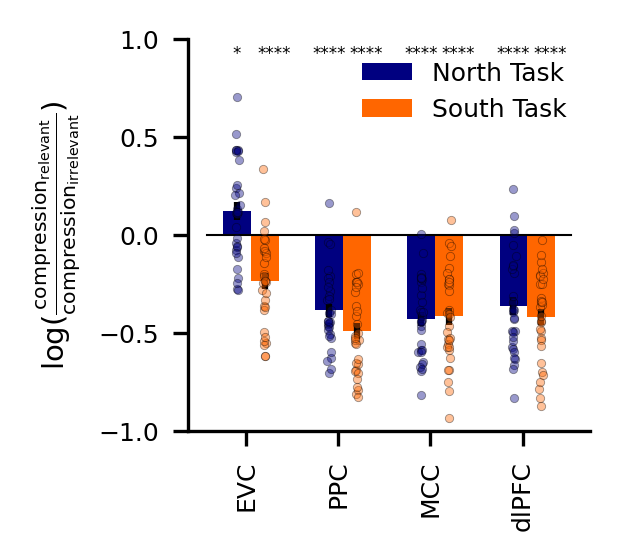

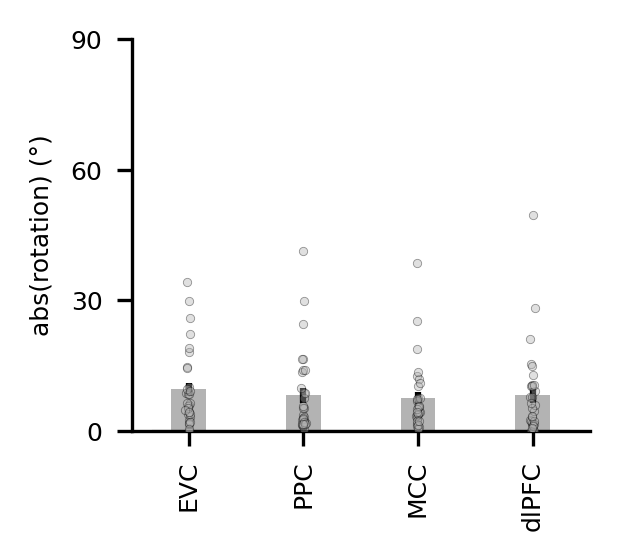

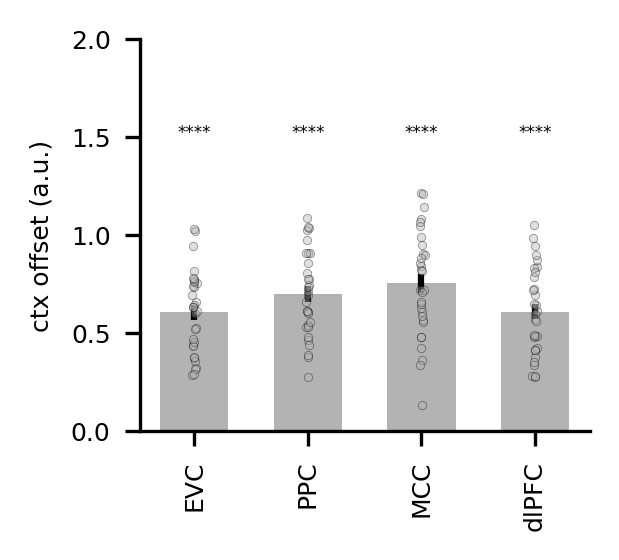

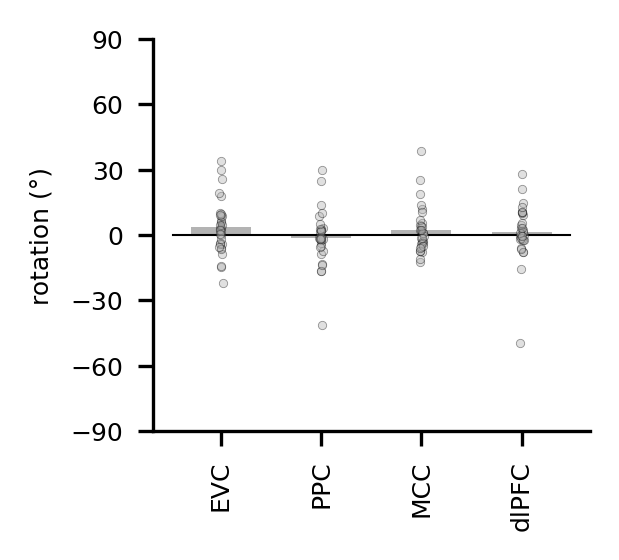

In [3]:
from scipy.stats import wilcoxon, norm

roi_names = ['EVC', 'PPC', 'MCC', 'dlPFC']


data_dir = dir_results_humanfmri + 'ROIs/'
roi_files = ['results_fmincon_avg_leftEVC.mat',
'results_fmincon_avg_PPC.mat',
'results_fmincon_avg_MCC.mat',
'results_fmincon_avg_DLPFC.mat']


mm = 1/25.4
f1 = plt.figure(1,figsize=(55*mm,50*mm), dpi=300)
f2 = plt.figure(2,figsize=(55*mm,50*mm), dpi=300)
f3 = plt.figure(3,figsize=(55*mm,50*mm), dpi=300)
f4 = plt.figure(4,figsize=(55*mm,50*mm), dpi=300)
for ii,nm in enumerate(roi_files):

    
    all_data = loadmat(data_dir + nm)['data']

    # plot relative compression
    plt.figure(f1.number)
    # north & south task task
    comp_north = np.log(all_data[:,0]/all_data[:,2])
    comp_south = np.log(all_data[:,1]/all_data[:,3])
    bn = plt.bar(ii-0.1,np.mean(comp_north),yerr=np.std(comp_north)/(len(comp_north)**.5),width=0.3,linewidth=2,color=(0,0,.5),zorder=1)
    bs = plt.bar(ii+0.2,np.mean(comp_south),yerr=np.std(comp_south)/(len(comp_south)**.5),width=0.3,linewidth=2,color=(255/255,102/255,0),zorder=1)
    plt.scatter(np.repeat((ii-0.1),len(comp_north))+np.random.randn(len(comp_north))*0.01,comp_north,s=4,color=(0,0,.5),alpha=.4,zorder=3,edgecolors='k',linewidth=0.2)
    plt.scatter(np.repeat((ii+0.2),len(comp_south))+np.random.randn(len(comp_north))*0.01,comp_south,s=4,color=(255/255,102/255,0),alpha=.4,zorder=3,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f1,roi_names)
    plt.ylabel(r'$\mathrm{log(\frac{compression_{relevant}}{compression_{irrelevant}})}$',fontsize=7)
    
    plt.legend([bn,bs],['North Task','South Task'],frameon=False,loc=1,fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
   
    
    s,p1 = wilcoxon(comp_north)
    z1 = norm.isf(p1/2)
    s,p2 = wilcoxon(comp_south)
    z2 = norm.isf(p2/2)
    print(f'{roi_names[ii]} Compression North: z={z1:.2f}, p={p1:.4f}, Compression South: z={z2:.2f}, p={p2:.4f} ')
    if np.abs(z1)>1.96:
        if p1 <0.0001:
            ts = '*'*4
        elif p1 <0.001:
            ts = '*'*3
        elif p1<0.01:
            ts = '*'*2
        elif p1<0.05:
            ts = '*'
        plt.text(ii-0.1,0.9,ts,{'fontsize':4,'ha':'center','fontweight':'normal'})
    if np.abs(z2)>1.96:
        if p2 <0.0001:
            ts = '*'*4
        elif p2 <0.001:
            ts = '*'*3
        elif p2<0.01:
            ts = '*'*2
        elif p2<0.05:
            ts = '*'
        plt.text(ii+0.3,0.9,ts,{'fontsize':4,'ha':'center','fontweight':'normal'})
    

    
    # plot estimated angle (abs)
    plt.figure(f2.number)
    phi_est = np.abs(all_data[:,4])
    bph = plt.bar(ii,np.mean(phi_est),yerr=np.std(phi_est)/(len(phi_est)**.5),width=0.3,color=(0.7,0.7,.7),zorder=1)
    plt.scatter(np.repeat(ii,len(phi_est))+np.random.randn(len(comp_north))*0.01,phi_est,color=(0.7,0.7,.7),alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f2,roi_names)
    plt.ylabel('abs(rotation) (°)',fontsize=6)
    
    plt.xticks(fontsize=6)
    plt.yticks(ticks=[0,30,60,90],fontsize=6)
    plt.ylim([0,90])

    # estimated ctx offset 
    plt.figure(f3.number)
    ctx_est = all_data[:,5]
    bctx = plt.bar(ii,np.mean(ctx_est),yerr=np.std(ctx_est)/(len(ctx_est)**.5),width=0.6,color=(0.7,0.7,.7))
    plt.scatter(np.repeat(ii,len(ctx_est))+np.random.randn(len(comp_north))*0.01,ctx_est,color=(0.7,0.7,.7),alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f3,roi_names)
    plt.ylabel('ctx offset (a.u.)',fontsize=6)
    # plt.title('Estimated Context Offset Parameter',fontsize=6)
    plt.ylim([0,2])
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

     
    s,p1 = wilcoxon(ctx_est)
    z1 = norm.isf(p1/2)
    
    print(f'{roi_names[ii]} Offset: z={z1:.2f}, p={p1:.4f} ')
    if np.abs(z1)>1.96:
        if p1 <0.0001:
            ts = '*'*4
        elif p1 <0.001:
            ts = '*'*3
        elif p1<0.01:
            ts = '*'*2
        elif p1<0.05:
            ts = '*'
        plt.text(ii,1.5,ts,{'fontsize':4,'ha':'center','fontweight':'normal'})

    # plot estimated angle 
    plt.figure(f4.number)
    phi_est = all_data[:,4]
    bph = plt.bar(ii,np.mean(phi_est),yerr=np.std(phi_est)/(len(phi_est)**.5),width=0.6,color=(0.7,0.7,.7),zorder=1)
    plt.scatter(np.repeat(ii,len(phi_est))+np.random.randn(len(comp_north))*0.01,phi_est,color=(0.7,0.7,.7),alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f4,roi_names)
    plt.ylabel('rotation (°)',fontsize=6)
    
    plt.xticks(fontsize=6)
    plt.yticks(ticks=[-90,-60,-30,0,30,60,90],fontsize=6)
    plt.ylim([-90,90])
    s,p1 = wilcoxon(phi_est)
    z1 = norm.isf(p1/2)
    
    print(f'{roi_names[ii]} Angle: z={z1:.2f}, p={p1:.4f} ')
    if np.abs(z1)>1.96:
        if p1 <0.0001:
            ts = '*'*4
        elif p1 <0.001:
            ts = '*'*3
        elif p1<0.01:
            ts = '*'*2
        elif p1<0.05:
            ts = '*'
        plt.text(ii,0.9,ts,{'fontsize':4,'ha':'center','fontweight':'normal'})


plt.figure(f1.number)
plt.yticks(np.arange(-1,1.2,.5)) 
plt.ylim([-1,1])
lims = plt.xlim()
plt.plot(lims,[0,0],'k-',linewidth=.5)
plt.tight_layout()
plt.figure(f2.number)
plt.ylim([0,90])
lims = plt.xlim()
plt.plot(lims,[0,0],'k-',linewidth=.5)
plt.tight_layout()
plt.figure(f3.number)
plt.tight_layout()
f = plt.gcf()
f.set_dpi(300)

plt.figure(f4.number)
lims = plt.xlim()
plt.plot(lims,[0,0],'k-',linewidth=.5)
plt.tight_layout()

## 4C: fMRI MDS Visualisations

In [6]:
data_dir = dir_results_humanfmri + '/ROIs/'
# load data 
data = loadmat(data_dir + 'fmincon_rdms.mat')
print(data.keys())
# roi labels 
rois = ['leftEVC','rightEVC','rightPAR','MCC','rightDLPFC']

# rdm = data['rdms_evc_l']
# embedding = MDS(n_components=3,dissimilarity='precomputed',max_iter=10000,metric=True)
# xyz = embedding.fit_transform(rdm)

dict_keys(['__header__', '__version__', '__globals__', 'rdms_dlpfc', 'rdms_evc_l', 'rdms_mcc', 'rdms_ppc'])


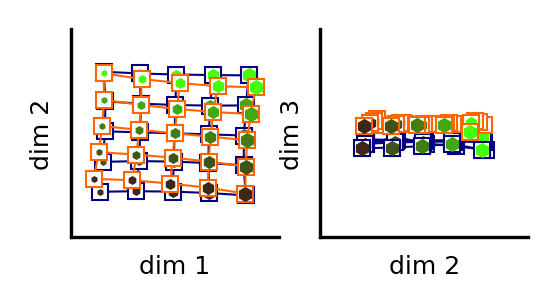

In [7]:
with open(data_dir + 'mds_embedding_leftEVC.pickle','rb') as f:
        xyz = pickle.load(f)
# plot results
%matplotlib inline
xyz_rot = rotate(xyz,0,axis='x')
xyz_rot = rotate(xyz_rot,0,axis='y')
xyz_rot = rotate(xyz_rot,0,axis='z')

mm = 1/25.4
fig = plt.figure(1,figsize=(50*mm, 25*mm), dpi=300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=1,axlims=.5,flipdims=True,flipcols=True)

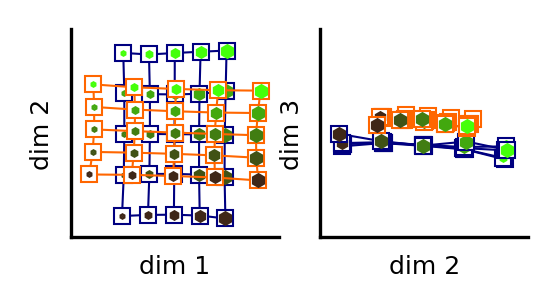

In [8]:
with open(data_dir + 'mds_embedding_DLPFC.pickle','rb') as f:
        xyz = pickle.load(f)
# # plot results
%matplotlib inline
xyz_rot = rotate(xyz,0,axis='x')
xyz_rot = rotate(xyz_rot,0,axis='y')
xyz_rot = rotate(xyz_rot,0,axis='z')

mm = 1/25.4
fig = plt.figure(1,figsize=(50*mm, 25*mm), dpi=300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=1,axlims=.5,flipdims=True,flipcols=True)

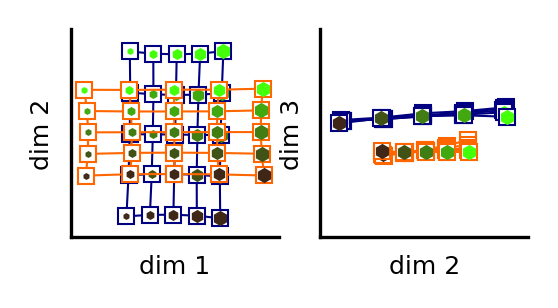

In [9]:
with open(data_dir + 'mds_embedding_ppc.pickle','rb') as f:
        xyz = pickle.load(f)
# plot results
%matplotlib inline
xyz_rot = rotate(xyz,0,axis='x')
xyz_rot = rotate(xyz_rot,0,axis='y')
xyz_rot = rotate(xyz_rot,0,axis='z')

mm = 1/25.4
fig = plt.figure(2,figsize=(50*mm, 25*mm), dpi=300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=.5,flipdims=True,flipcols=True)

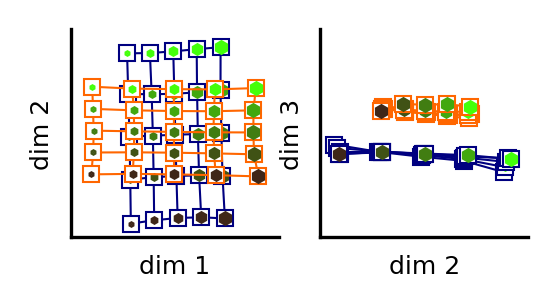

In [10]:
with open(data_dir + 'mds_embedding_mcc.pickle','rb') as f:
        xyz = pickle.load(f)
# plot results
%matplotlib inline
xyz_rot = rotate(xyz,0,axis='x')
xyz_rot = rotate(xyz_rot,0,axis='y')
xyz_rot = rotate(xyz_rot,0,axis='z')

mm = 1/25.4
fig = plt.figure(2,figsize=(50*mm, 25*mm), dpi=300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=.5,flipdims=True,flipcols=True)

EVC Compression North: z=2.25, p=0.0242, Compression South: z=4.10, p=0.0000 
EVC Offset: z=4.86, p=0.0000 
EVC Angle: z=1.49, p=0.1364 
PPC Compression North: z=4.80, p=0.0000, Compression South: z=4.84, p=0.0000 
PPC Offset: z=4.86, p=0.0000 
PPC Angle: z=0.53, p=0.5967 
MCC Compression North: z=4.84, p=0.0000, Compression South: z=4.80, p=0.0000 
MCC Offset: z=4.86, p=0.0000 
MCC Angle: z=0.27, p=0.7838 
dlPFC Compression North: z=4.53, p=0.0000, Compression South: z=4.86, p=0.0000 
dlPFC Offset: z=4.86, p=0.0000 
dlPFC Angle: z=1.14, p=0.2557 


## 4D: fMRI brainbehav corrs

In [25]:
data_dir = dir_results_humanfmri + 'ROIs/'

In [26]:
# load behav data
behav_scores = loadmat(dir_results_humanbehav + 'behav_task_factorisation_betas.mat')['behav_scores']

Text(0.4, 0.07, 'p=0.457')

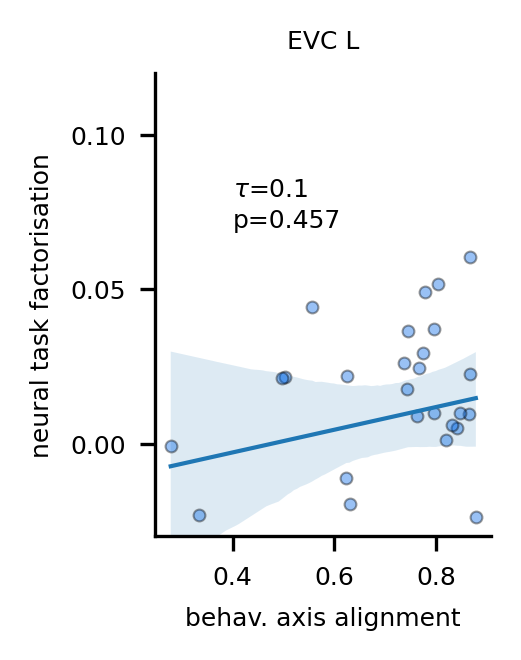

In [28]:
#1. left evc 
# load data 
neuro_scores = loadmat(data_dir + 'neuro_task_factorisation_all7mods_leftEVC.mat')['neuro_scores']

data_dict = {'x':behav_scores.flatten(),'y':neuro_scores.flatten()}
data = pd.DataFrame(data_dict)

mm = 1/25.4
%matplotlib inline
f = plt.figure(figsize=(55*mm,60*mm),dpi=300)
ax = plt.gca()

_ = sns.regplot(x='x',y='y',data=data,x_ci='ci',ci=95,ax=ax,scatter=False,line_kws={'linewidth':1})
sns.despine()

plt.scatter(data_dict['x'],data_dict['y'],color=(0,.4,.9),alpha=0.4,s=8,edgecolors='k',linewidth=0.5)
plt.xlabel('behav. axis alignment',fontsize=6)
plt.ylabel('neural task factorisation',fontsize=6)
plt.title('EVC L',fontsize=6)
plt.tight_layout()
t,p = kendalltau(behav_scores,neuro_scores)
t = np.round(t,2)
p = np.round(p,3)
plt.ylim([-0.03,0.12])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xticks([.4,.6,.8])
plt.text(0.4,0.08,r'$\tau$=' + str(t),fontsize=6)
plt.text(0.4,0.07,'p=' + str(p),fontsize=6)


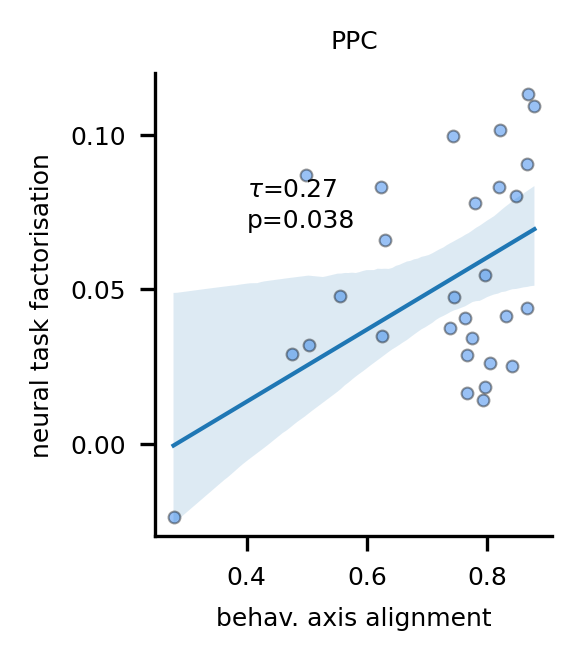

In [30]:
#2. parietal 
# load data 
neuro_scores = loadmat(data_dir + 'neuro_task_factorisation_all7mods_rightPAR.mat')['neuro_scores']

data_dict = {'x':behav_scores.flatten(),'y':neuro_scores.flatten()}
data = pd.DataFrame(data_dict)
mm = 1/25.4
%matplotlib inline
f = plt.figure(figsize=(55*mm,60*mm),dpi=300)
ax = plt.gca()

_ = sns.regplot(x='x',y='y',data=data,x_ci='ci',ci=95,ax=ax,scatter=False,line_kws={'linewidth':1})


plt.scatter(data_dict['x'],data_dict['y'],color=(0,.4,.9),alpha=0.4,s=8,edgecolors='k',linewidth=0.5)
plt.xlabel('behav. axis alignment',fontsize=6)
plt.ylabel('neural task factorisation',fontsize=6)
plt.title('PPC',fontsize=6)
plt.tight_layout()
t,p = kendalltau(behav_scores,neuro_scores)
t = np.round(t,2)
p = np.round(p,3)
plt.ylim([-0.03,0.12])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xticks([.4,.6,.8])
plt.text(0.4,0.08,r'$\tau$=' + str(t),fontsize=6)
plt.text(0.4,0.07,'p=' + str(p),fontsize=6)
sns.despine()


Text(0.4, 0.07, 'p=0.003')

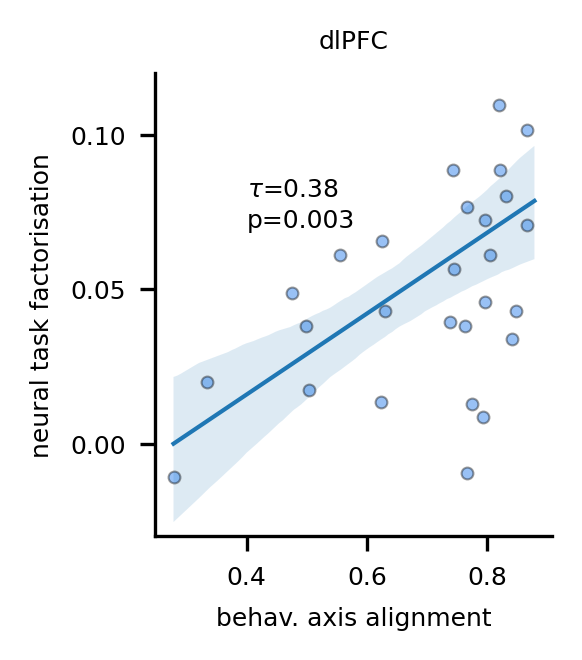

In [31]:
#3. dlpfc 
# load data 
neuro_scores = loadmat(data_dir + 'neuro_task_factorisation_all7mods_rightDLPFC.mat')['neuro_scores']

data_dict = {'x':behav_scores.flatten(),'y':neuro_scores.flatten()}
data = pd.DataFrame(data_dict)
mm = 1/25.4
%matplotlib inline
f = plt.figure(figsize=(55*mm,60*mm),dpi=300)
ax = plt.gca()

_ = sns.regplot(x='x',y='y',data=data,x_ci='ci',ci=95,ax=ax,scatter=False,line_kws={'linewidth':1})
sns.despine()

plt.scatter(data_dict['x'],data_dict['y'],color=(0,.4,.9),alpha=0.4,s=8,edgecolors='k',linewidth=0.5)
plt.xlabel('behav. axis alignment',fontsize=6)
plt.ylabel('neural task factorisation',fontsize=6)
plt.title('dlPFC',fontsize=6)
plt.tight_layout()
t,p = kendalltau(behav_scores,neuro_scores)
t = np.round(t,2)
p = np.round(p,3)
plt.ylim([-0.03,0.12])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xticks([.4,.6,.8])
plt.text(0.4,0.08,r'$\tau$=' + str(t),fontsize=6)
plt.text(0.4,0.07,'p=' + str(p),fontsize=6)

Text(0.4, 0.07, 'p=0.005')

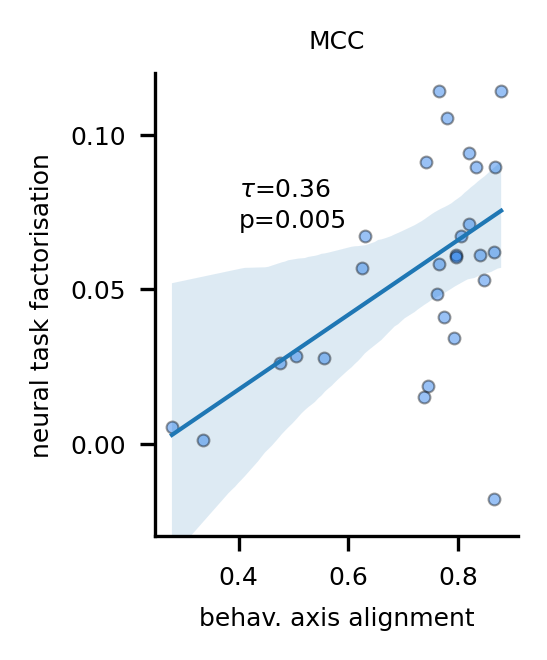

In [32]:
#3. MCC 
# load data 
neuro_scores = loadmat(data_dir + 'neuro_task_factorisation_all7mods_rightMCC.mat')['neuro_scores']

data_dict = {'x':behav_scores.flatten(),'y':neuro_scores.flatten()}
data = pd.DataFrame(data_dict)
mm = 1/25.4
%matplotlib inline
f = plt.figure(figsize=(55*mm,60*mm),dpi=300)
ax = plt.gca()

_ = sns.regplot(x='x',y='y',data=data,x_ci='ci',ci=95,ax=ax,scatter=False,line_kws={'linewidth':1})
sns.despine()

plt.scatter(data_dict['x'],data_dict['y'],color=(0,.4,.9),alpha=0.4,s=8,edgecolors='k',linewidth=0.5)
plt.xlabel('behav. axis alignment',fontsize=6)
plt.ylabel('neural task factorisation',fontsize=6)
plt.title('MCC',fontsize=6)
plt.tight_layout()
t,p = kendalltau(behav_scores,neuro_scores)
t = np.round(t,2)
p = np.round(p,3)
plt.ylim([-0.03,0.12])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xticks([.4,.6,.8])
plt.text(0.4,0.08,r'$\tau$=' + str(t),fontsize=6)
plt.text(0.4,0.07,'p=' + str(p),fontsize=6)

## 4E: fMRI ROI RSA

EVC:
Grid: 	 t= 3.46, 	 p= 0.0008
Rotated Grid: 	 t= 0.93, 	 p= 0.1809
Orthogonal: 	 t= 1.76, 	 p= 0.0442
Parallel: 	 t= -0.75, 	 p= 0.7692
Branchiness: 	 t= 4.74, 	 p= 0.0000
Leafiness: 	 t= -3.43, 	 p= 0.9991
Diagonal: 	 t= -1.20, 	 p= 0.8805
dlPFC:
Grid: 	 t= 0.60, 	 p= 0.2758
Rotated Grid: 	 t= -0.19, 	 p= 0.5746
Orthogonal: 	 t= 8.18, 	 p= 0.0000
Parallel: 	 t= -1.31, 	 p= 0.8999
Branchiness: 	 t= 0.19, 	 p= 0.4259
Leafiness: 	 t= -1.59, 	 p= 0.9388
Diagonal: 	 t= -1.28, 	 p= 0.8949
MCC:
Grid: 	 t= 1.08, 	 p= 0.1448
Rotated Grid: 	 t= 0.82, 	 p= 0.2093
Orthogonal: 	 t= 7.17, 	 p= 0.0000
Parallel: 	 t= -1.88, 	 p= 0.9648
Branchiness: 	 t= -0.50, 	 p= 0.6908
Leafiness: 	 t= -1.26, 	 p= 0.8914
Diagonal: 	 t= -2.18, 	 p= 0.9815
PPC:
Grid: 	 t= 1.31, 	 p= 0.1007
Rotated Grid: 	 t= -0.56, 	 p= 0.7086
Orthogonal: 	 t= 7.77, 	 p= 0.0000
Parallel: 	 t= -1.41, 	 p= 0.9149
Branchiness: 	 t= -0.35, 	 p= 0.6354
Leafiness: 	 t= -2.19, 	 p= 0.9816
Diagonal: 	 t= -2.73, 	 p= 0.9947


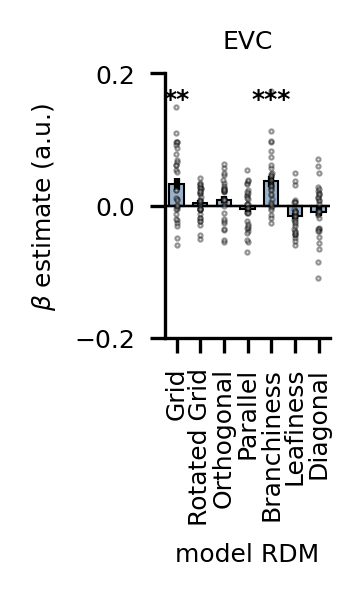

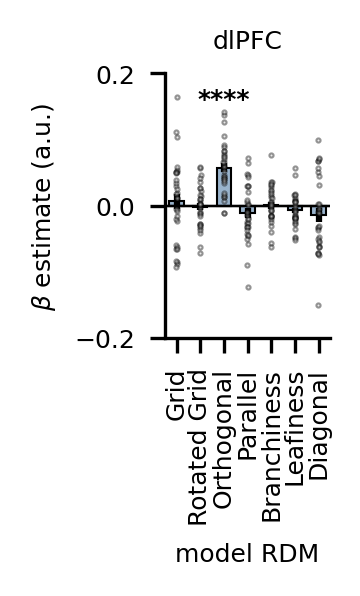

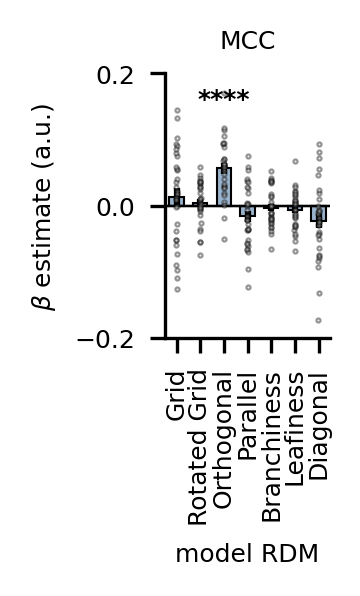

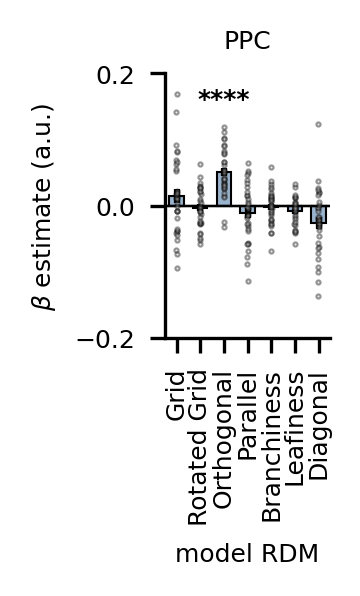

In [36]:
datadir = dir_results_humanfmri + 'ROIs/'
betas = loadmat(datadir+'allbetas_group_rois_toplot.mat')
betas.keys()
betas['betas_evc'] = betas['betas_leftevc']


SMALL_SIZE = 6
MEDIUM_SIZE = 6
BIGGER_SIZE = 6

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plot_roi_betas(betas['betas_evc'],titlestr='EVC')
plt.tight_layout()
plot_roi_betas(betas['betas_dlpfc'],titlestr='dlPFC')
plt.tight_layout()
plot_roi_betas(betas['betas_mcc'],titlestr='MCC')
plt.tight_layout()
plot_roi_betas(betas['betas_ppc'],titlestr='PPC')
plt.tight_layout()

## 4F: Monkey MDS

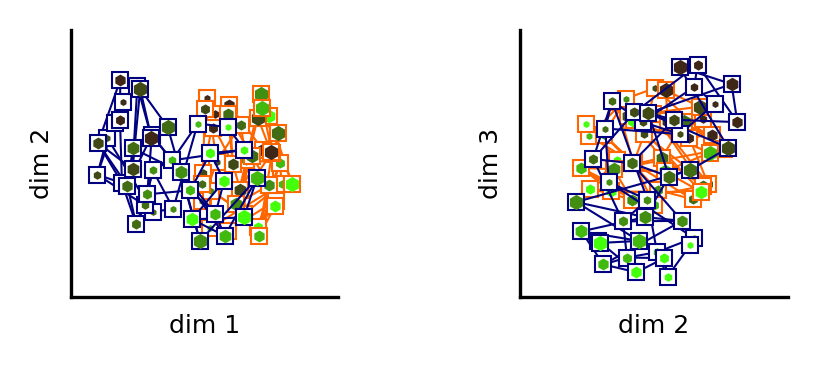

In [68]:
data = loadmat(dir_results_monkeys + 'paper_mante_monkeyA_rdms.mat')
dmat = data['rdms_monkeyA'][0][0][0]
rdm =  data['rdms_monkeyA'][0][0][1]
embedding = MDS(n_components=3,dissimilarity='precomputed',metric=True)
xyz = embedding.fit_transform(rdm)


%matplotlib inline
xyz_rot = rotate(xyz,0,axis='x')
xyz_rot = rotate(xyz_rot,0,axis='y')
xyz_rot = rotate(xyz_rot,0,axis='z')

mm = 1/25.4
fig = plt.figure(1,figsize=(90*mm, 30*mm), dpi=300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=1,axlims=.5,flipdims=True,monk=True)

for ii in range(1,3):
    plt.subplot(1,2,ii)
    plt.xlim((-.2,.2))
    plt.ylim((-.2,.2))



## 4G Monkey RSA

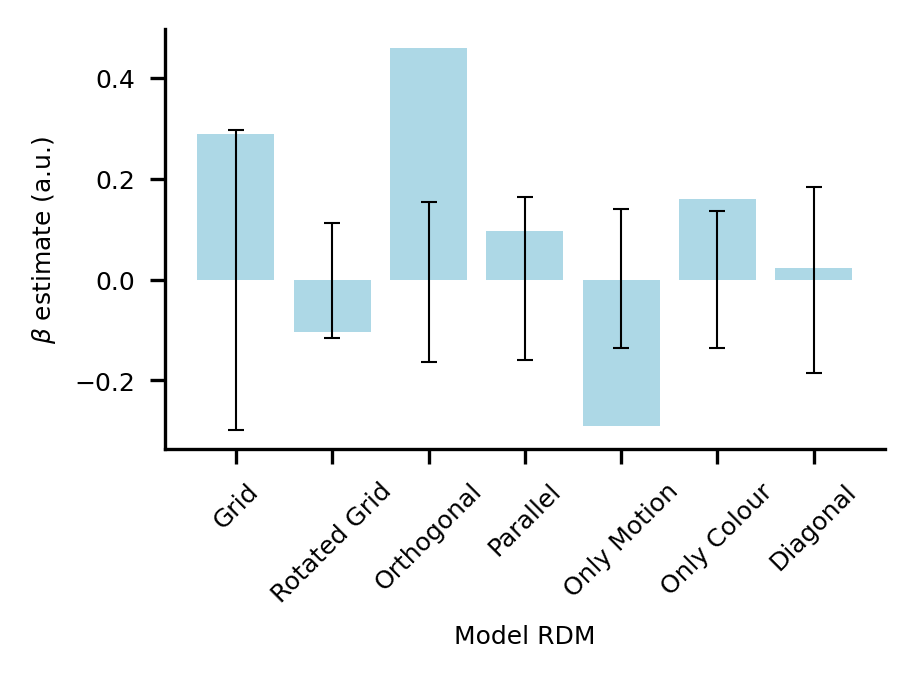

In [105]:
#todo
betas = loadmat(dir_results_monkeys + 'paper_mante_monkeyA_betas.mat')
betas_perm = loadmat(dir_results_monkeys + 'paper_mante_monkeyA_betas_perm.mat')
b = betas['betas'].flatten()
bp = betas_perm['betas_perm']

mm = 1/25.4
f =plt.figure(1,figsize=(80*mm,60*mm),dpi=300)
plt.bar(np.arange(7),b,color='lightblue',edgecolor=None,linewidth=0.5)
for ii in range(7):
    plt.errorbar(ii,np.mean(bp[:,ii],0),np.std(bp[:,ii],0)*2,color='k',capsize=2,elinewidth=0.5,capthick=0.5)
plt.xlabel('Model RDM')
plt.ylabel(r'$\beta$ estimate (a.u.)')
plt.xticks(ticks=np.arange(7),labels=['Grid','Rotated Grid', 'Orthogonal','Parallel','Only Motion','Only Colour','Diagonal'],rotation=45)
sns.despine()
plt.tight_layout()

# Figure 5

## 5B: Gating Theory

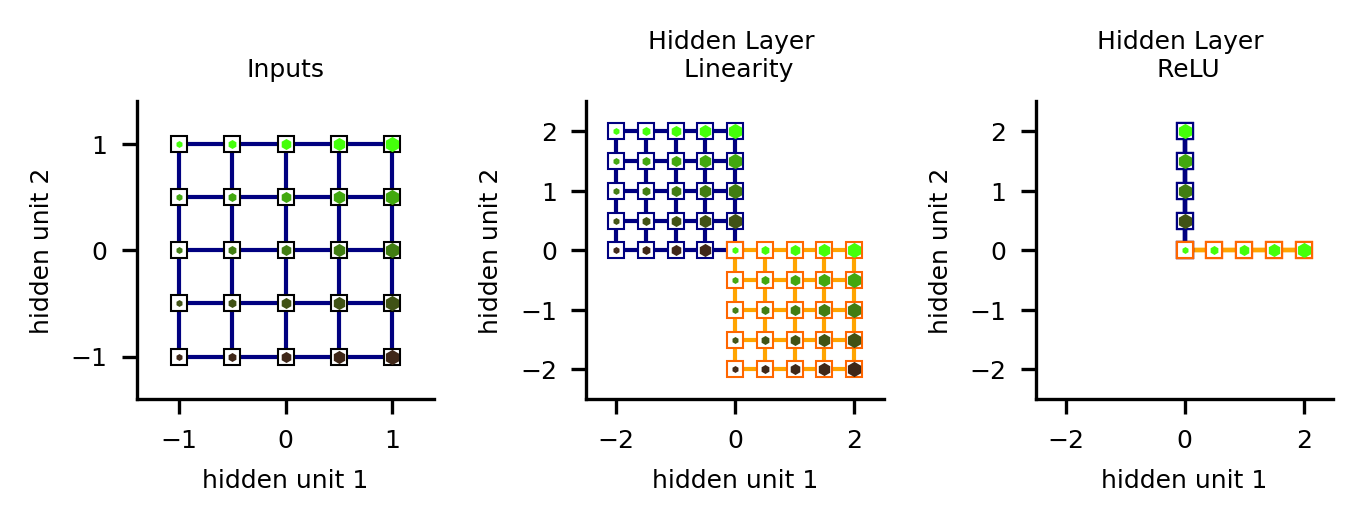

In [113]:
# subplots: centered grid, displaced grids, relu gate, relu gate with gradient
a,b = np.meshgrid(np.linspace(-1,1,5),np.linspace(-1,1,5))
a = a.flatten()
b = b.flatten()
xyz = np.stack((a,b),axis=1)

mm = 1/25.4
plt.figure(1, figsize=(120*mm,60*mm),dpi=300)
# input space 
plt.subplot(1,3,1)
plot_grid2(xyz[0:25,],line_colour=(0, 0, .5),fig_id=1)
scatter_mds_2(xyz,fig_id=1,task_id='avg')
plt.xlabel('hidden unit 1',fontsize=6)
plt.ylabel('hidden unit 2',fontsize=6)
plt.title('Inputs',fontsize=6)
plt.xlim(-1.4,1.4)
plt.ylim(-1.4,1.4)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax = plt.gca()
ax.set_aspect('equal','box')

# hidden layer, linearity 
plt.subplot(1,3,2)
xyz1 = np.copy(xyz)
xyz1[:,0] -=1
xyz1[:,1] +=1
xyz2 = np.copy(xyz)
xyz2[:,1] -=1
xyz2[:,0] +=1
plot_grid2(xyz1,line_colour=(0, 0, .5),fig_id=1)
plot_grid2(xyz2,line_colour='orange',fig_id=1)
scatter_mds_2(xyz1,fig_id=1,task_id='b',flipdims=False)
scatter_mds_2(xyz2,fig_id=1,task_id='a',flipdims=False)
plt.xlabel('hidden unit 1',fontsize=6)
plt.ylabel('hidden unit 2',fontsize=6)
plt.title('Hidden Layer \n Linearity',fontsize=6)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax = plt.gca()
ax.set_aspect('equal','box')

# hidden layer, ReLU
plt.subplot(1,3,3)
plot_grid2(np.maximum(0,xyz1),line_colour=(0, 0, .5),fig_id=1)
plot_grid2(np.maximum(0,xyz2),line_colour='orange',fig_id=1)
scatter_mds_2(np.maximum(0,xyz1),fig_id=1,task_id='b',flipdims=False)
scatter_mds_2(np.maximum(0,xyz2),fig_id=1,task_id='a',flipdims=False)
plt.xlabel('hidden unit 1',fontsize=6)
plt.ylabel('hidden unit 2',fontsize=6)
plt.title('Hidden Layer \n ReLU',fontsize=6)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax = plt.gca()
ax.set_aspect('equal','box')


ax = plt.gca()
ax.set_aspect('equal','box')
plt.tight_layout()
sns.despine()

# Figure 6

## 6A: Average Unit Selectivity

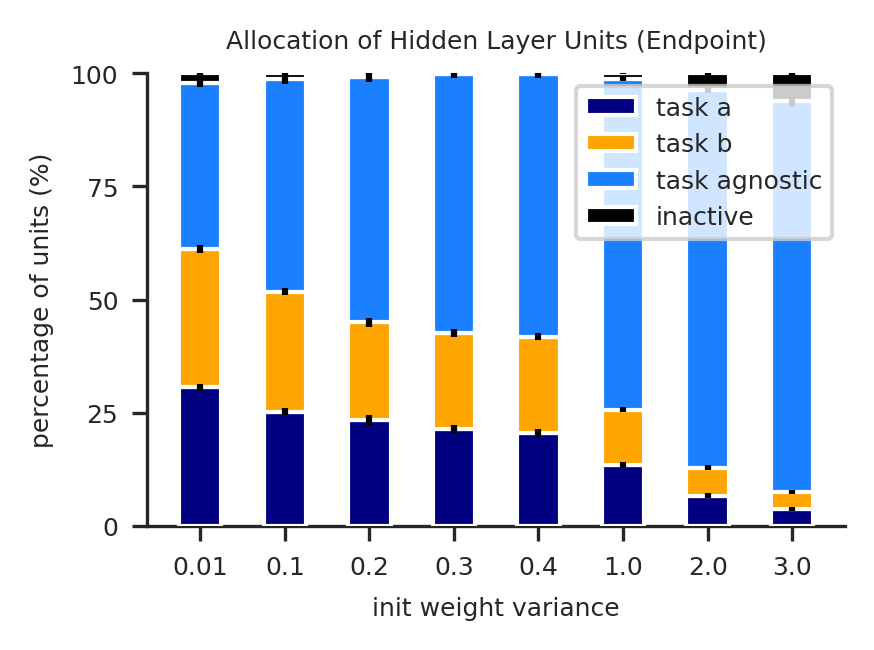

In [148]:
# load data
N_STIM = 25
N_CTX = 2
N_HIDDEN = 100
N_OUT = 1
N_RUNS = 20
N_ITER = 10000
LRATE = 5e-3
SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])

N_FACTORS = len(SCALE_WHXS)
scale_labels = [str(ii) for ii in SCALE_WHXS]

with open(dir_results_simus + 'results_mlp_gating.pkl','rb') as f:
        results = pickle.load(f)


# Sparsity of hidden layer - endpoint
%matplotlib inline
plt.figure(figsize=(3,2),dpi=300)
# task A and b units
coeffs_mu_a = np.mean(results['n_only_a'][:,:,1],1)/N_HIDDEN
coeffs_err_a = np.std(results['n_only_a'][:,:,1],1)/np.sqrt(results['n_only_a'][:,:,1].shape[1])
coeffs_err_a /= np.asarray(N_HIDDEN)
ha = plt.bar(np.arange(0,coeffs_mu_a.shape[0]),coeffs_mu_a,color=(0, 0,0.5),yerr=coeffs_err_a,width=0.5,zorder=3)


coeffs_mu_b = np.mean(results['n_only_b'][:,:,1],1)/N_HIDDEN
coeffs_err_b = np.std(results['n_only_b'][:,:,1],1)/np.sqrt(results['n_only_b'][:,:,1].shape[1])
coeffs_err_b /= np.asarray(N_HIDDEN)
hb = plt.bar(np.arange(0,coeffs_mu_b.shape[0]),coeffs_mu_b,color='orange',bottom=coeffs_mu_a,width=0.5,yerr=coeffs_err_b,zorder=3)


coeffs_mu_m = np.mean(N_HIDDEN-results['n_local'][:,:,1]-results['n_dead'][:,:,1],1)/N_HIDDEN
coeffs_err_m = np.std(N_HIDDEN-results['n_local'][:,:,1]-results['n_dead'][:,:,1],1)/np.sqrt(results['n_dead'][:,:,1].shape[1])
coeffs_err_m /= np.asarray(N_HIDDEN)
hm = plt.bar(np.arange(0,coeffs_mu_m.shape[0]),coeffs_mu_m,color=(0.1,0.5,1),bottom=coeffs_mu_b+coeffs_mu_a,width=0.5,yerr=coeffs_err_m,zorder=3)


coeffs_mu_d = np.mean(results['n_dead'][:,:,1],1)/N_HIDDEN
coeffs_err_d = np.std(results['n_dead'][:,:,1],1)/np.sqrt(results['n_dead'][:,:,1].shape[1])
coeffs_err_d /= np.asarray(N_HIDDEN)
hd = plt.bar(np.arange(0,coeffs_mu_d.shape[0]),coeffs_mu_d,color=[0,0,0],bottom=coeffs_mu_m+coeffs_mu_b+coeffs_mu_a,width=0.5,yerr=coeffs_err_d,zorder=3)

plt.legend([ha,hb,hm,hd],['task a', 'task b','task agnostic', 'inactive'],fontsize=6,frameon=True,loc=1)
plt.ylim([0,1])

plt.yticks(ticks=np.arange(0,1.25,.25))
plt.yticks(ticks=np.arange(0,1.25,.25),labels=tuple((plt.yticks()[0]*100).astype('int')))
plt.xticks(ticks=np.arange(0,coeffs_mu_a.shape[0]),labels=scale_labels)
plt.ylabel('percentage of units (%)',fontsize=6)
plt.xlabel('init weight variance',fontsize=6)

plt.title('Allocation of Hidden Layer Units (Endpoint)',fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


## 6B-D: Context Weight Correlations

In [145]:
# load data
N_STIM = 25
N_CTX = 2
N_HIDDEN = 100
N_OUT = 1
N_RUNS = 30
N_ITER = 10000
LRATE = 5e-3
SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])

N_FACTORS = len(SCALE_WHXS)
scale_labels = [str(ii) for ii in SCALE_WHXS]
# open results (was 'results_nnet_main_withacc_withmlp_stepscaled.pickle)
with open(dir_results_simus+'/results_mlp_main.pkl','rb') as f:
        results = pickle.load(f)
        
%matplotlib qt
cmap = sns.color_palette("crest", as_cmap=True).colors
sns.set_style('ticks')
corrs = np.empty((4,2,8,N_RUNS))
for ii in range(8):
    for jj in range(N_RUNS):
        yout = results['all_y_hidden'][ii,jj,:,:]
        x = np.vstack((np.nanmean(yout[:,0:25],1).T,np.nanmean(yout[:,25:],1).T))
        # local units
        mask_local = ~(np.all(x,axis=0)) & np.any(x,axis=0)
        mask_a = np.all(np.vstack((x[0,:]>0,x[1,:]==0)),axis=0)
        mask_b = np.all(np.vstack((x[0,:]==0,x[1,:]>0)),axis=0) 
        corrs[0,0,ii,jj] = np.corrcoef(results['w_hxc_0'][ii,jj,mask_local==1,:].T)[0,1]
        corrs[0,1,ii,jj] = np.corrcoef(results['all_w_hxc'][ii,jj,mask_local==1,:].T)[0,1]
        corrs[1,0,ii,jj] = np.corrcoef(results['w_hxc_0'][ii,jj,~mask_local==1,:].T)[0,1]
        corrs[1,1,ii,jj] = np.corrcoef(results['all_w_hxc'][ii,jj,~mask_local==1,:].T)[0,1]
        corrs[2,0,ii,jj] = np.corrcoef(results['w_hxc_0'][ii,jj,:,:].T)[0,1]
        corrs[2,1,ii,jj] = np.corrcoef(results['all_w_hxc'][ii,jj,:,:].T)[0,1]
        
# d = pd.DataFrame(data=corrs[0,:,:].T,index=['run ' + str(i) for i in range(len(corrs[0,:,:].T))],columns=['sigma '+ str(i) for i in range(len(corrs[0,:,:]))])

plt.figure(figsize=(10,3))
# all
plt.subplot(1,3,1)
a1 = sns.kdeplot(data=corrs[2,0,0,:],fill=False, linewidth=1,color='k',linestyle='--',label='init')
a2 = sns.kdeplot(data=corrs[2,0,0,:],fill=True,alpha=.2, linewidth=0,color=cmap[0])
b1 = sns.kdeplot(data=corrs[2,1,0,:],fill=False, linewidth=2,color='k',linestyle='-',label='endpoint')
b2 = sns.kdeplot(data=corrs[2,1,0,:],fill=True,alpha=.8, linewidth=0,color=cmap[0])
plt.plot([corrs[2,0,0,:],corrs[2,0,0,:]],[0,1],'k',linestyle=':')
plt.plot([corrs[2,1,0,:],corrs[2,1,0,:]],[0,1],'k')
plt.xlabel('correlation of ctx weights')
plt.xlim(-1,1)
plt.ylim(0,7)
plt.title('All Units',fontweight='normal')
plt.legend(frameon=False)
# local 
plt.subplot(1,3,2)
a1 = sns.kdeplot(data=corrs[0,0,0,:],fill=False, linewidth=1,color='k',linestyle='--',label='init')
a2 = sns.kdeplot(data=corrs[0,0,0,:],fill=True,alpha=.2, linewidth=0,color=cmap[100])
b1 = sns.kdeplot(data=corrs[0,1,0,:],fill=False, linewidth=2,color='k',linestyle='-',label='endpoint')
b2 = sns.kdeplot(data=corrs[0,1,0,:],fill=True,alpha=.8, linewidth=0,color=cmap[100])
plt.plot([corrs[0,0,0,:],corrs[0,0,0,:]],[0,1],'k',linestyle=':')
plt.plot([corrs[0,1,0,:],corrs[0,1,0,:]],[0,1],'k')
plt.xlabel('correlation of ctx weights')
plt.xlim(-1,1)
plt.ylim(0,7)
plt.title('Only Task Selective Units',fontweight='normal')
plt.legend(frameon=False)
# mixed units 
plt.subplot(1,3,3)
a1 = sns.kdeplot(data=corrs[1,0,0,:],fill=False, linewidth=1,color='k',linestyle='--',label='init')
a2 = sns.kdeplot(data=corrs[1,0,0,:],fill=True,alpha=.2, linewidth=0,color=cmap[210])
b1 = sns.kdeplot(data=corrs[1,1,0,:],fill=False, linewidth=2,color='k',linestyle='-',label='endpoint')
b2 = sns.kdeplot(data=corrs[1,1,0,:],fill=True,alpha=.8, linewidth=0,color=cmap[210])
plt.plot([corrs[1,0,0,:],corrs[1,0,0,:]],[0,1],'k',linestyle=':')
plt.plot([corrs[1,1,0,:],corrs[1,1,0,:]],[0,1],'k')
plt.xlabel('correlation of ctx weights')
plt.xlim(-1,1)
plt.ylim(0,7)
plt.title('Only Mixed Selective Units',fontweight='normal')
plt.legend(frameon=False)


sns.despine()

plt.tight_layout()


## 6E: Monkey Unit Selectivity

In [ ]:
# MATLAB

## 6F: Unit Heatmaps

In [ ]:
# load data
N_STIM = 25
N_CTX = 2
N_HIDDEN = 100
N_OUT = 1
N_RUNS = 30
N_ITER = 10000
LRATE = 5e-3
SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])

N_FACTORS = len(SCALE_WHXS)
scale_labels = [str(ii) for ii in SCALE_WHXS]
with open(dir_results_simus+'mlp/results_mlp_main.pkl','rb') as f:
    results = pickle.load(f)

y_mixed = np.empty((N_RUNS,50))
y_local = np.empty((N_RUNS,50))


for ii in range(N_RUNS):
    yout = results['all_y_hidden'][0,ii,:,:]
    x = np.vstack((np.nanmean(yout[:,0:25],1).T,np.nanmean(yout[:,25:],1).T))
    # local units
    mask_local = ~(np.all(x,axis=0)) & np.any(x,axis=0)
    mask_a = np.all(np.vstack((x[0,:]>0,x[1,:]==0)),axis=0)
    mask_b = np.all(np.vstack((x[0,:]==0,x[1,:]>0)),axis=0)    
    y_local[ii,:] =np.concatenate((np.nanmean(yout[mask_a,:25],0),np.nanmean(yout[mask_b,25:],0)),axis=0)
    # mixed units: not local
    mask_mixed = np.all(x,axis=0)#~mask_local 
    y_mixed[ii,:] = np.nanmean(yout[mask_mixed,:],0)
plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.nanmean(y_mixed[:,:25],0).reshape(5,5),cmap='viridis')
plt.title('Mixed Selective Units \n Avg. Response to Task A')
plt.xlabel('relevant dimension')
plt.ylabel('irrelevant dimension')
plt.clim(0,0.05)
plt.colorbar(label='mean activitiy')

plt.subplot(2,2,2)
plt.imshow(np.nanmean(y_mixed[:,25:],0).reshape(5,5),cmap='viridis')
plt.title('Mixed Selective Units \n Avg. Response to Task B')
plt.xlabel('irrelevant dimension')
plt.ylabel('relevant dimension')
plt.clim(0,0.05)
plt.colorbar(label='mean activitiy')

plt.subplot(2,2,3)
plt.imshow(np.nanmean(y_local[:,:25],0).reshape(5,5),cmap='viridis')
plt.title('Task A Selective Units \n Avg. Response to Task A')
plt.xlabel('relevant dimension')
plt.ylabel('irrelevant dimension')
plt.clim(0,0.07)
plt.colorbar(label='mean activitiy')
plt.subplot(2,2,4)
plt.imshow(np.nanmean(y_local[:,25:],0).reshape(5,5),cmap='viridis')
plt.title('Task B Selective Units \n Avg. Response to Task B')
plt.xlabel('irrelevant dimension')
plt.ylabel('relevant dimension')
plt.clim(0,0.07)
plt.colorbar(label='mean activitiy')

plt.tight_layout()


## 6G: Unit RSA

In [10]:
def gen_behav_models():
    modelrdms = np.empty((2,50,50))
    # factorised model:
    a,b = np.meshgrid(np.linspace(-2,2,5),np.linspace(-2,2,5))
    x = np.concatenate((a.flatten(),b.flatten()),axis=0)[:,np.newaxis]
    modelrdms[0,:,:] = squareform(pdist(x))
    
    # diagonal model 
    x1 = np.zeros((5,5))
    for ii in range(0,3):
        x1[np.triu_indices(5,k=ii)] = ii
    x1 = np.flipud(np.tril(np.flipud(np.fliplr(np.triu(x1))))*-1 + x1)    
    x = np.concatenate((x1.flatten(),x1.flatten()),axis=0)[:,np.newaxis]    
    modelrdms[1,:,:] = squareform(pdist(x))
   
    rdm1 = modelrdms[0,:,:]
    rdm2 = modelrdms[1,:,:]

    dmat = np.array([zscore(rdm1[np.tril_indices(50,k=-1)].flatten()),zscore(rdm2[np.tril_indices(50,k=-1)].flatten())]).T
    return modelrdms,dmat


def gen_activitymats(results):
    y_mixed = np.empty((N_RUNS,50))
    y_local = np.empty((N_RUNS,50))


    for ii in range(N_RUNS):
        yout = results['all_y_hidden'][0,ii,:,:]
        x = np.vstack((np.nanmean(yout[:,0:25],1).T,np.nanmean(yout[:,25:],1).T))
        # local units
        mask_local = ~(np.all(x,axis=0)) & np.any(x,axis=0)
        mask_a = np.all(np.vstack((x[0,:]>0,x[1,:]==0)),axis=0)
        mask_b = np.all(np.vstack((x[0,:]==0,x[1,:]>0)),axis=0)    
        y_local[ii,:] =np.concatenate((np.nanmean(yout[mask_a,:25],0),np.nanmean(yout[mask_b,25:],0)),axis=0)
        # mixed units: not local
        mask_mixed = np.all(x,axis=0)#~mask_local 
        y_mixed[ii,:] = np.nanmean(yout[mask_mixed,:],0)
    return y_local, y_mixed
# gen_behav_models(1)

# gen average unit activity matrices
y_local,y_mixed = gen_activitymats(results)
# generate and display model matrices 
modrdms,dmat = gen_behav_models()
# loop over runs and regress activity rdms against model rdms
regr = linear_model.LinearRegression()
betas_task = []
betas_mixed = []
for ii in range(y_local.shape[0]):
    # construct rdm 
    yt = zscore(squareform(pdist(y_local[ii,:].reshape((-1,50)).T))[np.tril_indices(50,k=-1)].flatten())
    ym = zscore(squareform(pdist(y_mixed[ii,:].reshape((-1,50)).T))[np.tril_indices(50,k=-1)].flatten())
    regr.fit(dmat,yt)
    betas_task.append(regr.coef_)
    regr.fit(dmat,ym)
    betas_mixed.append(regr.coef_)
betas_task = np.asarray(betas_task)
betas_mixed = np.asarray(betas_mixed)   
# display beta values 
betas_mu = np.stack((np.mean(betas_task,0),np.mean(betas_mixed,0)),axis=0)
betas_err = np.stack((np.std(betas_task,0),np.std(betas_mixed,0)),axis=0)/(N_RUNS**.5)

# plot results


mm = 1/25.4
f,ax = plt.subplots(figsize=(70*mm,50*mm),dpi=300) 
width=0.2
b1 = plt.bar(np.asarray([1,2])-width/2,betas_mu[:,0],width,yerr=betas_err[:,0],color=(34/255, 76/255, 128/255))
b2 = plt.bar(np.asarray([1,2])+width/2,betas_mu[:,1],width,yerr=betas_err[:,1],color=(39/255, 107/255, 57/255))
plt.plot(plt.xlim(),np.asarray([0,0]),'k-',linewidth=.5)
ax.set_xticks(np.asarray([1,2]))
ax.set_xticklabels(['task selective','stimulus selective'],fontsize=6)
ax.set_xlabel('Units',fontsize=6)
ax.set_ylabel(r'$\beta$ estimate (a.u.)',fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend([b1,b2],['factorised model','linear model'],frameon=False,fontsize=6)
ax.set_title('Estimated Average Axis Alignment, Hidden Layer',fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
f.tight_layout()


## 6H: Ablation Study

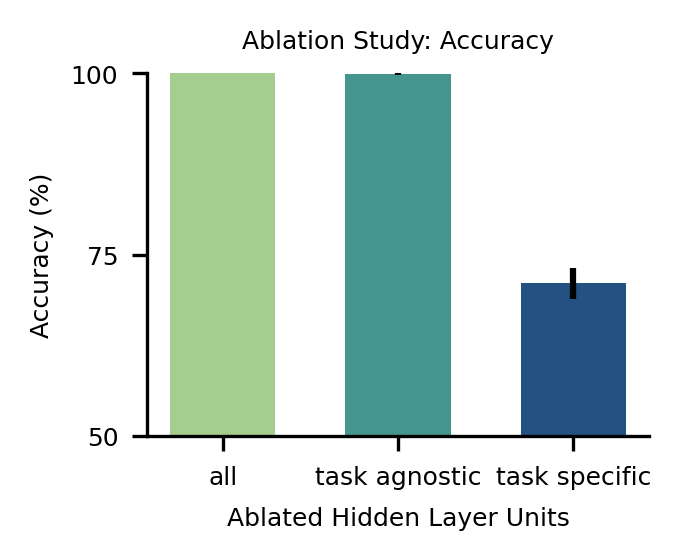

In [12]:

cmap = sns.color_palette("crest", as_cmap=True).colors
accs_mu = np.asarray([np.mean(results['acc_y_ref'][0,:]),np.mean(results['acc_y_local'][0,:]),np.mean(results['acc_y_mixed'][0,:])])
accs_err =np.asarray([np.std(results['acc_y_ref'][0,:])/np.sqrt(results['acc_y_ref'].shape[1]),np.std(results['acc_y_local'][0,:])/np.sqrt(results['acc_y_ref'].shape[1]),np.std(results['acc_y_mixed'][0,:])/np.sqrt(results['acc_y_ref'].shape[1])])

mm = 1/25.4
plt.figure(figsize=(60*mm,50*mm),dpi=300)
plt.bar(0,accs_mu[0],yerr=accs_err[0],color=cmap[0],width=0.6)
plt.bar(1,accs_mu[1],yerr=accs_err[1],color=cmap[100],width=0.6)
plt.bar(2,accs_mu[2],yerr=accs_err[2],color=cmap[210],width=0.6)
plt.title('Ablation Study: Accuracy',fontsize=6)
plt.xticks(ticks=np.arange(3),labels=('all','task agnostic', 'task specific'),fontsize=6)
plt.xlabel('Ablated Hidden Layer Units',fontsize=6)
plt.ylabel('Accuracy (%)',fontsize=6)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(np.arange(0,1.1,0.25),labels=np.arange(0,110,25),fontsize=6)
plt.xticks(fontsize=6)
plt.ylim(.5,1)
plt.tight_layout()

## 6I: Monkey Unit Heatmaps

In [ ]:
# MATLAB

## 6J: Monkey Unit RSA

In [13]:
datadir= dir_results_monkeys
results = loadmat(datadir+'unitselectivity_betas.mat')
betas_task = results['betas_task']
betas_mixed = results['betas_mixed']


# display beta values 
betas_mu = np.stack((np.mean(betas_task,0),np.mean(betas_mixed,0)),axis=0)
betas_err = np.stack((np.std(betas_task,0),np.std(betas_mixed,0)),axis=0)/(betas_mixed.shape[0]**.5)

# plot results


mm = 1/25.4
f,ax = plt.subplots(figsize=(70*mm,50*mm),dpi=300) 
width=0.2
b1 = plt.bar(np.asarray([1,2])-width/2,betas_mu[:,0],width,yerr=betas_err[:,0],color=(34/255, 76/255, 128/255))
b2 = plt.bar(np.asarray([1,2])+width/2,betas_mu[:,1],width,yerr=betas_err[:,1],color=(39/255, 107/255, 57/255))
plt.plot(plt.xlim(),np.asarray([0,0]),'k-',linewidth=.5)
ax.set_xticks(np.asarray([1,2]))
ax.set_xticklabels(['task specific','task agnostic'],fontsize=6)
ax.set_xlabel('Units',fontsize=6)
ax.set_ylabel(r'$\beta$ estimate (a.u.)',fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend([b1,b2],['factorised model','linear model'],frameon=False,fontsize=6)
ax.set_title('Estimated Average Axis Alignment, \n Monkey A',fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
f.tight_layout()


# SUPPLEMENTARY MATERIAL

## Figure S1
see matlab code

In [14]:
# matlab

## Figure S2

### S2B-D: Impact of learning rate

iter at which ceiling is hit: [4035, 2360, 1370, 1002, 832, 821, 3116, 1939, 10000, 10000]
faster than lazy learning (times): [0.4  0.24 0.14 0.1  0.08 0.08 0.31 0.19 1.   1.  ]


<Figure size 432x288 with 0 Axes>

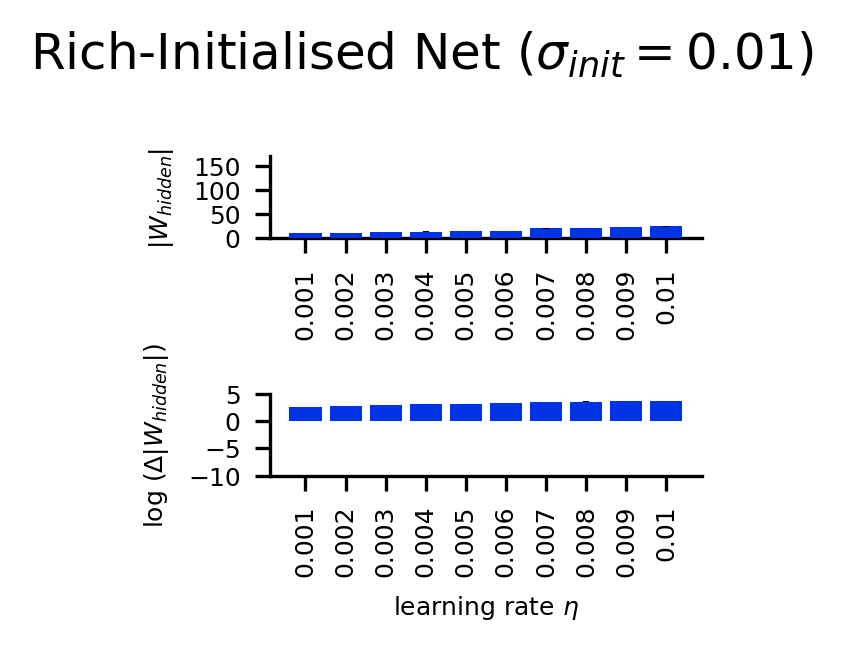

In [17]:
LRATE = np.asarray([1e-3,2e-3,3e-3,4e-3,5e-3,6e-3,7e-3,8e-3,9e-3,1e-2])

def plot_norms(norms,titlestr,zorder=1,colors=np.repeat([1,0,0],len(LRATE),axis=0)):
    for ii in range(len(LRATE)):
        plt.bar(ii,np.mean(norms[ii,:],0),yerr=np.std(norms[ii,:],0)/np.sqrt(len(norms[ii,:])),zorder=zorder,color=colors[ii,:])
    # plt.title(titlestr,fontsize=14)
    plt.ylabel('norm')
    plt.xticks(ticks=np.arange(0,len(LRATE)),labels=[str(i) for i in LRATE])
    # plt.xlabel('scaling factor')

with open(dir_results_simus + 'mlp/results_mlp_lr.pkl','rb') as f:
    results = pickle.load(f)

%matplotlib inline
# compute how much slower nnet converge compared to lazy learning:

cols = cm.winter(np.linspace(.2,.85,len(LRATE)))
cols = np.array([cols[0]]*10)
is_ceil = []
mm = 1/25.4
fig = plt.figure(figsize=(55*mm,40*mm),dpi=300)
for ii in range(len(LRATE)):
    try:
        this_conv = np.where(np.mean(results['all_accuracies'][ii,:,:],0)==1)[0][0]
    except IndexError:
        this_conv = 10000
    is_ceil.append(this_conv)
    # plt.barh(ii,this_conv,color=cols[ii,:])    
    plt.bar(ii,this_conv,color=cols[ii,:])    


plt.xlabel('learning rate $\eta$',fontsize=6)
plt.ylabel('Episodes until convergence',fontsize=6)
plt.xticks(ticks=np.arange(0,len(LRATE)),labels=LRATE,fontsize=6,rotation=90)
ticks = plt.yticks()[0]
plt.yticks(ticks=ticks,fontsize=6)
ax = plt.gca()
ax.set_ylim((0,10000))
ticks = np.arange(0,10001,2500)
ax.set_yticks(ticks)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'Rich-Initialised Net ($\sigma_{init} = 0.01$)')
plt.show()
plt.tight_layout()
print('iter at which ceiling is hit: ' + str(is_ceil))
xty = np.round(np.asarray([ii/is_ceil[-1] for ii in is_ceil]),2)
print('faster than lazy learning (times): ' + str(xty))




ws = results['w_relchange_hxs'][:,:,-1]
N_RUNS = ws.shape[1]

mm = 1/25.4
fig = plt.figure(figsize=(55*mm,55*mm),dpi=300)

plt.subplot(2,1,1)

norms = np.empty((len(LRATE),N_RUNS))
cols = cm.winter(np.linspace(.2,.85,len(LRATE)))
cols = np.array([cols[0]]*10)
for ii in range(len(LRATE)):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(np.concatenate((results['all_w_hxs'][ii,jj,:,:].flatten(),results['all_w_hxc'][ii,jj,:,:].flatten()),axis=0))

plot_norms(norms,'Endpoint Norms, all weights',zorder=3,colors=cols)
# plt.xticks(ticks=np.arange(0,len(LRATE)),labels=[],fontsize=6)
plt.xticks(ticks=np.arange(0,len(LRATE)),labels=LRATE,fontsize=6,rotation=90)
plt.yticks(ticks=np.arange(0,150,50),fontsize=6)
plt.ylabel(r'$\| W_{hidden}\|$',fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim((0,170))
plt.yticks(ticks=[0,50,100,150])
lims = plt.xlim()
plt.xlim(lims)
plt.tight_layout()


plt.subplot(2,1,2)
for ii in range(ws.shape[0]):
    plt.bar(ii,np.mean(np.log(np.abs(ws[ii,:])),0),yerr=np.std(np.log(np.abs(ws[ii,:])),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])
plt.xticks(ticks=np.arange(0,len(LRATE)),labels=LRATE,fontsize=6,rotation=90)
# ax = plt.gca()
# ax.set_xticklabels(rotation=90)
plt.ylim((-10,5))
plt.yticks([-10,-5,0,5])
plt.yticks(fontsize=6)
plt.ylabel(r'log $\left(\Delta\|W_{hidden}\|\right)$',fontsize=6)
plt.xlabel(r'learning rate $\eta$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle(r'Rich-Initialised Net ($\sigma_{init} = 0.01$)')
plt.tight_layout()


ws = results['w_relchange_hxs'][:,:,-1]
N_RUNS = ws.shape[1]
_, dmat,xyz = gen_modelrdms(monitor=0)

_,c_mu,c_err = stats_fit_rdms(dmat,results['all_y_hidden'])

fig=plt.figure(figsize=(67*(1/25.4), 43*(1/25.4)), dpi=300, facecolor='w', edgecolor='k',linewidth=.5)


plot_rsa_fits(c_mu,c_err,runvalue=LRATE,runlabel=r'learning rate $\eta$',titlestr=r'Rich-initialised net ($\sigma_{init} = 0.01$)')
plt.xticks(ticks=LRATE,labels=LRATE,rotation=90)
plt.xlim((LRATE[0],LRATE[-1]))
plt.ylim((-.1,1))


plt.tight_layout()


iter at which ceiling is hit: [254, 115, 120, 56, 44, 82, 164, 103, 234, 384]
faster than lazy learning (times): [0.66 0.3  0.31 0.15 0.11 0.21 0.43 0.27 0.61 1.  ]


<Figure size 432x288 with 0 Axes>

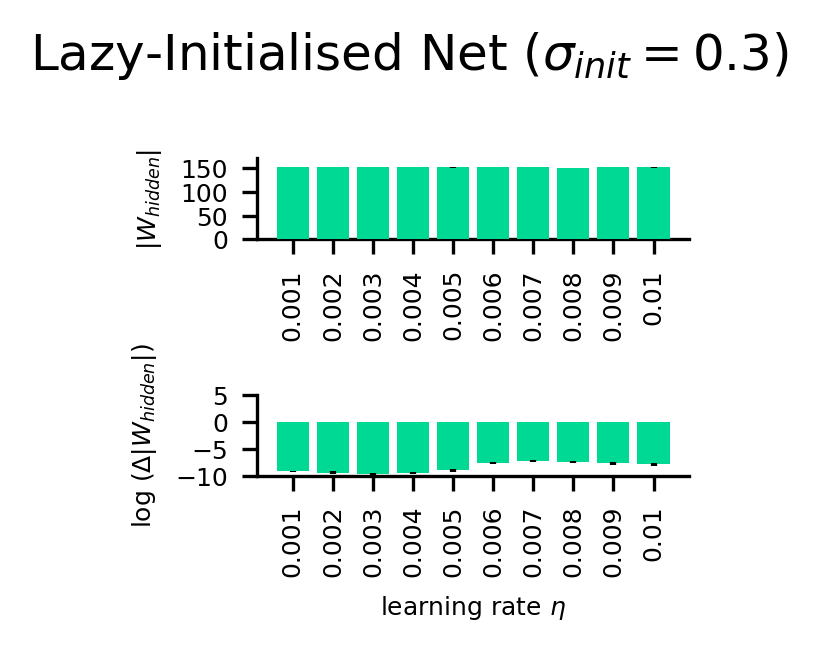

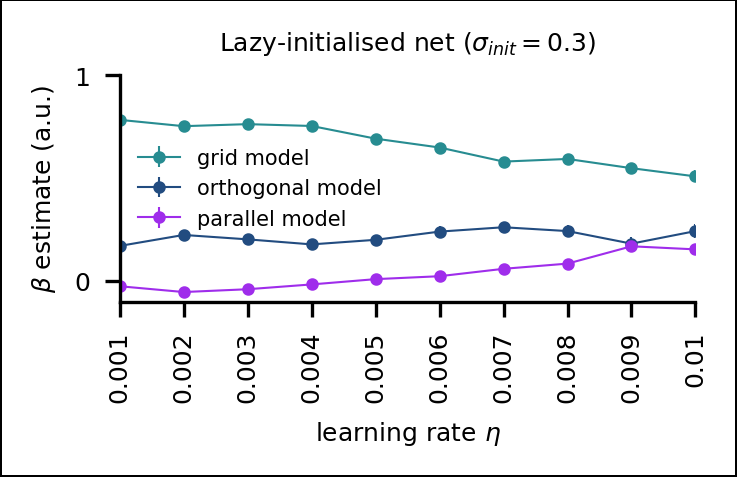

In [19]:

with open(dir_results_simus+'mlp/results_mlp_lr_lazy.pkl','rb') as f:
    results = pickle.load(f)

%matplotlib inline
# compute how much slower nnet converge compared to lazy learning:

cols = cm.winter(np.linspace(.2,.85,len(LRATE)))
cols = np.array([cols[-1]]*10)
is_ceil = []
mm = 1/25.4
fig = plt.figure(figsize=(55*mm,40*mm),dpi=300)
for ii in range(len(LRATE)):
    try:
        this_conv = np.where(np.mean(results['all_accuracies'][ii,:,:],0)==1)[0][0]
    except IndexError:
        this_conv = 10000
    is_ceil.append(this_conv)
    # plt.barh(ii,this_conv,color=cols[ii,:])    
    plt.bar(ii,this_conv,color=cols[ii,:])    


plt.xlabel('learning rate $\eta$',fontsize=6)
plt.ylabel('Episodes until convergence',fontsize=6)
plt.xticks(ticks=np.arange(0,len(LRATE)),labels=LRATE,fontsize=6,rotation=90)
ticks = plt.yticks()[0]
plt.yticks(ticks=ticks,fontsize=6)
ax = plt.gca()
ax.set_ylim((0,10000))
ticks = np.arange(0,10001,2500)
ax.set_yticks(ticks)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'Lazy-Initialised Net ($\sigma_{init} = 0.3$)')
plt.show()
plt.tight_layout()
print('iter at which ceiling is hit: ' + str(is_ceil))
xty = np.round(np.asarray([ii/is_ceil[-1] for ii in is_ceil]),2)
print('faster than lazy learning (times): ' + str(xty))




ws = results['w_relchange_hxs'][:,:,-1]
N_RUNS = ws.shape[1]

mm = 1/25.4
fig = plt.figure(figsize=(55*mm,55*mm),dpi=300)

plt.subplot(2,1,1)

norms = np.empty((len(LRATE),N_RUNS))
cols = cm.winter(np.linspace(.2,.85,len(LRATE)))
cols = np.array([cols[-1]]*10)
for ii in range(len(LRATE)):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(np.concatenate((results['all_w_hxs'][ii,jj,:,:].flatten(),results['all_w_hxc'][ii,jj,:,:].flatten()),axis=0))

plot_norms(norms,'Endpoint Norms, all weights',zorder=3,colors=cols)
# plt.xticks(ticks=np.arange(0,len(LRATE)),labels=[],fontsize=6)
plt.xticks(ticks=np.arange(0,len(LRATE)),labels=LRATE,fontsize=6,rotation=90)
plt.yticks(ticks=np.arange(0,150,50),fontsize=6)
plt.ylabel(r'$\| W_{hidden}\|$',fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim((0,170))
plt.yticks(ticks=[0,50,100,150])
lims = plt.xlim()
plt.xlim(lims)
plt.tight_layout()


plt.subplot(2,1,2)
for ii in range(ws.shape[0]):
    plt.bar(ii,np.mean(np.log(np.abs(ws[ii,:])),0),yerr=np.std(np.log(np.abs(ws[ii,:])),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])
plt.xticks(ticks=np.arange(0,len(LRATE)),labels=LRATE,fontsize=6,rotation=90)
# ax = plt.gca()
# ax.set_xticklabels(rotation=90)
plt.ylim((-10,5))
plt.yticks([-10,-5,0,5])
plt.yticks(fontsize=6)
plt.ylabel(r'log $\left(\Delta\|W_{hidden}\|\right)$',fontsize=6)
plt.xlabel(r'learning rate $\eta$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle(r'Lazy-Initialised Net ($\sigma_{init} = 0.3$)')
plt.tight_layout()


ws = results['w_relchange_hxs'][:,:,-1]
N_RUNS = ws.shape[1]
_, dmat,xyz = gen_modelrdms(monitor=0)

_,c_mu,c_err = stats_fit_rdms(dmat,results['all_y_hidden'])

fig=plt.figure(figsize=(67*(1/25.4), 43*(1/25.4)), dpi=300, facecolor='w', edgecolor='k',linewidth=.5)


plot_rsa_fits(c_mu,c_err,runvalue=LRATE,runlabel=r'learning rate $\eta$',titlestr=r'Lazy-initialised net ($\sigma_{init} = 0.3$)')
plt.xticks(ticks=LRATE,labels=LRATE,rotation=90)
plt.xlim((LRATE[0],LRATE[-1]))
plt.ylim((-.1,1))


plt.tight_layout()

### S2E: L2 regulariser

-0.059415560476289
-0.061979035670125575
-0.06855363682151953
-0.08746451179613184
-0.14123695185025095
-0.28144225776638493
-0.6748012514026157
-8.812484620218603
8
8


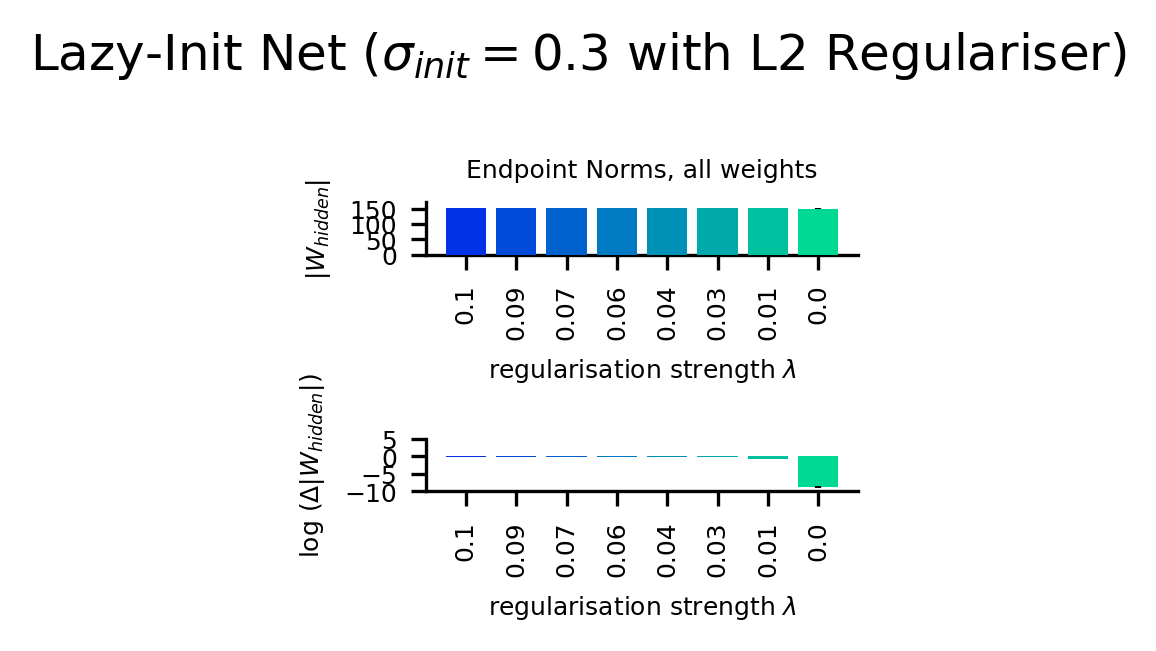

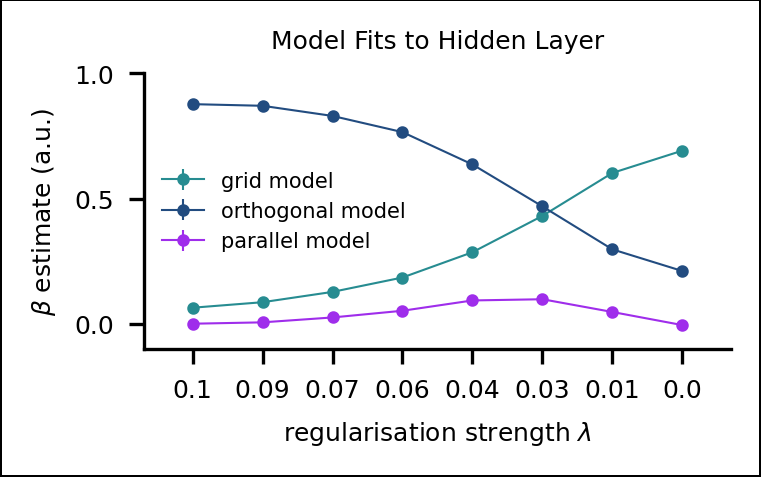

In [27]:
N_RUNS = 20
LAMBDA = np.flip(np.linspace(0,0.1,8))
N_FACTORS = len(LAMBDA)
scale_labels = [str(ii) for ii in np.round(LAMBDA,2)]

def comp_norms(weights):
    norms = np.empty((8,N_RUNS))
    for ii in range(8):
        for jj in range(N_RUNS):
            norms[ii,jj] = np.linalg.norm(weights[ii,jj,:,:].flatten())
    return norms

def plot_norms(norms,titlestr,zorder=1,colors=np.repeat([1,0,0],8,axis=0)):
    for ii in range(8):
        plt.bar(ii,np.mean(norms[ii,:],0),yerr=np.std(norms[ii,:],0)/np.sqrt(len(norms[ii,:])),zorder=zorder,color=colors[ii,:])
    plt.title(titlestr,fontsize=6)
    plt.ylabel('norm')
    plt.xticks(ticks=np.arange(0,8),labels=[str(i) for i in SCALE_WHXS])
    plt.xlabel('scaling factor')


with open(dir_results_simus+'/mlp/results_nnet_l2loss.pickle','rb') as f:
    results = pickle.load(f)

mm = 1/25.4
f = plt.figure(figsize=(55*mm,50*mm),dpi=300)

cols = cm.winter(np.linspace(.2,.85,8))
        
plot_norms(norms,'Endpoint Norms, all weights',zorder=3,colors=cols)
plt.xticks(ticks=np.arange(0,len(LAMBDA)),labels=scale_labels)

plt.ylabel('weight norm',fontsize=6)
plt.xlabel(r'regularisation strength $\lambda$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
lims = plt.xlim()
plt.xlim(lims)

plt.yticks(ticks=np.arange(0,160,50))
plt.tight_layout()


mm = 1/25.4
fig = plt.figure(figsize=(55*mm,55*mm),dpi=300)

plt.subplot(2,1,1)
plot_norms(norms,'Endpoint Norms, all weights',zorder=3,colors=cols)
# plt.xticks(ticks=np.arange(0,len(LRATE)),labels=[],fontsize=6)
plt.xticks(ticks=np.arange(0,len(LAMBDA)),labels=scale_labels,fontsize=6,rotation=90)
plt.yticks(ticks=np.arange(0,150,50),fontsize=6)
plt.ylabel(r'$\| W_{hidden}\|$',fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim((0,170))
plt.yticks(ticks=[0,50,100,150])
lims = plt.xlim()
# plt.ylabel('weight norm',fontsize=6)
plt.xlabel(r'regularisation strength $\lambda$',fontsize=6)
plt.xlim(lims)
plt.tight_layout()

ws = norm_res['w_relchange_hxs'][:,:,-1]
# print(ws.shape)
plt.subplot(2,1,2)
for ii in range(ws.shape[0]):
    print(np.mean(np.log(np.abs(ws[ii,:])),0))
    plt.bar(ii,np.mean(np.log(np.abs(ws[ii,:])),0),yerr=np.std(np.log(np.abs(ws[ii,:])),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])
plt.xticks(ticks=np.arange(0,len(LAMBDA)),labels=scale_labels,fontsize=6,rotation=90)
# ax = plt.gca()
# ax.set_xticklabels(rotation=90)
plt.ylim((-10,5))
plt.yticks([-10,-5,0,5])
plt.yticks(fontsize=6)
plt.ylabel(r'log $\left(\Delta\|W_{hidden}\|\right)$',fontsize=6)

plt.xlabel(r'regularisation strength $\lambda$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle(r'Lazy-Init Net ($\sigma_{init} = 0.3$ with L2 Regulariser)')
plt.tight_layout()


LAMBDA = np.flip(np.linspace(0,0.1,8))
N_FACTORS = len(LAMBDA)
scale_labels = [str(ii) for ii in LAMBDA]

_, dmat,xyz = gen_modelrdms(monitor=0)

_,c_mu,c_err = stats_fit_rdms(dmat,results['all_y_hidden'])
print(len(c_mu))
print(len(c_err))
fig=plt.figure(figsize=(67*(1/25.4), 43*(1/25.4)), dpi=300, facecolor='w', edgecolor='k',linewidth=.5)

  
plot_rsa_fits(c_mu,c_err,runvalue=LAMBDA,runlabel=r'regularisation strength $\lambda$',titlestr='Model Fits to Hidden Layer')
plt.ylim((-.1,1))
plt.xticks(ticks=LAMBDA,labels=np.round(LAMBDA,2))
plt.xlim((0.11,-0.01))

plt.tight_layout()

### S2G-I: RDM LOSS 


In [34]:
N_MODELS = 3
model_labels = ['grid','orthogonal','parallel']
N_RUNS = 10
N_HIDDEN = 100

def mse(y_,y):
    return .5*norm(y_-y,2)**2


r_n, r_s = np.meshgrid(np.linspace(-2, 2, 5),np.linspace(-2, 2, 5))
r_s = r_s.flatten()
r_n = r_n.flatten()
ylabels = np.concatenate((r_n,r_s),axis=0)[:,np.newaxis]
with open(dir_results_simus+'rdmloss/final_blob_mlp_1h_baseline.pickle','rb') as f:
    results_baseline = pickle.load(f)
with open(dir_results_simus+'rdmloss/final_blob_mlp_1h_rdm.pickle','rb') as f:
    results_rdm = pickle.load(f)

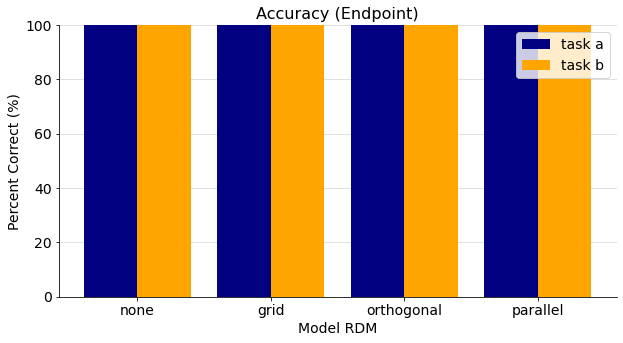

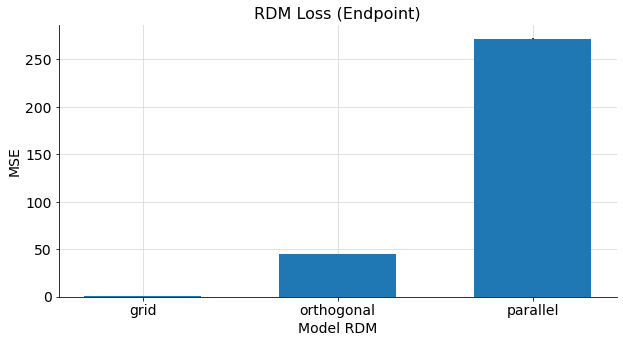

In [37]:
def compute_acc(y_,y):
    return np.mean((y_>.1) == (y>.1))
xlabels = ['none'] + model_labels
# ---------------------------------------------------

# Endpoint training accuracy (each task)
acc_vals_a = np.empty((N_MODELS+1,10))
acc_vals_b = np.empty((N_MODELS+1,10))
for ii in range(0,N_RUNS):
    acc_vals_a[0,ii] = compute_acc(results_baseline['all_y_out'][0,ii,0,0:25][:,np.newaxis],ylabels[0:25])
    acc_vals_b[0,ii] = compute_acc(results_baseline['all_y_out'][0,ii,0,25:][:,np.newaxis],ylabels[25:])

for ii in range(0,N_MODELS):
    for jj in range(0,10):
        acc_vals_a[ii+1,jj] = compute_acc(results_rdm['all_y_out'][ii,jj,0,0:25][:,np.newaxis],ylabels[0:25])
        acc_vals_b[ii+1,jj] = compute_acc(results_rdm['all_y_out'][ii,jj,0,25:][:,np.newaxis],ylabels[25:])
plt.close(3)
plt.figure(3,figsize=(10,5))
plt.bar(np.arange(0,N_MODELS+1)-.2,np.mean(acc_vals_a,1),width=0.4,yerr=np.std(acc_vals_a,1)/np.sqrt(N_RUNS),color=(0,0,.5),zorder=3)
plt.bar(np.arange(0,N_MODELS+1)+.2,np.mean(acc_vals_b,1),width=0.4,yerr=np.std(acc_vals_b,1)/np.sqrt(N_RUNS),color='orange',zorder=3)
plt.xticks(ticks=np.arange(0,N_MODELS+1),labels=xlabels,fontsize=14)
plt.yticks(ticks=plt.yticks()[0],labels=[int(ii) for ii in plt.yticks()[0]*100],fontsize=14)
plt.ylim((0,1))
plt.legend(['task a', 'task b'],fontsize=14)
plt.title('Accuracy (Endpoint)',fontsize=16)
plt.xlabel('Model RDM',fontsize=14)
plt.ylabel('Percent Correct (%)',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig = plt.gcf()
fig.set_size = (10,5)

# rdm loss 
plt.close(4)
plt.figure(4,figsize=(10,5))
plt.bar(np.arange(0,N_MODELS),np.mean(results_rdm['losses_rdm'][:,:,-1],1),yerr=np.std(results_rdm['losses_rdm'][:,:,-1],1)/np.sqrt(N_RUNS),width=0.6,zorder=3)
plt.xticks(ticks=np.arange(0,N_MODELS),labels=model_labels,fontsize=14)
plt.yticks(fontsize=14)
plt.title('RDM Loss (Endpoint)',fontsize=16)
plt.xlabel('Model RDM',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

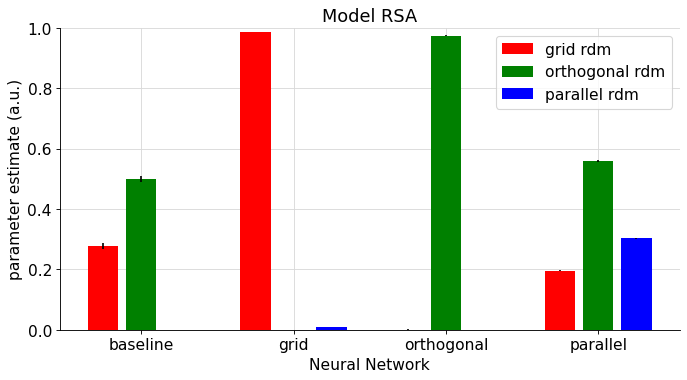

In [39]:

def gen_modelrdms(monitor=0):
    ## model rdms:
    a,b = np.meshgrid(np.linspace(-2,2,5),np.linspace(-2,2,5))
    # grid model
    gridm = np.concatenate((a.flatten()[np.newaxis,:],b.flatten()[np.newaxis,:]),axis=0).T
    ctx = np.concatenate((np.ones((25,1)),0*np.ones((25,1))),axis=0).reshape(50,1)
    gridm = np.concatenate((np.tile(gridm,(2,1)),ctx),axis=1)
    grid_rdm = squareform(pdist(gridm,metric='euclidean'))


    # orthogonal model
    orthm = np.concatenate((np.concatenate((a.flatten()[np.newaxis,:],np.zeros((1,25))),axis=0).T,
                            np.concatenate((np.zeros((1,25)),b.flatten()[np.newaxis,:]),axis=0).T),axis=0)
    orthm = np.concatenate((orthm,ctx),axis=1)
    orth_rdm = squareform(pdist(orthm,metric='euclidean'))


    # parallel model 
    theta = np.radians(-90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    # parm = np.concatenate((R.dot(np.concatenate((a.flatten()[np.newaxis,:],np.zeros((1,25))),axis=0)).T,
                            # np.concatenate((np.zeros((1,25)),b.flatten()[np.newaxis,:]),axis=0).T),axis=0)
    a = a.flatten()
    b = b.flatten()

    ta = np.stack((a,np.zeros((25))),axis=1)
    tb = np.stack((np.zeros(25),b),axis=1)
    theta = np.radians(-90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    parm = np.concatenate((ta.dot(R),tb),axis=0)
    parm = np.concatenate((parm,ctx),axis=1)
    par_rdm = squareform(pdist(parm,metric='euclidean'))
    
    dmat = np.asarray([zscore(grid_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(orth_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(par_rdm[np.tril_indices(50,k=-1)].flatten())]).T
    rdms = np.empty((3,50,50))
    data_orig = np.empty((3,50,3))
    rdms[0] = grid_rdm
    rdms[1] = orth_rdm
    rdms[2] = par_rdm
    data_orig[0,:,:] = gridm 
    data_orig[1,:,:] = orthm 
    data_orig[2,:,:] = parm

    if monitor:
        fig=plt.figure(1,figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
        
        labels = ['grid model', 'orthogonal model', 'parallel model']
        for ii in range(3):
            plt.subplot(2,3,ii+1)
            plt.imshow(rdms[ii])
            plt.title(labels[ii])
        for ii in range(3,6):
            ax = fig.add_subplot(2,3,ii+1,projection='3d')
            embedding = MDS(n_components=3,n_init=10,max_iter=1000)
            xyz = data_orig[ii-3]#embedding.fit_transform(data_orig[ii-3])
                  
            plot_grid3(xyz[0:25,:],line_colour=(0, 0, .5),fig_id=1)
            plot_grid3(xyz[25:,:],line_colour='orange',fig_id=1)
            scatter_mds_3(xyz,fig_id=1,task_id='both')
            
            plt.title(labels[ii-3])

    return rdms,dmat,data_orig


def stats_fit_rdms(dmat,mlp_outputs):
    # stats 

    regr = linear_model.LinearRegression()
    n_runs = mlp_outputs.shape[1]
    n_factors  =mlp_outputs.shape[0]

    coeffs = np.empty((n_factors,n_runs,3))
    # loop through scaling factors 
    for ii in range(n_factors):
        for jj in range(n_runs):
            rdm = squareform(pdist(mlp_outputs[ii,jj,:,:].T,metric='euclidean'))
            y  = zscore(rdm[np.tril_indices(50,k=-1)].flatten())
            regr.fit(dmat,y)
            coeffs[ii,jj,:] = np.asarray(regr.coef_)

    return coeffs


%matplotlib inline
xlabels = ['baseline'] + model_labels
# generate design matrix
_, dmat,xyz = gen_modelrdms(monitor=0)
# concatenate baseline and rdm patterns and run RSA 
mlp_outputs = np.concatenate((results_baseline['all_y_hidden'],results_rdm['all_y_hidden']),axis=0)
coeffs = stats_fit_rdms(dmat,mlp_outputs)
# plot results (coefficients)
coeffs_mu = np.mean(coeffs,1)
coeffs_err = np.std(coeffs,1)/np.sqrt(N_RUNS)
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(0,coeffs_mu.shape[0])-0.25,coeffs_mu[:,0],yerr=coeffs_err[:,0],width=0.2,color='red',zorder=3)
plt.bar(np.arange(0,coeffs_mu.shape[0]),coeffs_mu[:,1],yerr=coeffs_err[:,1],width=0.2,color='green',zorder=3)
plt.bar(np.arange(0,coeffs_mu.shape[0])+0.25,coeffs_mu[:,2],yerr=coeffs_err[:,2],width=0.2,color='blue',zorder=3)
plt.legend(['grid rdm', 'orthogonal rdm', 'parallel rdm'],fontsize=14)
plt.xticks(np.arange(0,4),labels=xlabels,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Neural Network',fontsize=14)
plt.ylabel('parameter estimate (a.u.)',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
plt.title('Model RSA',fontsize=16)
plt.ylim([0,1])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



same as above but for two hidden layers

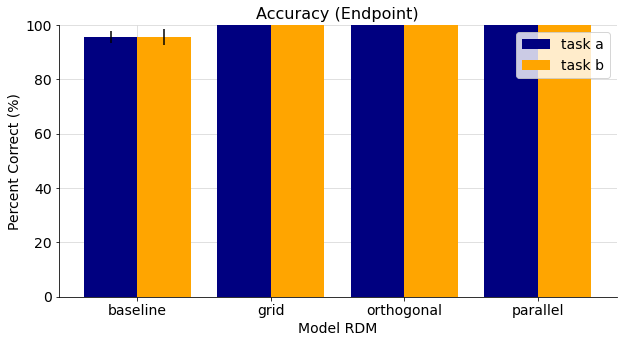

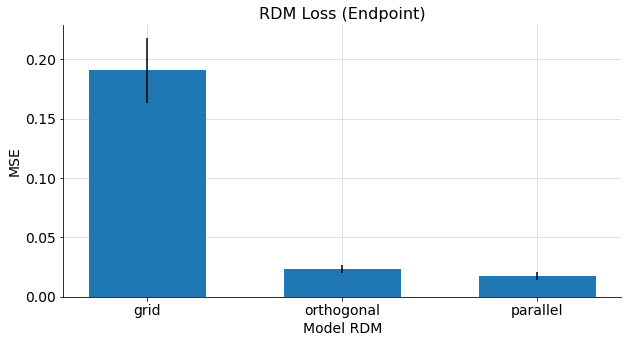

In [42]:
with open(dir_results_simus+'rdmloss//final_blob_mlp_2h_baseline.pickle','rb') as f:
    results_baseline = pickle.load(f)
with open(dir_results_simus+'rdmloss//final_blob_mlp_2h_rdm.pickle','rb') as f:
    results_rdm = pickle.load(f)
acc_vals_a = np.empty((N_MODELS+1,10))
acc_vals_b = np.empty((N_MODELS+1,10))
for ii in range(0,N_RUNS):
    acc_vals_a[0,ii] = compute_acc(results_baseline['all_y_out'][0,ii,0,0:25][:,np.newaxis],ylabels[0:25])
    acc_vals_b[0,ii] = compute_acc(results_baseline['all_y_out'][0,ii,0,25:][:,np.newaxis],ylabels[25:])

for ii in range(0,N_MODELS):
    for jj in range(0,10):
        acc_vals_a[ii+1,jj] = compute_acc(results_rdm['all_y_out'][ii,jj,0,0:25][:,np.newaxis],ylabels[0:25])
        acc_vals_b[ii+1,jj] = compute_acc(results_rdm['all_y_out'][ii,jj,0,25:][:,np.newaxis],ylabels[25:])
plt.close(3)
plt.figure(3,figsize=(10,5))
plt.bar(np.arange(0,N_MODELS+1)-.2,np.mean(acc_vals_a,1),width=0.4,yerr=np.std(acc_vals_a,1)/np.sqrt(N_RUNS),color=(0,0,.5),zorder=3)
plt.bar(np.arange(0,N_MODELS+1)+.2,np.mean(acc_vals_b,1),width=0.4,yerr=np.std(acc_vals_b,1)/np.sqrt(N_RUNS),color='orange',zorder=3)
plt.xticks(ticks=np.arange(0,N_MODELS+1),labels=xlabels,fontsize=14)
plt.yticks(ticks=plt.yticks()[0],labels=[int(ii) for ii in plt.yticks()[0]*100],fontsize=14)
plt.ylim((0,1))
plt.legend(['task a', 'task b'],fontsize=14)
plt.title('Accuracy (Endpoint)',fontsize=16)
plt.xlabel('Model RDM',fontsize=14)
plt.ylabel('Percent Correct (%)',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig = plt.gcf()
fig.set_size = (10,5)

# rdm loss 
plt.close(4)
plt.figure(4,figsize=(10,5))
plt.bar(np.arange(0,N_MODELS),np.mean(results_rdm['losses_rdm'][:,:,-1],1),yerr=np.std(results_rdm['losses_rdm'][:,:,-1],1)/np.sqrt(N_RUNS),width=0.6,zorder=3)
plt.xticks(ticks=np.arange(0,N_MODELS),labels=model_labels,fontsize=14)
plt.yticks(fontsize=14)
plt.title('RDM Loss (Endpoint)',fontsize=16)
plt.xlabel('Model RDM',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

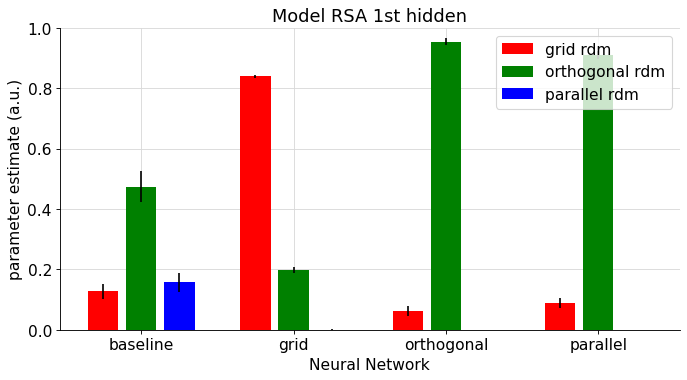

In [45]:
xlabels = ['baseline'] + model_labels
# generate design matrix
_, dmat,xyz = gen_modelrdms(monitor=0)

mlp_outputs = np.concatenate((results_baseline['all_y_hidden1'],results_rdm['all_y_hidden1']),axis=0)
coeffs = stats_fit_rdms(dmat,mlp_outputs)
# plot results (coefficients)
coeffs_mu = np.mean(coeffs,1)
coeffs_err = np.std(coeffs,1)/np.sqrt(N_RUNS)
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(0,coeffs_mu.shape[0])-0.25,coeffs_mu[:,0],yerr=coeffs_err[:,0],width=0.2,color='red',zorder=3)
plt.bar(np.arange(0,coeffs_mu.shape[0]),coeffs_mu[:,1],yerr=coeffs_err[:,1],width=0.2,color='green',zorder=3)
plt.bar(np.arange(0,coeffs_mu.shape[0])+0.25,coeffs_mu[:,2],yerr=coeffs_err[:,2],width=0.2,color='blue',zorder=3)
plt.legend(['grid rdm', 'orthogonal rdm', 'parallel rdm'],fontsize=14)
plt.xticks(np.arange(0,4),labels=xlabels,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Neural Network',fontsize=14)
plt.ylabel('parameter estimate (a.u.)',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
plt.title('Model RSA 1st hidden',fontsize=16)
plt.ylim([0,1])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# concatenate baseline and rdm patterns and run RSA 
mlp_outputs = np.concatenate((results_baseline['all_y_hidden2'],results_rdm['all_y_hidden2']),axis=0)
coeffs = stats_fit_rdms(dmat,mlp_outputs)
# plot results (coefficients)
coeffs_mu = np.mean(coeffs,1)
coeffs_err = np.std(coeffs,1)/np.sqrt(N_RUNS)
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(0,coeffs_mu.shape[0])-0.25,coeffs_mu[:,0],yerr=coeffs_err[:,0],width=0.2,color='red',zorder=3)
plt.bar(np.arange(0,coeffs_mu.shape[0]),coeffs_mu[:,1],yerr=coeffs_err[:,1],width=0.2,color='green',zorder=3)
plt.bar(np.arange(0,coeffs_mu.shape[0])+0.25,coeffs_mu[:,2],yerr=coeffs_err[:,2],width=0.2,color='blue',zorder=3)
plt.legend(['grid rdm', 'orthogonal rdm', 'parallel rdm'],fontsize=14)
plt.xticks(np.arange(0,4),labels=xlabels,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Neural Network',fontsize=14)
plt.ylabel('parameter estimate (a.u.)',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
plt.title('Model RSA 2nd hidden',fontsize=16)
plt.ylim([0,1])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Figure S3

In [46]:
# matlab

## Figure S4

### S4B: Results from nested model comparison 

leftEVC,	 model 1: mu=0.38+-0.08 	 z=0.80, 	 p=0.211
leftEVC,	 model 2: mu=0.50+-0.08 	 z=2.29, 	 p=0.011
leftEVC,	 model 3: mu=0.12+-0.05 	 z=-3.08, 	 p=0.999
DLPFC,	 model 1: mu=0.15+-0.06 	 z=-2.86, 	 p=0.998
DLPFC,	 model 2: mu=0.03+-0.02 	 z=-4.28, 	 p=1.000
DLPFC,	 model 3: mu=0.82+-0.06 	 z=4.51, 	 p=0.000
MCC,	 model 1: mu=0.20+-0.06 	 z=-2.00, 	 p=0.977
MCC,	 model 2: mu=0.07+-0.04 	 z=-3.69, 	 p=1.000
MCC,	 model 3: mu=0.73+-0.07 	 z=4.19, 	 p=0.000
PPC,	 model 1: mu=0.12+-0.05 	 z=-3.08, 	 p=0.999
PPC,	 model 2: mu=0.04+-0.03 	 z=-4.24, 	 p=1.000
PPC,	 model 3: mu=0.84+-0.06 	 z=4.57, 	 p=0.000


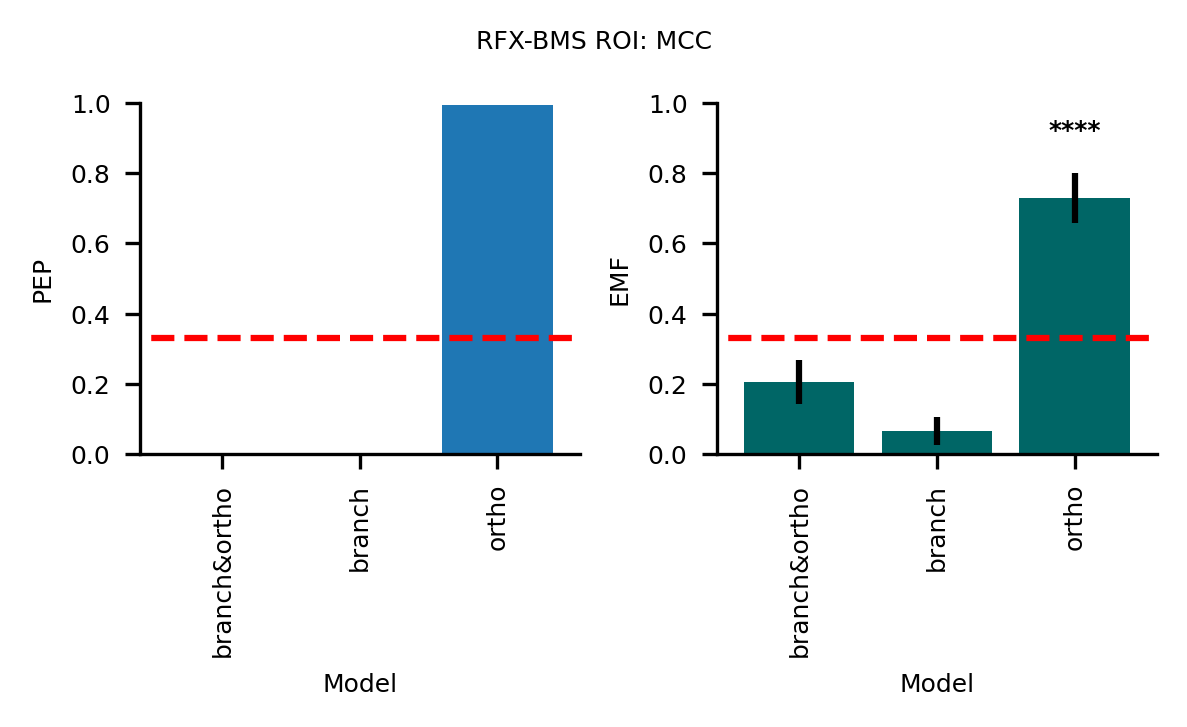

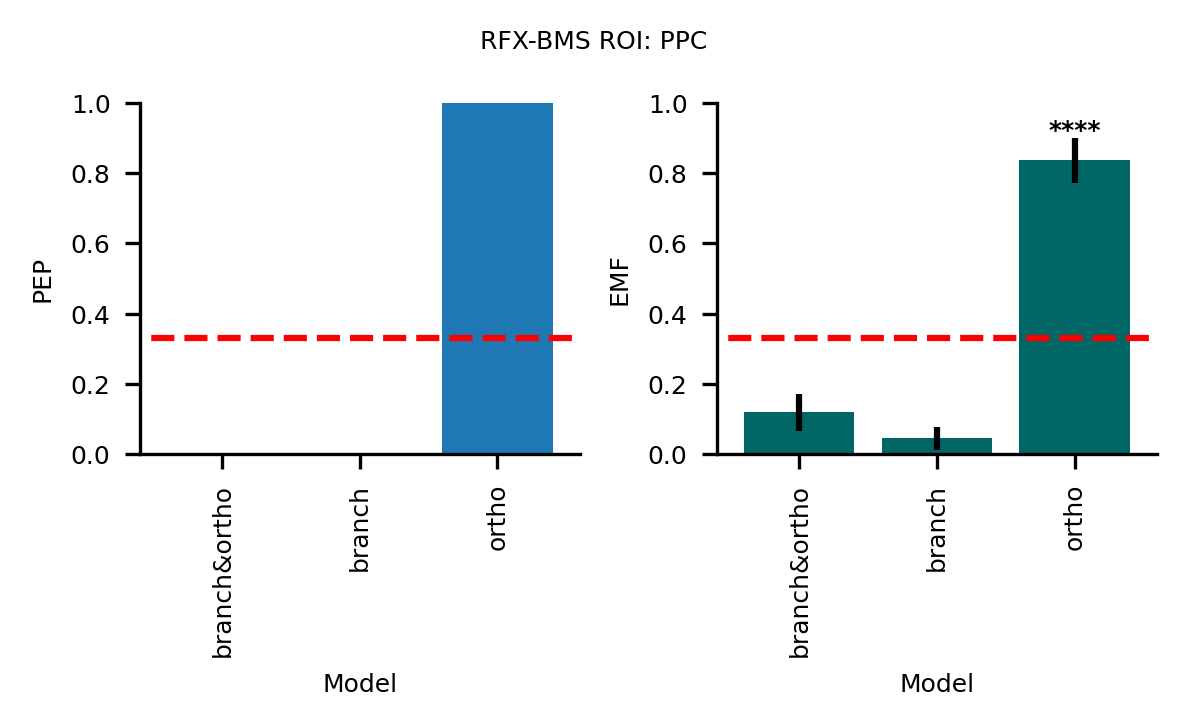

In [48]:
from scipy.stats import norm
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 6
BIGGER_SIZE = 6

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# plot peps and emfs for each ROI
datadir = dir_results_humanfmri+'/RSA/ROIs/'
ROIs = ['leftEVC','DLPFC','MCC','PPC']

for roi in ROIs:
    results = loadmat(datadir + 'bmsresults_branchortho_branch_ortho_'+roi+'.mat')
    mm = 1/25.4
    
    f,axs = plt.subplots(1,2,figsize=(100*mm,60*mm),dpi=300)
    axs = axs.ravel()    
    axs[0].bar(np.arange(0,3),results['pep'].squeeze())
    axs[0].set(xticks=(0,1,2),xlabel='Model',ylabel=('PEP'),ylim=(0,1))
    axs[0].set_xticklabels(labels=('branch&ortho','branch','ortho'),rotation=90)
    axs[0].plot(np.arange(-1,4),[0.33]*5,'r--')
    axs[0].set_xlim(-0.6,2.6)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    for mod in range(3):
        mu = np.mean(results['emf'][mod,:])
        err = np.std(results['emf'][mod,:])/np.sqrt(31)
        axs[1].bar(mod,mu,yerr=err,color=[0,.4,.4])
        s,p = wilcoxon(results['emf'][mod,:]-0.33,alternative='greater')
        z = norm.isf(p)
        print(f'{roi},\t model {mod+1}: mu={mu:.2f}+-{err:.2f} \t z={z:.2f}, \t p={p:.3f}')
        if z>1.96:
            if p <0.0001:
                ts = '*'*4
            elif p <0.001:
                ts = '*'*3
            elif p<0.01:
                ts = '*'*2
            elif p<0.05:
                ts = '*'
            plt.text(mod,0.9,ts,{'fontsize':6,'ha':'center','fontweight':'bold'})
    axs[1].set(xticks=(0,1,2),xlabel='Model',ylabel=('EMF'),ylim=(0,1))
    axs[1].set_xticklabels(labels=('branch&ortho','branch','ortho'),rotation=90)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    axs[1].plot(np.arange(-1,4),[0.33]*5,'r--')
    axs[1].set_xlim(-0.6,2.6)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    plt.suptitle('RFX-BMS ROI: '+roi)
    plt.tight_layout()

### S4C: Results from fmri MVPA

In [52]:
rois = ['leftEVC_all7mods_mod5_sub','rightDLPFC_all7mods_mod3_sub','rightMCC_all7mods_mod3_sub','rightPAR_all7mods_mod3_sub']
def plot_avg_svm_results(results):
    # loop over training dimensions
    mm = 1/25.4
    f,axs = plt.subplots(1,len(rois),figsize=(150*mm,50*mm),dpi=300)
    axs = axs.ravel()
    for j,roi in enumerate(rois): # for each roi
        # same task, relevant:            
        # (0,0),(1,1)    
        # same task, irrelevant: 
        # (0,2),(1,3)
        # other task, relevant: 
        # (0,1),(1,0)
        # other task, irrelevant:
        # (0,3),(1,2)
        idces = [(0,0),(1,1)],[(0,2),(1,3)],[(0,1),(1,0)],[(0,3),(1,2)]
        for k,idx in enumerate(idces):
            avg_res = (results[j,idx[0][0],:,idx[0][1]]+results[j,idx[1][0],:,idx[1][1]])/2           
        
            axs[j].bar(k,avg_res.mean()-0.5,yerr=np.std(avg_res)/np.sqrt(31),color=(0.5,0.7,0.4),edgecolor='k')
            axs[j].scatter(np.repeat(k,31)+0.1+np.random.randn(31)*0.01,avg_res-0.5,color=(.9,.9,.9),alpha=0.4,zorder=3,s=2,edgecolors='k',linewidth=0.5)
            axs[j].plot([-1,4],[0,0],'k--',linewidth=0.5)
            t,p = ttest_1samp(avg_res,0.5)
            
            print(''.join((roi.split('_')[0].split('t')[1:])) + f': \t t= {t:.2f}, \t p= {p:.4f} mu={avg_res.mean()-0.5:.4f}')
            if t>0 and p<0.05:
                if p <(0.0001/4):
                    ts = '*'*4
                elif p <(0.001/4):
                    ts = '*'*3
                elif p<(0.01/4):
                    ts = '*'*2
                elif p<(0.05/4):
                    ts = '*'
                else:
                    ts =''
                axs[j].text(k,0.2,ts,{'fontsize':6,'ha':'center','fontweight':'normal'})

        axs[j].set_xlabel('test dimension',fontsize=6)
        axs[j].set_ylabel('test acc - chance (%)',fontsize=6)
        axs[j].set_title(''.join((roi.split('_')[0].split('t')[1:])),fontsize=6)
        axs[j].set_ylim(-0.10,0.2)
        axs[j].set_xticks(np.arange(4))
        axs[j].set_xticklabels(['same task rel','same task irrel', 'other task rel', 'other task irrel'],rotation=90,fontsize=6)
        axs[j].set_yticks(ticks=[-0.1,0,0.1,0.2])
        axs[j].set_yticklabels(np.round(np.array([-0.1,0,0.1,0.2])*100,2),fontsize=6)
        axs[j].spines['top'].set_visible(False)
        axs[j].spines['right'].set_visible(False)
        
    
    plt.suptitle('Decoding Results',fontsize=6)
    plt.tight_layout()

with open(dir_results_humanfmri+'/MVPA/results_linearsvm_fmri_tmaps_pca.pkl', 'rb') as f:
    results = pickle.load(f)
from scipy.stats import ttest_1samp 
dims_train =  ['taskA_reldim', 'taskB_reldim']
dims_test = ['taskA_reldim', 'taskB_reldim','taskA_irreldim', 'taskB_irreldim']
%matplotlib inline
plot_avg_svm_results(results['test_accs'][:,0,:,:,:])

EVC: 	 t= 8.99, 	 p= 0.0000 mu=0.0665
EVC: 	 t= 1.73, 	 p= 0.0941 mu=0.0119
EVC: 	 t= 0.88, 	 p= 0.3856 mu=0.0082
EVC: 	 t= 8.44, 	 p= 0.0000 mu=0.0615
DLPFC: 	 t= 4.41, 	 p= 0.0001 mu=0.0319
DLPFC: 	 t= 0.22, 	 p= 0.8238 mu=0.0012
DLPFC: 	 t= -0.18, 	 p= 0.8562 mu=-0.0012
DLPFC: 	 t= 2.32, 	 p= 0.0275 mu=0.0098
MCC: 	 t= 5.54, 	 p= 0.0000 mu=0.0398
MCC: 	 t= 0.30, 	 p= 0.7698 mu=0.0016
MCC: 	 t= -0.40, 	 p= 0.6952 mu=-0.0032
MCC: 	 t= 1.22, 	 p= 0.2327 mu=0.0052
PAR: 	 t= 4.13, 	 p= 0.0003 mu=0.0273
PAR: 	 t= 0.74, 	 p= 0.4649 mu=0.0038
PAR: 	 t= 0.13, 	 p= 0.8975 mu=0.0010
PAR: 	 t= 1.85, 	 p= 0.0736 mu=0.0092


### S4D-F,H,I: Matlab

In [49]:
#matlab
# and 
datadir = dir_results_humanfmri+'/RSA/ROIs/'
ROIs = ['leftEVC','DLPFC','MCC','PPC']
rois = ['EVC','DLPFC','MCC','PPC']
mm = 1/25.4
%matplotlib qt
plt.figure(figsize=(5,5))
for roi in ROIs:
    results = loadmat(datadir + 'groupAvg_singular_values_'+roi+'.mat')
    evs = results['all_svs']**2
    evs = evs/ np.sum(evs,1)[:,np.newaxis]
    print(np.where(np.mean(np.cumsum(evs,1),0)>=0.95)[0][0])
    plt.errorbar(np.arange(1,50+1),np.mean(np.cumsum(evs,1),0),marker='.',yerr=np.std(np.cumsum(evs,1),0)/np.sqrt(evs.shape[0]),linewidth=1,markersize=2)
    ax = plt.gca()
    ax.set(xlabel='principal component',ylabel='cumulative explained variance (%)',yticks=np.arange(0.4,1.1,.1),yticklabels=np.round(np.arange(0.4,1.1,.1)*100),title='Dimensionality of voxel patterns')
plt.legend(rois,frameon=False)


### S4G monkey mvpa

tested on same task rel, 	 p= 0.0, 	 mu=0.0668
tested on same task irrel, 	 p= 0.996, 	 mu=-0.0235
tested on other task rel, 	 p= 1.0, 	 mu=-0.0318
tested on other task irrel, 	 p= 0.064, 	 mu=0.0116


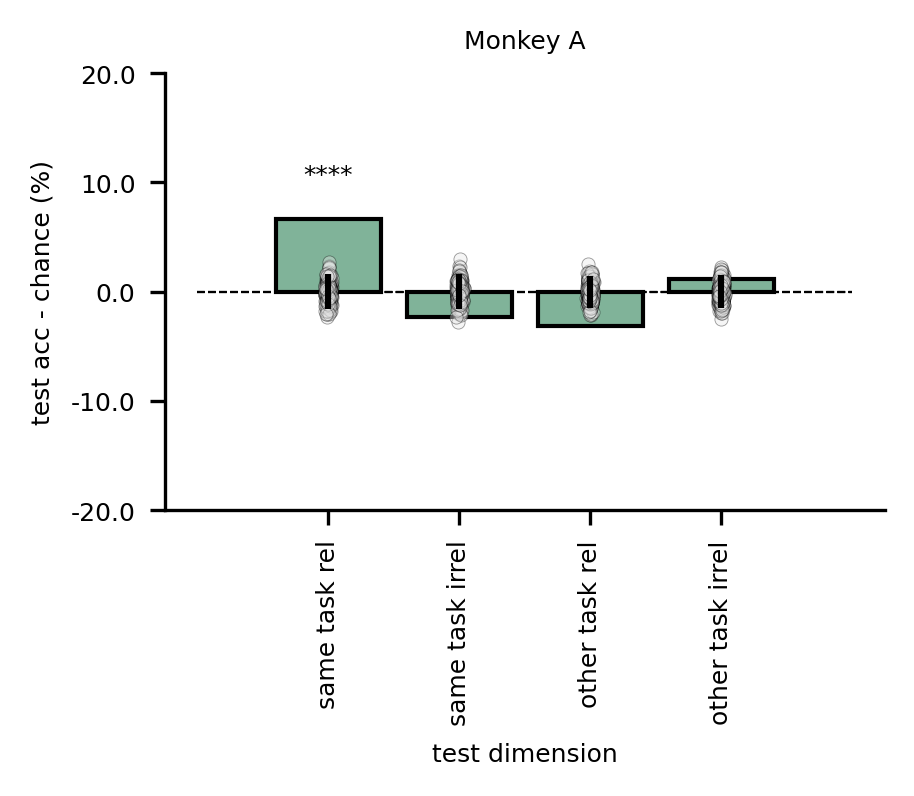

In [56]:

def nonparam_test(t,t_shuff):
    # return proportion of shuffled ts that exceed empirical t
    # as approximation of p value
    return np.mean(t_shuff>t)


def plot_avg_svm_results(results,shuffresults):
    # loop over training dimensions
    mm = 1/25.4
    f,axs = plt.subplots(1,1,figsize=(80*mm,70*mm),dpi=300)
    
   
    dtes = ['same task rel','same task irrel', 'other task rel', 'other task irrel']
    idces = [(0,0),(1,1)],[(0,2),(1,3)],[(0,1),(1,0)],[(0,3),(1,2)]
    for k,idx in enumerate(idces):
        avg_res = (results[idx[0][0],idx[0][1]]+results[idx[1][0],idx[1][1]])/2
        avg_shuff = (shuffresults[idx[0][0],idx[0][1],:]+shuffresults[idx[1][0],idx[1][1],:])/2
    
        axs.bar(k,avg_res-avg_shuff.mean(),color=(0.5,0.7,0.6),edgecolor='k')
    
        axs.scatter(np.repeat(k,len(avg_shuff))+np.random.randn(len(avg_shuff))*0.01,avg_shuff-avg_shuff.mean(),color=(.9,.9,.9),alpha=0.4,zorder=3,s=10,edgecolor='k',linewidth=0.2)
        axs.errorbar(k,0,yerr=2*np.std(avg_shuff),color='k',zorder=4)
        axs.plot([-1,4],[0,0],'k--',linewidth=0.5)
        p = nonparam_test(avg_res,avg_shuff)
        print(f'tested on {dtes[k]}, \t p= {p}, \t mu={avg_res-avg_shuff.mean():.4f}')
        
        if p<0.05:
            
            if p <0.0001:
                ts = '*'*4
            elif p <0.001:
                ts = '*'*3
            elif p<0.01:
                ts = '*'*2
            elif p<0.05:
                ts = '*'
            axs.text(k,0.1,ts,{'fontsize':6,'ha':'center','fontweight':'normal'})


    axs.set_xlabel('test dimension',fontsize=6)
    axs.set_ylabel('test acc - chance (%)',fontsize=6)
    axs.set_title('Monkey A',fontsize=6)
    axs.set_yticks(np.arange(-0.2,0.21,0.1))
    axs.set_ylim=(-0.1,0.2)
    axs.set_xticks(np.arange(4))
    axs.set_xticklabels(dtes,rotation=90,fontsize=6)
    ticks = axs.get_yticks()
    axs.set_yticklabels(np.round(ticks*100,2),fontsize=6)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
        

    plt.tight_layout()


with open('results_nhp_svm_pca.pkl', 'rb') as f:
    results = pickle.load(f)
%matplotlib inline
dims_train =  ['taskA_reldim', 'taskB_reldim']
dims_test = ['taskA_reldim', 'taskB_reldim','taskA_irreldim', 'taskB_irreldim']
plot_avg_svm_results(results['test_accs'],results['shuffle_accs'])

## Figure S5

### S5a: hidden layer weights

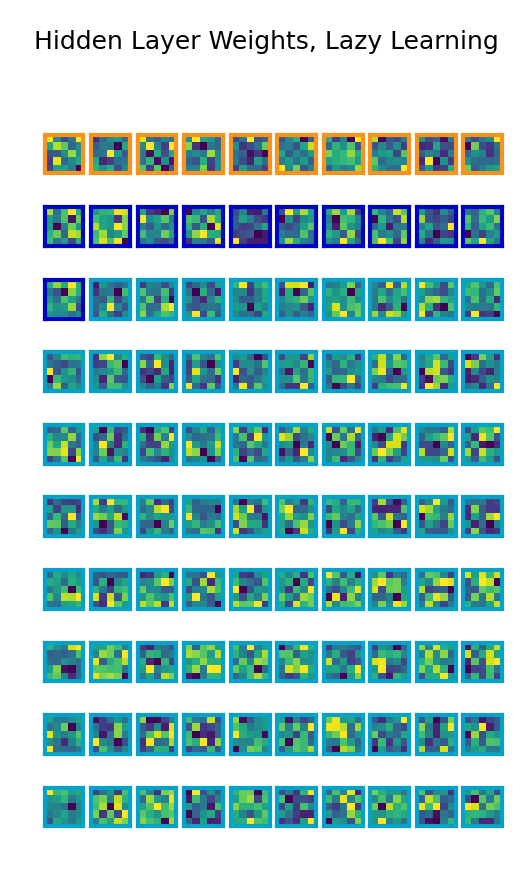

In [58]:
# visualise hidden layer weights, sort them by output unit type (mixed selective, task a or task b selective )
with open(dir_results_simus+'/mlp/results_mlp_main.pkl','rb') as f:
        results = pickle.load(f)
def plot_hidden_weights(results,regime='rich'):
    reg_id = int(regime!='rich') * -1
    unit_cols = [[250/255, 147/255, 30/255],[0/255, 6/255, 189/255],[4/255, 162/255, 201/255]]
    # get unit ids:
    yout = results['all_y_hidden'][reg_id,0,:,:]
    x = np.vstack((np.nanmean(yout[:,0:25],1).T,np.nanmean(yout[:,25:],1).T))
    # local units
    mask_local = ~(np.all(x,axis=0)) & np.any(x,axis=0)
    mask_a = np.all(np.vstack((x[0,:]>0,x[1,:]==0)),axis=0)
    mask_b = np.all(np.vstack((x[0,:]==0,x[1,:]>0)),axis=0)
    mask_mixed = ~mask_local

    ws = results['all_w_hxs'][reg_id,0,:,:]
    ws = [ws[mask_a,:],ws[mask_b,:],ws[mask_mixed,:]]    
    unit_cols = [c for c,w in zip(unit_cols,ws) for i in range(len(w))]
    ws = np.concatenate(ws,axis=0)
    
    mm = 1/25.4
    f,axs= plt.subplots(10,10,figsize=(50*mm,80*mm),dpi=300)
    axs = axs.ravel()
    for ax,c,w in zip(axs,unit_cols,ws):
        ax.imshow(w.reshape(5,5))
        [i.set_linewidth(1) for i in ax.spines.values()]
        [i.set_color(c) for i in ax.spines.values()]
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.suptitle(f'Hidden Layer Weights, {regime} Learning'.title(),fontsize=6)
    f.patch.set_facecolor('white')



plot_hidden_weights(results,regime='lazy')
plot_hidden_weights(results,regime='rich')


### S5b: Output weight magnitude

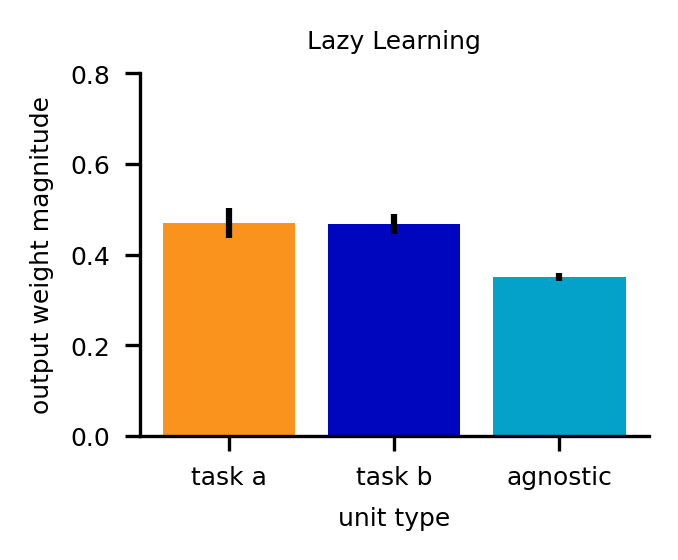

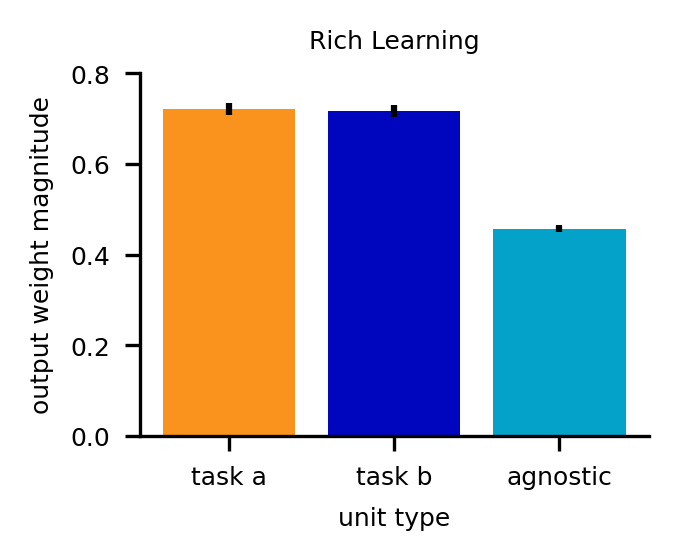

In [59]:
# visualise hidden layer weights, sort them by output unit type (mixed selective, task a or task b selective )
N_RUNS = results['all_y_hidden'].shape[1]

def plot_output_weights(results,regime='rich'):
    reg_id = int(regime!='rich') * -1
    unit_cols = [[250/255, 147/255, 30/255],[0/255, 6/255, 189/255],[4/255, 162/255, 201/255]]
    ws = []
    for run_id in range(N_RUNS):
        # get unit ids:
        yout = results['all_y_hidden'][reg_id,run_id,:,:]
        x = np.vstack((np.nanmean(yout[:,0:25],1).T,np.nanmean(yout[:,25:],1).T))
        # local units
        mask_local = ~(np.all(x,axis=0)) & np.any(x,axis=0)
        mask_a = np.all(np.vstack((x[0,:]>0,x[1,:]==0)),axis=0)
        mask_b = np.all(np.vstack((x[0,:]==0,x[1,:]>0)),axis=0)
        mask_mixed = ~mask_local

        wr = results['all_w_yh'][reg_id,run_id,:].flatten()
        wr = [np.abs(u).mean(0) for u in [wr[mask_a],wr[mask_b],wr[mask_mixed]]]
        ws.append(wr)
        
    ws = np.asarray(ws)
    mm = 1/25.4
    f,ax= plt.subplots(1,1,figsize=(60*mm,50*mm),dpi=300)
    for i in range(3):
        ax.bar(i,ws[:,i].mean(0),yerr=np.std(ws[:,i],ddof=1)/np.sqrt(N_RUNS),color=unit_cols[i])
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(['task a','task b', 'agnostic'],fontsize=6)
    ax.set_xlabel('unit type',fontsize=6)
    ax.set_ylabel('output weight magnitude',fontsize=6)
    ax.set_yticks(np.arange(0,0.81,0.2))
    ax.set_ylim(0,0.8)
    ticks = ax.get_yticks()
    ax.set_yticklabels(np.round(np.array(ticks),2),fontsize=6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
        
    plt.title(f'{regime} Learning'.title(),fontsize=6)
    f.patch.set_facecolor('white')


plot_output_weights(results,regime='lazy')
plt.tight_layout()
plot_output_weights(results,regime='rich')
plt.tight_layout()


### S5c: Ablation acc per task

[[1.         1.        ]
 [0.99833333 1.        ]
 [0.72333333 1.        ]
 [1.         0.69833333]]
[[1.         1.        ]
 [0.94166667 0.91666667]
 [0.96833333 0.96166667]
 [0.96166667 0.94666667]]


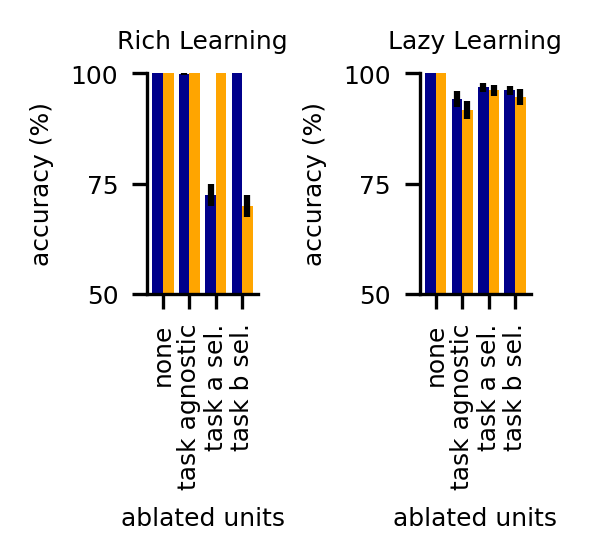

In [62]:
# bars: a/b: all, removed a, removed b, removed mixed 
# one fig rich, one for lazy
mm = 1/25.4
f,axs = plt.subplots(1,2,figsize=(50*mm,50*mm),dpi=300)
axs = axs.flatten()
# rich 
mu = np.array([results['acc_ablate_none_both'][0,:,:].mean(0),results['acc_ablate_mixed_both'][0,:,:].mean(0),results['acc_ablate_a_both'][0,:,:].mean(0),results['acc_ablate_b_both'][0,:,:].mean(0)])
err = np.array([results['acc_ablate_none_both'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_mixed_both'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_a_both'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_b_both'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS)])
print(mu)
b1 = axs[0].bar(np.arange(4)-.2,mu[:,0],yerr=err[:,0],color='darkblue',width=.4)
b2 = axs[0].bar(np.arange(4)+.2,mu[:,1],yerr=err[:,1],color='orange',width=.4)
axs[0].set(xticks=[0,1,2,3])
axs[0].set_xticklabels(['none','task agnostic','task a sel.','task b sel.'],fontsize=6)
axs[0].set_title('Rich Learning',fontsize=6)
axs[0].set_xlabel('ablated units',fontsize=6)
axs[0].set_ylabel('accuracy (%)',fontsize=6)
axs[0].set_yticks(np.arange(0,1.05,0.25))
axs[0].set_yticklabels(np.arange(0,105,25),fontsize=6)
axs[0].set_ylim(.5,1)
for label in axs[0].get_xticklabels():
    
    label.set_rotation(90)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# lazy
mu = np.array([results['acc_ablate_none_both'][-1,:,:].mean(0),results['acc_ablate_mixed_both'][-1,:,:].mean(0),results['acc_ablate_a_both'][-1,:,:].mean(0),results['acc_ablate_b_both'][-1,:,:].mean(0),])
err = np.array([results['acc_ablate_none_both'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_mixed_both'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_a_both'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_b_both'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS)])
print(mu)
b1 = axs[1].bar(np.arange(4)-.2,mu[:,0],yerr=err[:,0],color='darkblue',width=.4)
b2 = axs[1].bar(np.arange(4)+.2,mu[:,1],yerr=err[:,1],color='orange',width=.4)
axs[1].set(xticks=[0,1,2,3])
axs[1].set_xticklabels(['none','task agnostic','task a sel.','task b sel.'],fontsize=6)
axs[1].set_title('Lazy Learning',fontsize=6)
axs[1].set_xlabel('ablated units',fontsize=6)
axs[1].set_ylabel('accuracy (%)',fontsize=6)
axs[1].set_yticks(np.arange(0,1.05,0.25))
axs[1].set_yticklabels(np.arange(0,105,25),fontsize=6)
axs[1].set_ylim(.5,1)
for label in axs[1].get_xticklabels():
    
    label.set_rotation(90)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
plt.tight_layout()

### S5E: Congruency


[[1.         1.        ]
 [0.8625     0.56875   ]
 [0.99791667 1.        ]]
[[1.         1.        ]
 [0.8625     0.825     ]
 [0.925      0.92708333]]


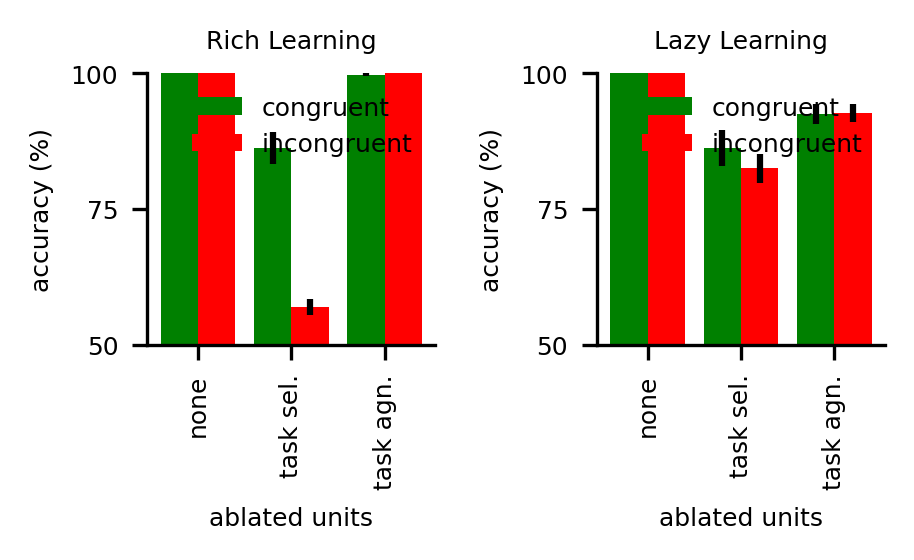

In [64]:
mm = 1/25.4
f,axs = plt.subplots(1,2,figsize=(80*mm,50*mm),dpi=300)

axs = axs.flatten()
# rich 
mu = np.array([results['acc_ablate_none_congr'][0,:,:].mean(0),results['acc_ablate_task_congr'][0,:,:].mean(0),results['acc_ablate_mixed_congr'][0,:,:].mean(0)])
err = np.array([results['acc_ablate_none_congr'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_task_congr'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_mixed_congr'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS)])
print(mu)
b1 = axs[0].bar(np.arange(3)-.2,mu[:,0],yerr=err[:,0],color='green',width=.4)
b2 = axs[0].bar(np.arange(3)+.2,mu[:,1],yerr=err[:,1],color='red',width=.4)
axs[0].set(xticks=[0,1,2])
axs[0].set_xticklabels(['none','task sel.','task agn.'],fontsize=6,rotation=90)
axs[0].set_title('Rich Learning',fontsize=6)
axs[0].set_xlabel('ablated units',fontsize=6)
axs[0].set_ylabel('accuracy (%)',fontsize=6)
axs[0].set_yticks(np.arange(0,1.05,0.25))
axs[0].set_yticklabels(np.arange(0,105,25),fontsize=6)
axs[0].set_ylim(.5,1)
axs[0].legend(['congruent','incongruent'],fontsize=6,loc=1,frameon=False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

 
# lazy
mu = np.array([results['acc_ablate_none_congr'][-1,:,:].mean(0),results['acc_ablate_task_congr'][-1,:,:].mean(0),results['acc_ablate_mixed_congr'][-1,:,:].mean(0)])
err = np.array([results['acc_ablate_none_congr'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_task_congr'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_mixed_congr'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS)])
print(mu)
b1 = axs[1].bar(np.arange(3)-.2,mu[:,0],yerr=err[:,0],color='green',width=.4)
b2 = axs[1].bar(np.arange(3)+.2,mu[:,1],yerr=err[:,1],color='red',width=.4)
axs[1].set(xticks=[0,1,2])
axs[1].set_xticklabels(['none','task sel.','task agn.'],fontsize=6,rotation=90)
axs[1].set_title('Lazy Learning',fontsize=6)
axs[1].set_xlabel('ablated units',fontsize=6)
axs[1].set_ylabel('accuracy (%)',fontsize=6)
axs[1].set_yticks(np.arange(0,1.05,0.25))
axs[1].set_yticklabels(np.arange(0,105,25),fontsize=6)
axs[1].set_ylim(.5,1)
axs[1].legend(['congruent','incongruent'],fontsize=6,loc=1,frameon=False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
plt.tight_layout()

### S5F congruency effect in human data 

congruency effect in accuracy:	 t(31)=2.68, p=0.012
congruency effect in RT: 	t(31)=-5.11, p=0.0
congruency effect in RT: 	t(31)=-5.11, p=0.0


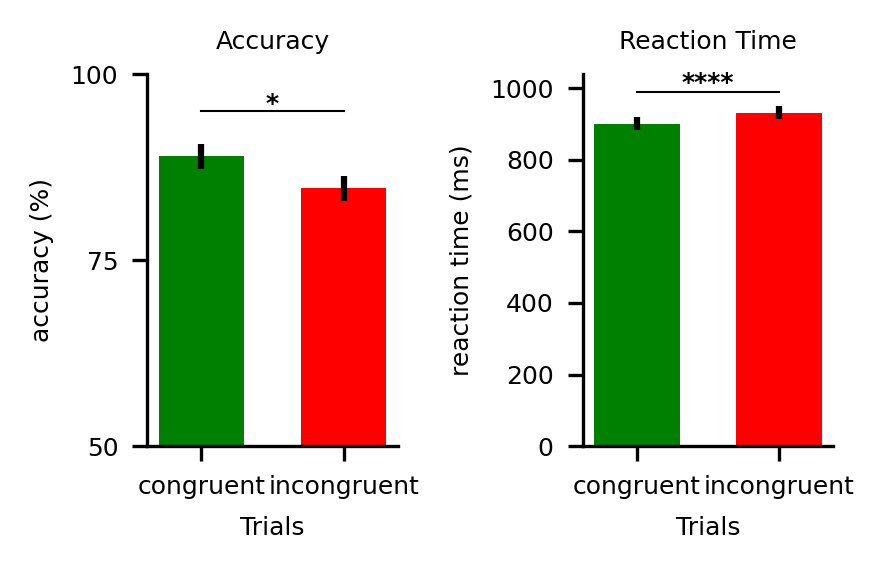

In [67]:
datadir = ''
data = loadmat(datadir+'congruency_analysis_data.mat')
badsubs = np.array([28])-1
data.keys()

congruent_trials = ((1,1),(1,2),(2,1),(2,2),(4,4),(4,5),(5,4),(5,5))
incongruent_trials = ((1,4),(1,5),(2,4),(2,5),(4,1),(4,2),(5,1),(5,2))
# get rid of annoying empty dims (due to conversion from MATLAB to np)
for k,v in data.items():
    if isinstance(data[k],np.ndarray):
        data[k] = v.squeeze()
accs_congruent = []
accs_incongruent = []
rts_congruent = []
rts_incongruent = []
for sid,rid in enumerate(data['rule_id']):
    if sid not in badsubs:
        b = data['branchiness'][sid,:]
        l = data['leafiness'][sid,:]
        acc = data['resp_correct'][sid,:]
        rt = data['resp_rt'][sid,:]
        if rid<3:
            accs_congruent.append(np.mean([np.mean(acc[(b==i) & (l==j)]) for i,j in congruent_trials]))
            accs_incongruent.append(np.mean([np.mean(acc[(b==i) & (l==j)]) for i,j in incongruent_trials]))
            rts_congruent.append(np.nanmean([np.nanmean(rt[(b==i) & (l==j)]) for i,j in congruent_trials]))
            rts_incongruent.append(np.nanmean([np.nanmean(rt[(b==i) & (l==j)]) for i,j in incongruent_trials]))
        else:
            accs_congruent.append(np.mean([np.mean(acc[(b==i) & (l==j)]) for i,j in incongruent_trials]))
            accs_incongruent.append(np.mean([np.mean(acc[(b==i) & (l==j)]) for i,j in congruent_trials]))
            rts_congruent.append(np.nanmean([np.nanmean(rt[(b==i) & (l==j)]) for i,j in incongruent_trials]))
            rts_incongruent.append(np.nanmean([np.nanmean(rt[(b==i) & (l==j)]) for i,j in congruent_trials]))

rts_congruent = np.asarray(rts_congruent)
rts_incongruent = np.asarray(rts_incongruent)
accs_congruent = np.asarray(accs_congruent)
accs_incongruent = np.asarray(accs_incongruent)
rts_congruent *=1000
rts_incongruent *=1000

f, axs = plt.subplots(1,2,figsize=(3,2),dpi=300)
axs = axs.ravel()
axs[0].bar(np.arange(2),[np.nanmean(accs_congruent),np.nanmean(accs_incongruent)],yerr=[np.std(accs_congruent)/np.sqrt(31),np.std(accs_incongruent)/np.sqrt(31)],width=0.6,color=['green','red'])
_ = axs[0].set(xticks=(0,1),xlabel='Trials',ylabel='accuracy (%)',yticks=np.arange(0,1.1,0.25),yticklabels=np.arange(0,101,25),xticklabels=('congruent','incongruent'),ylim=(.5,1),title='Accuracy')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].plot((0,1),(0.95,0.95),'k-',linewidth=0.5)
t,p = ttest_1samp(accs_congruent-accs_incongruent,0)
print(f'congruency effect in accuracy:\t t(31)={t.round(2)}, p={p.round(3)}')
if t > 1.96:
    if p <0.0001:
        ts = '*'*4
    elif p <0.001:
        ts = '*'*3
    elif p<0.01:
        ts = '*'*2
    elif p<0.05:
        ts = '*'
    axs[0].text(.5,0.95,ts,{'fontsize':6,'ha':'center','fontweight':'bold'})

axs[1].bar(np.arange(2),[np.nanmean(rts_congruent),np.nanmean(rts_incongruent)],yerr=[np.std(rts_congruent)/np.sqrt(31),np.std(rts_incongruent)/np.sqrt(31)],width=0.6,color=['green','red'])
_ = axs[1].set(xticks=(0,1),xlabel='Trials',ylabel='reaction time (ms)',xticklabels=('congruent','incongruent'),title='Reaction Time')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].plot((0,1),(990,990),'k-',linewidth=0.5)

t,p = ttest_1samp(rts_congruent-rts_incongruent,0)
print(f'congruency effect in RT: \tt(31)={t.round(2)}, p={p.round(3)}')
if np.abs(t) > 1.96:
    if p <0.0001:
        ts = '*'*4
    elif p <0.001:
        ts = '*'*3
    elif p<0.01:
        ts = '*'*2
    elif p<0.05:
        ts = '*'
    axs[1].text(.5,995,ts,{'fontsize':6,'ha':'center','fontweight':'bold'})
    

t,p = ttest_1samp(rts_congruent-rts_incongruent,0)
print(f'congruency effect in RT: \tt(31)={t.round(2)}, p={p.round(3)}')
plt.tight_layout()

### S5d-g: matlab
### S5h-j: see mante_model_stim_dyn.ipynb and matlab code for mante data

## Figure S6

Text(0.5, 1.0, 'Lazy-initialised CNN')

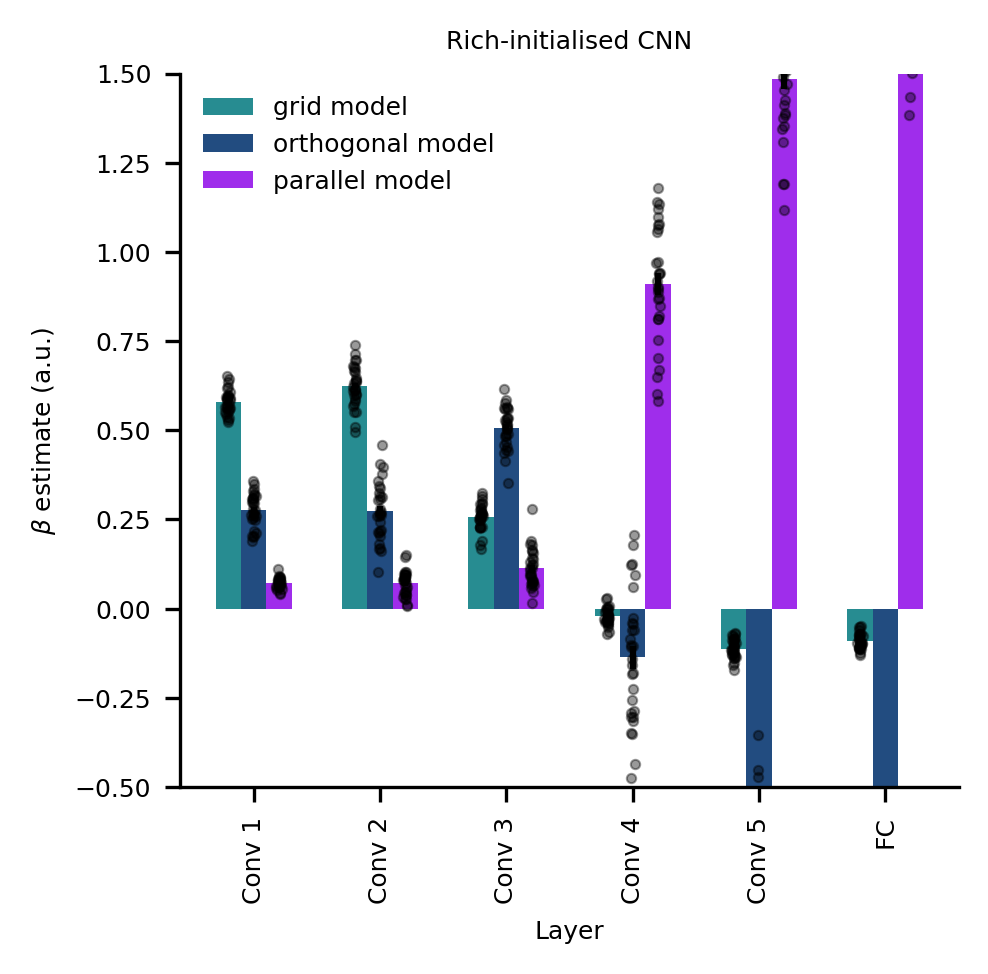

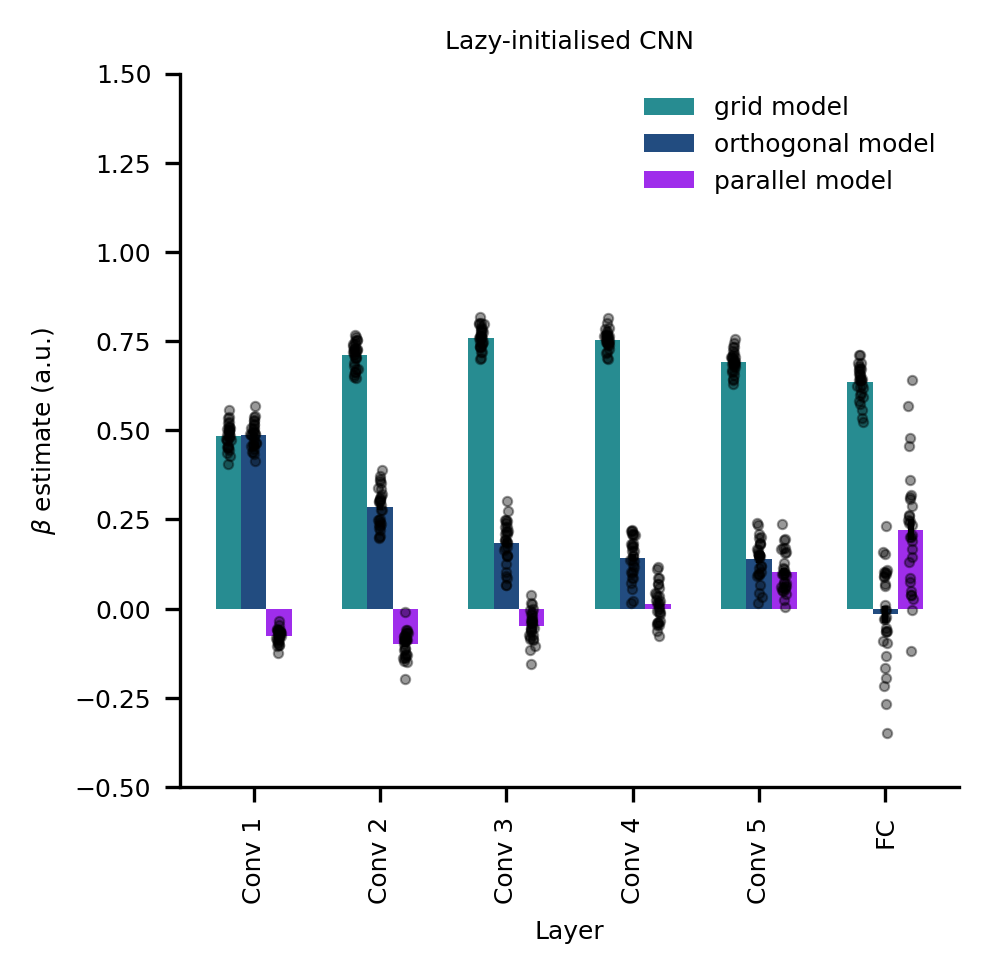

In [71]:
from sklearn.linear_model import LinearRegression


from scipy.stats import zscore 
from sklearn.linear_model import LinearRegression

def gen_modelrdms(ctx_offset=5):
    models = []
    ctx = np.concatenate((ctx_offset*np.ones((25,1)),np.zeros((25,1))),axis=0).reshape(50,1)
    ## model rdms:
    a,b = np.meshgrid(np.linspace(-2,2,5),np.linspace(-2,2,5))
    # grid model
    gridm = np.concatenate((a.flatten()[np.newaxis,:],b.flatten()[np.newaxis,:]),axis=0).T
    gridm = np.concatenate((np.tile(gridm,(2,1)),ctx),axis=1)
    models.append(squareform(pdist(gridm,metric='euclidean')))


    # orthogonal model
    orthm = np.concatenate((np.concatenate((a.flatten()[np.newaxis,:],np.zeros((1,25))),axis=0).T,
                            np.concatenate((np.zeros((1,25)),b.flatten()[np.newaxis,:]),axis=0).T),axis=0)
    orthm = np.concatenate((orthm,ctx),axis=1)
    models.append(squareform(pdist(orthm,metric='euclidean')))


    # parallel model 
    a = a.flatten()
    b = b.flatten()

    ta = np.stack((a,np.zeros((25))),axis=1)
    tb = np.stack((np.zeros(25),b),axis=1)
    theta = np.radians(-90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    parm = np.concatenate((ta.dot(R),tb),axis=0)
    parm = np.concatenate((parm,ctx),axis=1)
    models.append(squareform(pdist(parm,metric='euclidean')))
 
    # construct design matrix
    dmat = np.asarray([zscore(rdm[np.tril_indices(50,k=-1)].flatten()) for rdm in models]).T
    
    rdms = np.asarray(models)  

    return rdms,dmat

# ditto but only each module (i.e. behind relu)
layerstoplot = [2,5,7,9,11,12]
layer_labels = ['Conv 1','Conv 2','Conv 3','Conv 4','Conv 5','FC']
# visualise Modelfits
%matplotlib inline
# layer_labels = ['Layer '+str(i)+': ' +l for i,l in enumerate(['Conv 1','Conv 2','Conv 3','Conv 4','Conv 5','FC','Output'])]

mm = 1/25.4

# Fromscratch, trained on task 
cs = []
for r in range(30):
    cr = []
    with open('alexnet_fromscratch/run_'+ str(r) + '/'+'results.pkl','rb') as f:
        results = pickle.load(f)
    rdms = np.asarray(results['rdms'])
    rdms = rdms[layerstoplot,:,:]
    # loop over layers and perform rsa:
    for l,rdm in enumerate(rdms):
        regr = LinearRegression()
        _,dmat = gen_modelrdms(ctx_offset=3)
        
        y  = zscore(rdm[np.tril_indices(50,k=-1)])
        regr.fit(dmat,y)
        cr.append(np.asarray(regr.coef_))
    cs.append(cr)
cs = np.asarray(cs)

f,ax = plt.subplots(1,1,figsize=(85*mm,80*mm),dpi=300)
for i,l in zip(np.arange(len(layer_labels)),layer_labels):
    c = cs[:,i,:]    
    b1 = ax.bar(i-0.2,c[:,0].mean(0),yerr=np.std(c[:,0],0)/np.sqrt(30),color=(39/255, 140/255, 145/255),width=0.2)
    ax.scatter(np.repeat(i,30)-0.2+np.random.randn(30)*0.01,c[:,0],color=(0,0,0),alpha=0.4,zorder=3,s=5,edgecolors='k',linewidth=0.5)
    b2 = ax.bar(i,c[:,1].mean(0),yerr=np.std(c[:,1],0)/np.sqrt(30),color=(34/255, 76/255, 128/255),width=0.2)
    ax.scatter(np.repeat(i,30)+np.random.randn(30)*0.01,c[:,1],color=(0,0,0),alpha=0.4,zorder=3,s=5,edgecolors='k',linewidth=0.5)
    b3 = ax.bar(i+0.2,c[:,2].mean(0),yerr=np.std(c[:,2],0)/np.sqrt(30),color=(159/255, 45/255, 235/255),width=0.2)    
    ax.scatter(np.repeat(i,30)+0.2+np.random.randn(30)*0.01,c[:,2],color=(0,0,0),alpha=0.4,zorder=3,s=5,edgecolors='k',linewidth=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
_ = ax.set_xticks(ticks=range(len(layer_labels)))
_ = ax.set_xticklabels(labels=layer_labels,rotation=90)
ax.set_ylim((-0.5,1.5))
ax.set_xlabel('Layer')
ax.set_ylabel(r'$\beta$ estimate (a.u.)')
plt.legend((b1,b2,b3),['grid model','orthogonal model','parallel model'],frameon=False)
plt.title('Rich-initialised CNN')

# fromscratch, lazy
cs = []
for r in range(30):
    cr = []
    with open('alexnet_fromscratch_lazy/run_'+ str(r) + '/'+'results.pkl','rb') as f:
        results = pickle.load(f)
    rdms = np.asarray(results['rdms'])
    rdms = rdms[layerstoplot,:,:]
    # loop over layers and perform rsa:
    for l,rdm in enumerate(rdms):
        regr = LinearRegression()
        _,dmat = gen_modelrdms(ctx_offset=3)
        
        y  = zscore(rdm[np.tril_indices(50,k=-1)])
        regr.fit(dmat,y)
        cr.append(np.asarray(regr.coef_))
    cs.append(cr)
cs = np.asarray(cs)
cs.shape

f,ax = plt.subplots(1,1,figsize=(85*mm,80*mm),dpi=300)
for i,l in zip(np.arange(len(layer_labels)),layer_labels):
    c = cs[:,i,:]    
    b1 = ax.bar(i-0.2,c[:,0].mean(0),yerr=np.std(c[:,0],0)/np.sqrt(30),color=(39/255, 140/255, 145/255),width=0.2)
    ax.scatter(np.repeat(i,30)-0.2+np.random.randn(30)*0.01,c[:,0],color=(0,0,0),alpha=0.4,zorder=3,s=5,edgecolors='k',linewidth=0.5)
    b2 = ax.bar(i,c[:,1].mean(0),yerr=np.std(c[:,1],0)/np.sqrt(30),color=(34/255, 76/255, 128/255),width=0.2)
    ax.scatter(np.repeat(i,30)+np.random.randn(30)*0.01,c[:,1],color=(0,0,0),alpha=0.4,zorder=3,s=5,edgecolors='k',linewidth=0.5)
    b3 = ax.bar(i+0.2,c[:,2].mean(0),yerr=np.std(c[:,2],0)/np.sqrt(30),color=(159/255, 45/255, 235/255),width=0.2)    
    ax.scatter(np.repeat(i,30)+0.2+np.random.randn(30)*0.01,c[:,2],color=(0,0,0),alpha=0.4,zorder=3,s=5,edgecolors='k',linewidth=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
_ = ax.set_xticks(ticks=range(len(layer_labels)))
_ = ax.set_xticklabels(labels=layer_labels,rotation=90)
ax.set_ylim((-0.5,1.5))
ax.set_xlabel('Layer')
ax.set_ylabel(r'$\beta$ estimate (a.u.)')
plt.legend((b1,b2,b3),['grid model','orthogonal model','parallel model'],frameon=False)
plt.title('Lazy-initialised CNN')



<Figure size 649.606x590.551 with 0 Axes>

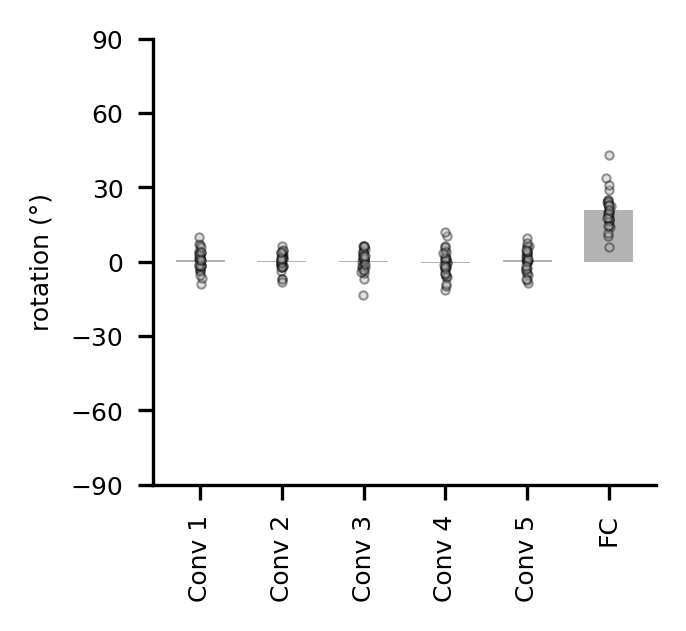

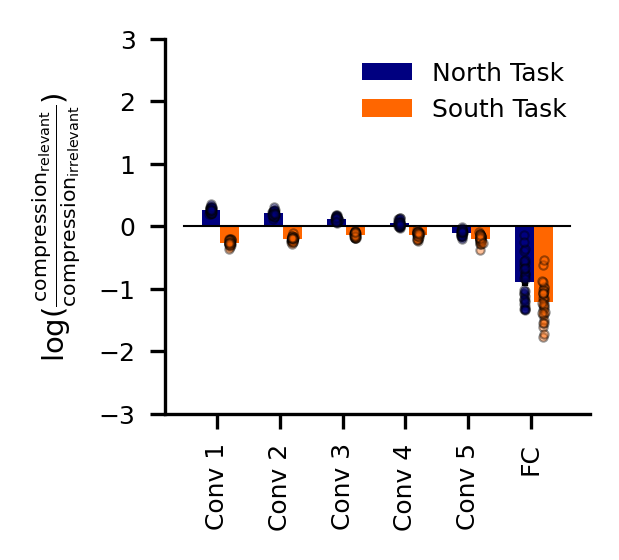

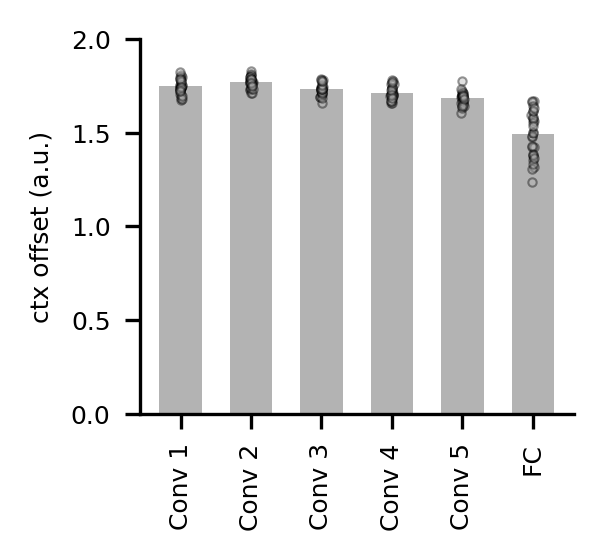

In [75]:
def objective_function(theta, y_true):
    return np.sum((y_true-param_rdm_model(theta))**2) 



def param_rdm_model(theta):
    '''
    generates model rdm from free parameters for 
    compression (rel & irrel dimensions), offset & rotation
    '''
    # unpack parameters 
    c_rel_north,c_rel_south,c_irrel_north,c_irrel_south,a2,ctx = theta
    a1 = 0
    # note: north=90 and south =0 optim
    l,b = np.meshgrid(np.linspace(-2,2,5),np.linspace(-2,2,5))
    b = b.ravel()
    l = l.ravel()
    response_vect = np.concatenate((np.array([(1-c_irrel_north)*b,(1-c_rel_north)*l]),np.array([(1-c_rel_south)*b,(1-c_irrel_south)*l])),axis=1).T

    R1 = np.array([[np.cos(np.deg2rad(a1)),-np.sin(np.deg2rad(a1))],[np.sin(np.deg2rad(a1)),np.cos(np.deg2rad(a1))]])
    R2 = np.array([[np.cos(np.deg2rad(a2)),-np.sin(np.deg2rad(a2))],[np.sin(np.deg2rad(a2)),np.cos(np.deg2rad(a2))]])

    response_vect[:25,:] = response_vect[:25,:] @ R1 
    response_vect[25:,:] = response_vect[25:,:] @ R2 
    ctx_vect = np.zeros((50,1))
    ctx_vect[25:] += ctx
    response_vect = np.concatenate((response_vect,ctx_vect),axis=1)
    rdm = squareform(pdist(response_vect))

    
    # vectorise and scale rdm 
    rvect = rdm[np.triu_indices(50,k=1)].flatten()
    rvect /= np.max(rvect)
    return rvect


def fit_param_rdm_model(y_rdm,theta_init=[0.0,0.0,0.0,0.0,-20.0,0.0],ctx_bounds=(0,2),comp_bounds=(0.0,1.0),phi_bounds=(-90,90)):
    '''
    fits choice model to data, using  L-BFGS-B algorithm
    '''
    y_true = y_rdm[np.triu_indices(50,k=1)].flatten()
    y_true /= np.max(y_true)

    theta_bounds = (comp_bounds,comp_bounds,comp_bounds,comp_bounds,phi_bounds,ctx_bounds)    
    
    results = minimize(fun=objective_function,args=y_true,x0=theta_init,bounds=theta_bounds,method='L-BFGS-B')

    return results.x


def fit_model_randinit(y_true):
        # set starting values:
        theta_init = [
            np.random.uniform(0,1),
            np.random.uniform(0,1),
            np.random.uniform(0,1), 
            np.random.uniform(0,1), 
            np.random.choice(np.arange(-90,91,1)),
            np.random.uniform(0,2)
        ]
        
        # fit model:
        thetas = fit_param_rdm_model(y_true,theta_init=theta_init)
        return thetas 

def wrapper_fit_param_model(y_true,n_iters=100,para_iters=False):    
    if para_iters:
        thetas = Parallel(n_jobs=6,backend='loky',verbose=0)(delayed(fit_model_randinit)(y_true) for i in range(n_iters))
    else:
        thetas = [fit_model_randinit(y_true) for i in range(n_iters)]
    thetas = np.array(thetas)
    
    return thetas.mean(0)


class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name,)
        print('Elapsed: %s' % (time.time() - self.tstart))



layerstoplot = [2,5,7,9,11,12,13]
# # from scratch:
# thetas = np.empty((len(layerstoplot),30,6))
# rdms = np.empty((len(layerstoplot),30,50,50))

# for r in range(30):
#     with open('../../Data/Simulations/cnn/alexnet_fromscratch/run_' + str(r) + '/'+'results.pkl','rb') as f:
#         results = pickle.load(f)
#     gtrdms = np.asarray(results['rdms'])[layerstoplot]
#     for l,rdm in enumerate(gtrdms): 
#         t =  wrapper_fit_param_model(rdm,n_iters=100,para_iters=True)
#         thetas[l,r,:] = t
#         rdms[l,r,:,:] = squareform(param_rdm_model(t))   
   
# parammod_results = {'thetas':thetas,'rdms':rdms}
# with open('parammod_alexnet_fromscratch.pkl','wb') as f:
#     pickle.dump(parammod_results,f)


# from scratch, lazy learning:
# thetas = np.empty((len(layerstoplot),30,6))
# rdms = np.empty((len(layerstoplot),30,50,50))

# for r in range(30):
#     with open('../../Data/Simulations/cnn/alexnet_fromscratch_lazy/run_' + str(r) + '/'+'results.pkl','rb') as f:
#         results = pickle.load(f)
#     gtrdms = np.asarray(results['rdms'])[layerstoplot]
#     for l,rdm in enumerate(gtrdms): 
#         t =  wrapper_fit_param_model(rdm,n_iters=100,para_iters=True)
#         thetas[l,r,:] = t
#         rdms[l,r,:,:] = squareform(param_rdm_model(t))   
   
# parammod_results = {'thetas':thetas,'rdms':rdms}
# with open('parammod_alexnet_fromscratch_lazy.pkl','wb') as f:
#     pickle.dump(parammod_results,f)    

def spiceUp_figure(fh,xlabels):
    plt.figure(fh.number)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    plt.xticks(ticks=np.arange(len(xlabels)),labels=xlabels,rotation=90)


with open('parammod_alexnet_fromscratch_lazy.pkl','rb') as f:
    data = pickle.load(f)


mm = 1/25.4
f1 = plt.figure(1,figsize=(55*mm,50*mm), dpi=300)
f2 = plt.figure(2,figsize=(55*mm,50*mm), dpi=300)
f3 = plt.figure(3,figsize=(55*mm,50*mm), dpi=300)
f4 = plt.figure(4,figsize=(55*mm,50*mm), dpi=300)
layer_labels = ['Conv 1','Conv 2','Conv 3','Conv 4','Conv 5','FC']

for ii in range(len(layer_labels)):

    data_layer = np.array(data['thetas'])[ii,:,:]

    # plot relative compression
    plt.figure(f1.number)
    # north & south task task
    comp_north = np.log(data_layer[:,0]/data_layer[:,2])
    comp_south = np.log(data_layer[:,1]/data_layer[:,3])
    bn = plt.bar(ii-0.1,np.mean(comp_north),yerr=np.std(comp_north)/(len(comp_north)**.5),width=0.3,linewidth=2,color=(0,0,.5),zorder=1)
    bs = plt.bar(ii+0.2,np.mean(comp_south),yerr=np.std(comp_south)/(len(comp_south)**.5),width=0.3,linewidth=2,color=(255/255,102/255,0),zorder=1)
    plt.scatter(np.repeat((ii-0.1),len(comp_north))+np.random.randn(len(comp_north))*0.01,comp_north,s=4,color=(0,0,.5),alpha=.4,zorder=3,edgecolors='k',linewidth=0.5)
    plt.scatter(np.repeat((ii+0.2),len(comp_south))+np.random.randn(len(comp_north))*0.01,comp_south,s=4,color=(255/255,102/255,0),alpha=.4,zorder=3,edgecolors='k',linewidth=0.5)
    spiceUp_figure(f1,layer_labels)
    plt.ylabel(r'$\mathrm{log(\frac{compression_{relevant}}{compression_{irrelevant}})}$',fontsize=7)
    # plt.title('Estimated Compression \n Relevant vs Irrelevant Dimension',fontsize=6)
    plt.legend([bn,bs],['North Task','South Task'],frameon=False,loc=1,fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)



    # estimated ctx offset 
    plt.figure(f3.number)
    ctx_est = data_layer[:,5]
    bctx = plt.bar(ii,np.mean(ctx_est),yerr=np.std(ctx_est)/(len(ctx_est)**.5),width=0.6,color=(0.7,0.7,.7))
    plt.scatter(np.repeat(ii,len(ctx_est))+np.random.randn(len(comp_north))*0.01,ctx_est,color=(0.7,0.7,.7),alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.5)
    spiceUp_figure(f3,layer_labels)
    plt.ylabel('ctx offset (a.u.)',fontsize=6)
    # plt.title('Estimated Context Offset Parameter',fontsize=6)
    plt.ylim([0,2])
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    # plot estimated angle 
    plt.figure(f4.number)
    phi_est = data_layer[:,4]*(-1)
    bph = plt.bar(ii,np.mean(phi_est),yerr=np.std(phi_est)/(len(phi_est)**.5),width=0.6,color=(0.7,0.7,.7),zorder=1)
    plt.scatter(np.repeat(ii,len(phi_est))+np.random.randn(len(comp_north))*0.01,phi_est,color=(0.7,0.7,.7),alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.5)
    spiceUp_figure(f4,layer_labels)
    plt.ylabel('rotation (°)',fontsize=6)
    # plt.title('Estimated Rotation \n from Stimulus to Response Space',fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(ticks=[-90,-60,-30,0,30,60,90],fontsize=6)
    plt.ylim([-90,90])


plt.figure(f1.number)
plt.yticks(np.arange(-3,3.1,1)) 
plt.ylim([-3,3])
lims = plt.xlim()
plt.plot(lims,[0,0],'k-',linewidth=.5)
plt.tight_layout()

plt.figure(f3.number)
plt.tight_layout()
f = plt.gcf()
f.set_dpi(300)

<Figure size 649.606x590.551 with 0 Axes>

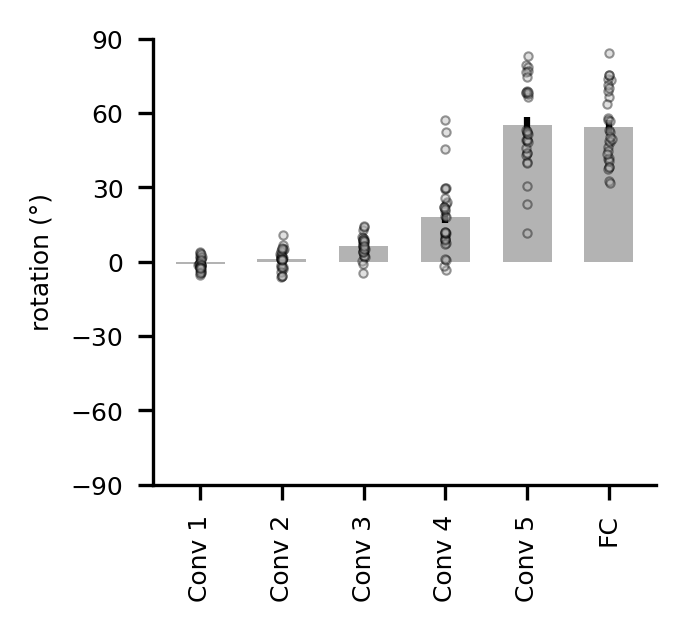

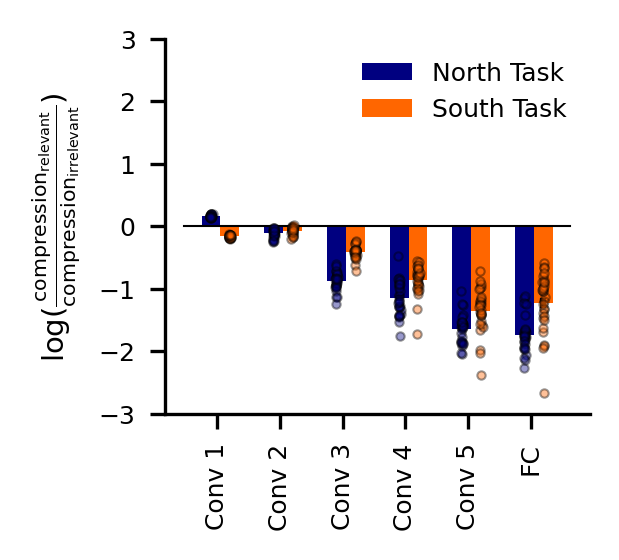

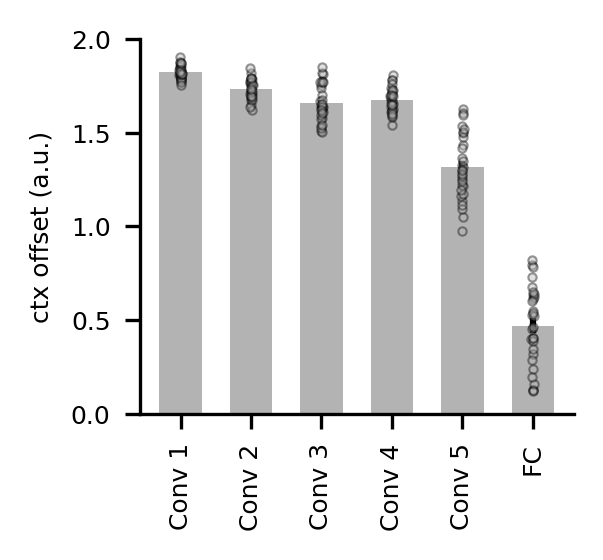

In [76]:
# rich regime

with open('parammod_alexnet_fromscratch.pkl','rb') as f:
    data = pickle.load(f)


mm = 1/25.4
f1 = plt.figure(1,figsize=(55*mm,50*mm), dpi=300)
f2 = plt.figure(2,figsize=(55*mm,50*mm), dpi=300)
f3 = plt.figure(3,figsize=(55*mm,50*mm), dpi=300)
f4 = plt.figure(4,figsize=(55*mm,50*mm), dpi=300)
layer_labels = ['Conv 1','Conv 2','Conv 3','Conv 4','Conv 5','FC']

for ii in range(len(layer_labels)):

    data_layer = np.array(data['thetas'])[ii,:,:]

    # plot relative compression
    plt.figure(f1.number)
    # north & south task task
    comp_north = np.log(data_layer[:,0]/data_layer[:,2])
    comp_south = np.log(data_layer[:,1]/data_layer[:,3])
    bn = plt.bar(ii-0.1,np.mean(comp_north),yerr=np.std(comp_north)/(len(comp_north)**.5),width=0.3,linewidth=2,color=(0,0,.5),zorder=1)
    bs = plt.bar(ii+0.2,np.mean(comp_south),yerr=np.std(comp_south)/(len(comp_south)**.5),width=0.3,linewidth=2,color=(255/255,102/255,0),zorder=1)
    plt.scatter(np.repeat((ii-0.1),len(comp_north))+np.random.randn(len(comp_north))*0.01,comp_north,s=4,color=(0,0,.5),alpha=.4,zorder=3,edgecolors='k',linewidth=0.5)
    plt.scatter(np.repeat((ii+0.2),len(comp_south))+np.random.randn(len(comp_north))*0.01,comp_south,s=4,color=(255/255,102/255,0),alpha=.4,zorder=3,edgecolors='k',linewidth=0.5)
    spiceUp_figure(f1,layer_labels)
    plt.ylabel(r'$\mathrm{log(\frac{compression_{relevant}}{compression_{irrelevant}})}$',fontsize=7)
    # plt.title('Estimated Compression \n Relevant vs Irrelevant Dimension',fontsize=6)
    plt.legend([bn,bs],['North Task','South Task'],frameon=False,loc=1,fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    
 

    # estimated ctx offset 
    plt.figure(f3.number)
    ctx_est = data_layer[:,5]
    bctx = plt.bar(ii,np.mean(ctx_est),yerr=np.std(ctx_est)/(len(ctx_est)**.5),width=0.6,color=(0.7,0.7,.7))
    plt.scatter(np.repeat(ii,len(ctx_est))+np.random.randn(len(comp_north))*0.01,ctx_est,color=(0.7,0.7,.7),alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.5)
    spiceUp_figure(f3,layer_labels)
    plt.ylabel('ctx offset (a.u.)',fontsize=6)
    # plt.title('Estimated Context Offset Parameter',fontsize=6)
    plt.ylim([0,2])
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    # plot estimated angle 
    plt.figure(f4.number)
    phi_est = data_layer[:,4]*(-1)
    bph = plt.bar(ii,np.mean(phi_est),yerr=np.std(phi_est)/(len(phi_est)**.5),width=0.6,color=(0.7,0.7,.7),zorder=1)
    plt.scatter(np.repeat(ii,len(phi_est))+np.random.randn(len(comp_north))*0.01,phi_est,color=(0.7,0.7,.7),alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.5)
    spiceUp_figure(f4,layer_labels)
    plt.ylabel('rotation (°)',fontsize=6)
    # plt.title('Estimated Rotation \n from Stimulus to Response Space',fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(ticks=[-90,-60,-30,0,30,60,90],fontsize=6)
    plt.ylim([-90,90])


plt.figure(f1.number)
plt.yticks(np.arange(-3,3.1,1)) 
plt.ylim([-3,3])
lims = plt.xlim()
plt.plot(lims,[0,0],'k-',linewidth=.5)
plt.tight_layout()

plt.figure(f3.number)
plt.tight_layout()
f = plt.gcf()
f.set_dpi(300)